In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1wJAcNmTdJVNCBZIZ3mPD2dwaAkAJY2_S'
output = 'Covid.zip'
gdown.download(url, output, quiet=False)

md5 = 'fa837a88f0c40c513d975104edf3da17'
gdown.cached_download(url, output, md5=md5, postprocess=gdown.extractall)

# Data Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# package imports

import classifier_functions
from classifier_functions import build_model, add_cnl, add_dense, oversampling

from joblib import Parallel, delayed

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.metrics import classification_report, confusion_matrix

from ast import literal_eval

import time
import datetime



import json

from random import sample
from random import seed

import tensorflow as tf

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
import os
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
#import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers as reg

from keras.callbacks import ModelCheckpoint

from sklearn.utils import resample

In [4]:
base_path = "Covid/data_upload_v3/"

# train
train_nocovid_path = "train/non/"
entries_train_nocovid = os.listdir(base_path + train_nocovid_path)
entries_train_nocovid = [train_nocovid_path + entry for entry in entries_train_nocovid]
print(entries_train_nocovid[0])
train_covid_path = "train/covid/"
entries_train_covid = os.listdir(base_path + train_covid_path)
entries_train_covid = [train_covid_path + entry for entry in entries_train_covid]
print(entries_train_covid[0])

#test
test_nocovid_path = "test/non_all/"
entries_test_nocovid = os.listdir(base_path + test_nocovid_path)
entries_test_nocovid = [test_nocovid_path + entry for entry in entries_test_nocovid]
print(entries_test_nocovid[0])
test_covid_path = "test/covid/"
entries_test_covid = os.listdir(base_path + test_covid_path)
entries_test_covid = [test_covid_path + entry for entry in entries_test_covid]
print(entries_test_covid[0])

# Size of dataset
print("Train no covid: " + str(len(entries_train_nocovid)))
print("Train covid: " + str(len(entries_train_covid)))
print("Test no covid: " + str(len(entries_test_nocovid)))
print("Test covid: " + str(len(entries_test_covid)))

train/non/Atelectasis-patient00028-study2-view1_frontal.jpg
train/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg
test/non_all/patient00024-study2-view1_frontal.jpg
test/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg
Train no covid: 2000
Train covid: 84
Test no covid: 3000
Test covid: 100


In [5]:
"""metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
def build_model(optimizer = 'adam'):
    classifier = Sequential()
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
    return classifier
    
def add_cnl(classifier, neurons, strd = (3, 3), p_size = (2,2), n = 0, drop = 0):
    if n == 0:
        classifier.add(Conv2D(neurons[0], strd, input_shape = (150, 150, 1), activation = 'relu'))
        classifier.add(MaxPooling2D(pool_size = p_size))
        for i in range(1, len(neurons)):
            classifier.add(Conv2D(neurons[i], strd, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))
            
    else:
        classifier.add(Conv2D(neurons, strd, input_shape = (150, 150, 1), activation = 'relu'))
        for i in range(1, n):
            classifier.add(Conv2D(neurons, strd, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))

    classifier.add(Flatten())
        
    if drop != 0:
        classifier.add(Dropout(drop))

def add_dense(classifier, neurons, n = 0, end = True, reg = None):
    if n == 0:
        for neu in neurons:
            classifier.add(Dense(neu,kernel_regularizer = reg, activation = 'relu'))

    else:
        for i in range(n):
            classifier.add(Dense(neurons,kernel_regularizer = reg ,activation = 'relu'))
    
    if end:
        classifier.add(Dense(units = 1, activation = 'sigmoid'))

#Oversampling


def oversampling(traindf):
    covid_df_upsampled = resample(traindf.loc[traindf["class"]=="1"],
                          replace=True, # sample with replacement
                          n_samples=len(traindf.loc[traindf["class"]=="0"]), # match number in majority class
                          random_state=23) # reproducible results
    upsampled= pd.concat([covid_df_upsampled, traindf.loc[traindf["class"]=="0"]])
    return upsampled
"""

'metrics = [\n      keras.metrics.BinaryAccuracy(name=\'accuracy\'),\n      keras.metrics.Precision(name=\'precision\'),\n      keras.metrics.Recall(name=\'recall\'),\n      keras.metrics.AUC(name=\'auc\'),\n]\ndef build_model(optimizer = \'adam\'):\n    classifier = Sequential()\n    classifier.compile(optimizer = optimizer, loss = \'binary_crossentropy\', metrics = metrics)\n    return classifier\n    \ndef add_cnl(classifier, neurons, strd = (3, 3), p_size = (2,2), n = 0, drop = 0):\n    if n == 0:\n        classifier.add(Conv2D(neurons[0], strd, input_shape = (150, 150, 1), activation = \'relu\'))\n        classifier.add(MaxPooling2D(pool_size = p_size))\n        for i in range(1, len(neurons)):\n            classifier.add(Conv2D(neurons[i], strd, activation = \'relu\'))\n            classifier.add(MaxPooling2D(pool_size = p_size))\n            \n    else:\n        classifier.add(Conv2D(neurons, strd, input_shape = (150, 150, 1), activation = \'relu\'))\n        for i in range(1, n

In [6]:
def plot_metrics(history, metrics = ['loss',  "accuracy" ,'auc', 'precision', 'recall',"f1"]):
  
  if "f1" in metrics:
    precision = history["precision"]
    recall = history["recall"]
    precision_val = history["val_precision"]
    recall_val = history["val_recall"]
    f1 = []
    f1_val = []
    for i in range(len(precision)):
      if (precision[i]+recall[i]) == 0:
        f1_single = 0
      else:
        f1_single = (2*precision[i]*recall[i])/(precision[i]+recall[i])
      if (precision_val[i]+recall_val[i]) == 0:
        f1_val_single = 0
      else:
        f1_val_single = (2*precision_val[i]*recall_val[i])/(precision_val[i]+recall_val[i])
      f1.append(f1_single)
      f1_val.append(f1_val_single)
    history["f1"] = f1
    history["val_f1"] = f1_val
  plt.figure(figsize=(15,15))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(range(len(history[metric])), history[metric], label='Train')
    plt.plot(range(len(history[metric])), history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()
  plt.show(block=False)

In [7]:
X_train_paths = entries_train_nocovid + entries_train_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_train_labels = [ 0 for i in range(len(entries_train_nocovid))] + [ 1 for i in range(len(entries_train_covid))]

X_test_paths = entries_test_nocovid + entries_test_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_test_labels = [ 0 for i in range(len(entries_test_nocovid))] + [ 1 for i in range(len(entries_test_covid))]

# Visualization of Image Augmentation

In [17]:
#Visualization of Image Augmentation

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# load the image
chosen_image = base_path + X[2082]
img = load_img(chosen_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# prepare iterator
it = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(16,15))
for i in range(9):
    #define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    image = batch[0]
    plt.imshow(image)
plt.show()

NameError: name 'X' is not defined

# Models

In [ ]:
model = build_model(optimizer = 'rmsprop')
add_cnl(model,neurons = 32, n = 2, strd = (4, 4) ) #
add_dense(model, neurons = 32, n = 2 )

In [ ]:
model = build_model()
add_cnl(model,neurons = 32, n=1, p_size = (3,3) ,drop = 0.2 ) #layers with different dimension
add_dense(model, neurons = [64, 32], reg= reg.l1_l2(0.001, 0.001) )

In [ ]:
model = build_model()
add_cnl(model,neurons = [32, 64]) #layers with different dimension
add_dense(model, neurons = 32, n = 2, reg = reg.l2(0.001)  )

## Training with class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
w = compute_class_weight('balanced',  np.unique(y_train_labels),  y_train_labels)
class_weight = {0: w[0], 1: w[1]}

###### K Fold Validation step => 0 #####
Found 1875 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/60
7/7 [==============================] - 111s 3s/step - loss: 0.7052 - accuracy: 0.5119 - precision: 0.0415 - recall: 0.5756 - auc: 0.5188 - val_loss: 0.7465 - val_accuracy: 0.0431 - val_precision: 0.0431 - val_recall: 1.0000 - val_auc: 0.2497
Epoch 2/60
7/7 [==============================] - 6s 333ms/step - loss: 0.7052 - accuracy: 0.4089 - precision: 0.0376 - recall: 0.5477 - auc: 0.4950 - val_loss: 0.6771 - val_accuracy: 0.9569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7981
Epoch 3/60
7/7 [==============================] - 11s 267ms/step - loss: 0.7187 - accuracy: 0.9071 - precision: 0.0899 - recall: 0.1869 - auc: 0.7387 - val_loss: 0.5258 - val_accuracy: 0.9569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9458
Epoch 4/60
7/7 [==============================] - 11s 252ms/

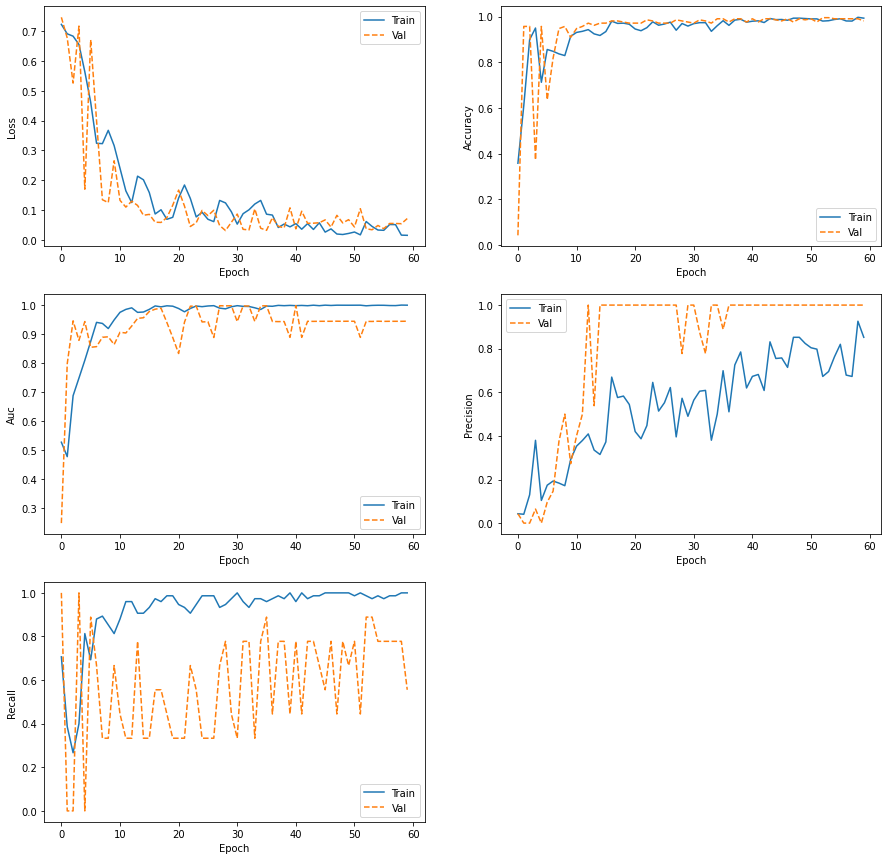

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.56      0.71         9

    accuracy                           0.98       209
   macro avg       0.99      0.78      0.85       209
weighted avg       0.98      0.98      0.98       209



FileNotFoundError: ignored

In [ ]:
model_number = 1 
k = 10
number_of_its = 5
epochs = 60

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 268
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

seed(42)
w = sample(range(k), number_of_its)
for i, (train_index, val_index) in enumerate(kf.split(X,y)):
#    if i not in w:
#      continue
    
    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model1 = build_model()
    add_cnl(model1,neurons = [32, 64, 128], drop = 0.2 )
    add_dense(model1, neurons = 256, n = 2 )

    history = model1.fit(
            train_generator,
            steps_per_epoch=7,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, class_weight=class_weight)
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model1.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[0], open("Covid/histories/model"+str(i)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)
  

## Test set evaluation

In [ ]:
train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 20,
                              width_shift_range=0.1,
                              height_shift_range = 0.1,
                              zoom_range=[0.8, 1.3],
                              brightness_range=[0.8,1.2],
                              horizontal_flip=True,
                              fill_mode = "constant")

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = base_path,
                                                    target_size= shape,
                                                    batch_size = train_batch,
                                                    color_mode = "grayscale", 
                                                    class_mode = "binary")

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_df, 
                                                                          directory = base_path,
                                                                          target_size = shape, 
                                                                          batch_size = val_batch,
                                                                          color_mode = "grayscale", 
                                                                          class_mode = "binary",
                                                                          shuffle = False)


Found 2084 validated image filenames belonging to 2 classes.
Found 3100 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 40 #empirically should have somewhat converged


prova = build_model()
add_cnl(prova,neurons = [32, 64, 128], drop = 0.2 )
add_dense(prova, neurons = 256, n = 2 )

history = prova.fit(
        train_generator,
        steps_per_epoch=7,
        epochs=epochs,
        workers=8, class_weight=class_weight)

Epoch 1/40
7/7 [==============================] - 7s 210ms/step - loss: 0.9637 - accuracy: 0.3423 - precision: 0.0399 - recall: 0.6616 - auc: 0.5236
Epoch 2/40
7/7 [==============================] - 6s 124ms/step - loss: 0.6603 - accuracy: 0.5739 - precision: 0.0421 - recall: 0.4849 - auc: 0.5663
Epoch 3/40
7/7 [==============================] - 6s 256ms/step - loss: 0.6933 - accuracy: 0.7293 - precision: 0.2145 - recall: 0.5601 - auc: 0.6970
Epoch 4/40
7/7 [==============================] - 6s 94ms/step - loss: 0.6296 - accuracy: 0.8877 - precision: 0.1367 - recall: 0.3965 - auc: 0.7317
Epoch 5/40
7/7 [==============================] - 6s 297ms/step - loss: 0.6738 - accuracy: 0.7425 - precision: 0.1164 - recall: 0.7091 - auc: 0.7691
Epoch 6/40
7/7 [==============================] - 6s 107ms/step - loss: 0.5937 - accuracy: 0.5421 - precision: 0.0819 - recall: 0.8407 - auc: 0.8158
Epoch 7/40
7/7 [==============================] - 6s 95ms/step - loss: 0.4679 - accuracy: 0.8419 - precisio

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
Y_pred = prova.predict(test_generator, nb_samples) 
Y_pred = (Y_pred>0.5)
test_y_true_list.extend(test_generator.classes)
test_y_predictions_list.extend(Y_pred)
target_names = ['No Covid', 'Covid']
report = classification_report(test_generator.classes, Y_pred, target_names=target_names)
print('Classification Report')
print(report)

KeyboardInterrupt: ignored

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [ ]:
Y_pred = prova.predict(test_generator, nb_samples)
Y_pred = (Y_pred>0.5)

In [ ]:
test_y_true_list = []
test_y_predictions_list = []
test_y_true_list.extend(test_generator.classes)
test_y_predictions_list.extend(Y_pred)
target_names = ['No Covid', 'Covid']
report = classification_report(test_generator.classes, Y_pred, target_names=target_names)
print('Classification Report')
print(report)

Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00      3000
       Covid       1.00      0.79      0.88       100

    accuracy                           0.99      3100
   macro avg       1.00      0.90      0.94      3100
weighted avg       0.99      0.99      0.99      3100



In [ ]:
len(Y_pred)

3100

## **Oversampling with callbacks**

### model 62

In [20]:

model_number = 62
k = 10
number_of_its = 10
epochs = 20

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.2 )
    add_dense(model, neurons = 256, n = 2 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 30s 1s/step - loss: 0.5682 - accuracy: 0.7474 - precision: 0.8383 - recall: 0.6121 - auc: 0.8530 - val_loss: 0.3851 - val_accuracy: 0.8421 - val_precision: 0.2143 - val_recall: 1.0000 - val_auc: 0.9153
Epoch 2/20
24/24 [==============================] - 26s 1s/step - loss: 0.2982 - accuracy: 0.8767 - precision: 0.8779 - recall: 0.8750 - auc: 0.9449 - val_loss: 0.2082 - val_accuracy: 0.9187 - val_precision: 0.3182 - val_recall: 0.7778 - val_auc: 0.9553
Epoch 3/20
24/24 [==============================] - 26s 1s/step - loss: 0.2656 - accuracy: 0.8886 - precision: 0.8846 - recall: 0.8939 - auc: 0.9570 - val_loss: 0.1931 - val_accuracy: 0.9187 - val_precision: 0.3182 - val_recall: 0.7778 - val_auc: 0.9572
Epoch 4/20
24/24 [==============================] - 31s 1s/step - loss: 0.22

Epoch 20/20
24/24 [==============================] - 23s 979ms/step - loss: 0.0652 - accuracy: 0.9769 - precision: 0.9725 - recall: 0.9817 - auc: 0.9971 - val_loss: 0.0195 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9994
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209

0:10:21.683812
###### K Fold Validation step => 3 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 25s 1s/step - loss: 0.5836 - accuracy: 0.6994 - precision: 0.6979 - recall: 0.6473 - auc: 0.7846 - val_loss: 0.5538 - val_accuracy: 0.7512 - val_precision: 0.1475 -

Epoch 8/20
24/24 [==============================] - 23s 977ms/step - loss: 0.1334 - accuracy: 0.9531 - precision: 0.9415 - recall: 0.9661 - auc: 0.9883 - val_loss: 0.0277 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 1.0000
Epoch 9/20
24/24 [==============================] - 23s 973ms/step - loss: 0.0922 - accuracy: 0.9625 - precision: 0.9587 - recall: 0.9667 - auc: 0.9940 - val_loss: 0.0160 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 1.0000
Epoch 10/20
24/24 [==============================] - 22s 935ms/step - loss: 0.0731 - accuracy: 0.9767 - precision: 0.9730 - recall: 0.9806 - auc: 0.9955 - val_loss: 0.0090 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 0.9994
Epoch 11/20
24/24 [==============================] - 22s 911ms/step - loss: 0.0984 - accuracy: 0.9650 - precision: 0.9589 - recall: 0.9717 - auc: 0.9924 - val_loss: 0.0159 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_rec

Epoch 18/20
24/24 [==============================] - 28s 1s/step - loss: 0.0613 - accuracy: 0.9786 - precision: 0.9741 - recall: 0.9833 - auc: 0.9963 - val_loss: 0.0066 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 19/20
24/24 [==============================] - 28s 1s/step - loss: 0.0606 - accuracy: 0.9778 - precision: 0.9736 - recall: 0.9822 - auc: 0.9966 - val_loss: 0.0058 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 20/20
24/24 [==============================] - 29s 1s/step - loss: 0.0573 - accuracy: 0.9808 - precision: 0.9774 - recall: 0.9844 - auc: 0.9974 - val_loss: 0.0102 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 1.0000
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00      

24/24 [==============================] - 23s 979ms/step - loss: 0.0841 - accuracy: 0.9703 - precision: 0.9633 - recall: 0.9778 - auc: 0.9948 - val_loss: 0.0627 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 0.9325
Epoch 17/20
24/24 [==============================] - 24s 1s/step - loss: 0.0700 - accuracy: 0.9739 - precision: 0.9661 - recall: 0.9822 - auc: 0.9963 - val_loss: 0.0733 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 0.9337
Epoch 18/20
24/24 [==============================] - 25s 1s/step - loss: 0.0731 - accuracy: 0.9708 - precision: 0.9654 - recall: 0.9767 - auc: 0.9953 - val_loss: 0.0728 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 0.9347
Epoch 19/20
24/24 [==============================] - 23s 969ms/step - loss: 0.0742 - accuracy: 0.9731 - precision: 0.9681 - recall: 0.9783 - auc: 0.9963 - val_loss: 0.0544 - val_accuracy: 0.9904 - val_precision: 0.8750 - val_recall: 0.8750 - va

In [ ]:
#hide
model_number = 1
k = 10
number_of_its = 10
epochs = 20

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []


def train(i, train_index, val_index):
    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [32, 64, 128], drop = 0.2 )
    add_dense(model, neurons = 256, n = 2 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
        callbacks=[callbacks[i]])
    #histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    #reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    #times.append(str(datetime.timedelta(seconds=time2)))
    return history, reports, str(datetime.timedelta(seconds=time2))
    
out = Parallel(n_jobs=10, verbose=100,backend='multiprocessing')(
    delayed(train)(i, train_index, val_index) for i, (train_index, val_index) in enumerate(kf.split(X,y)))

    
    

FOLD: 0best epoch: 12F1 score: 0.8235294191895058
FOLD: 1best epoch: 13F1 score: 0.9411764743006353
FOLD: 2best epoch: 16F1 score: 0.9411764743006353
FOLD: 3best epoch: 15F1 score: 1.0
FOLD: 4best epoch: 7F1 score: 0.9411764743006353
FOLD: 5best epoch: 16F1 score: 1.0
FOLD: 6best epoch: 16F1 score: 1.0
FOLD: 7best epoch: 14F1 score: 0.875
FOLD: 8best epoch: 15F1 score: 0.9333333333333333
FOLD: 9best epoch: 8F1 score: 1.0
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames

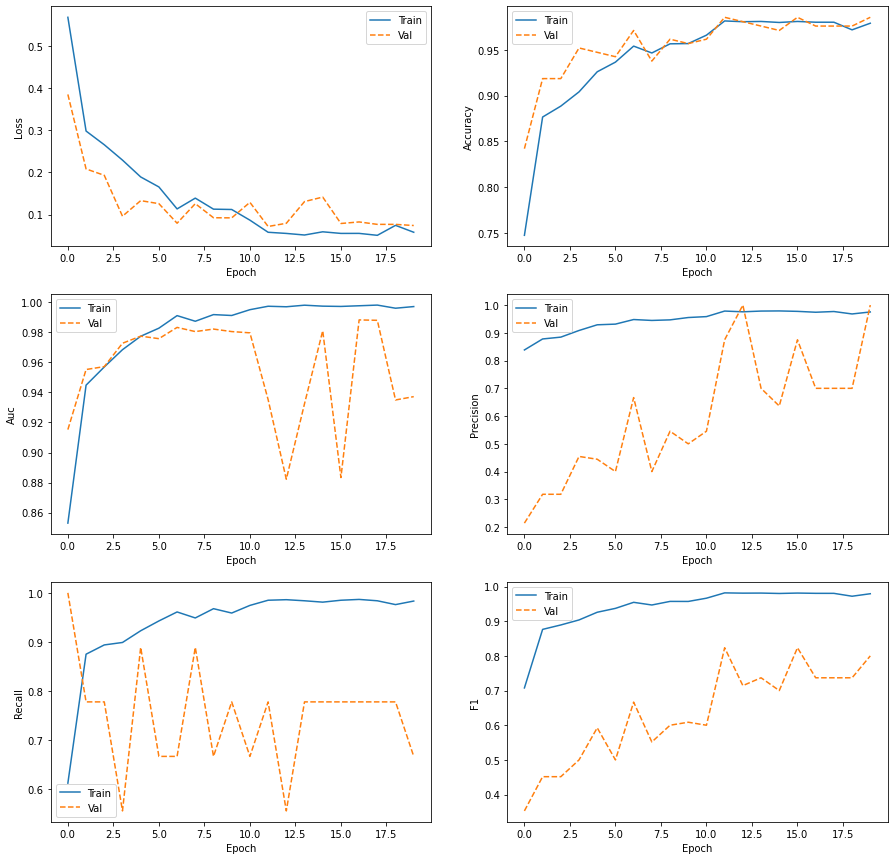

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.67      0.80         9

    accuracy                           0.99       209
   macro avg       0.99      0.83      0.90       209
weighted avg       0.99      0.99      0.98       209


Iteration 1


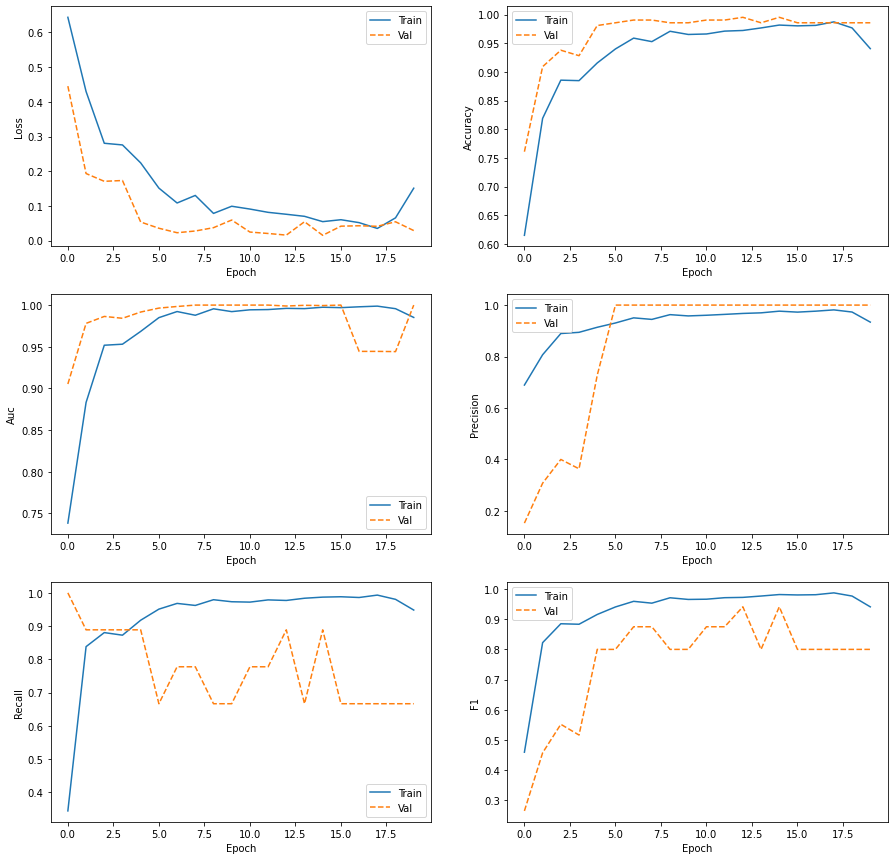

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.67      0.80         9

    accuracy                           0.99       209
   macro avg       0.99      0.83      0.90       209
weighted avg       0.99      0.99      0.98       209


Iteration 2


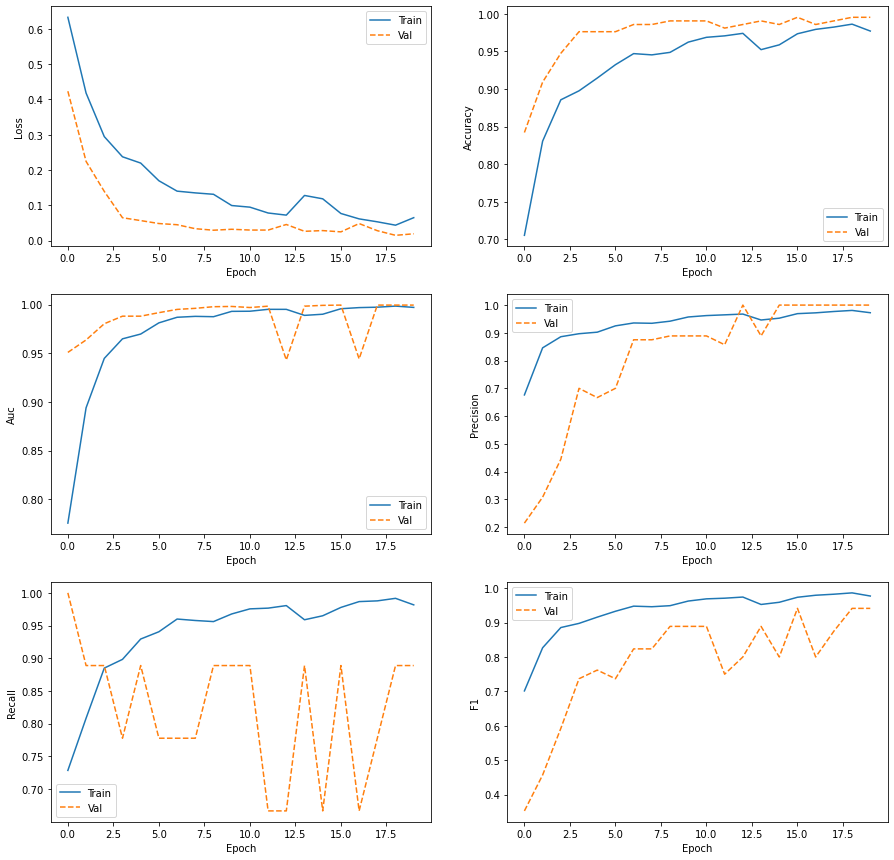

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 3


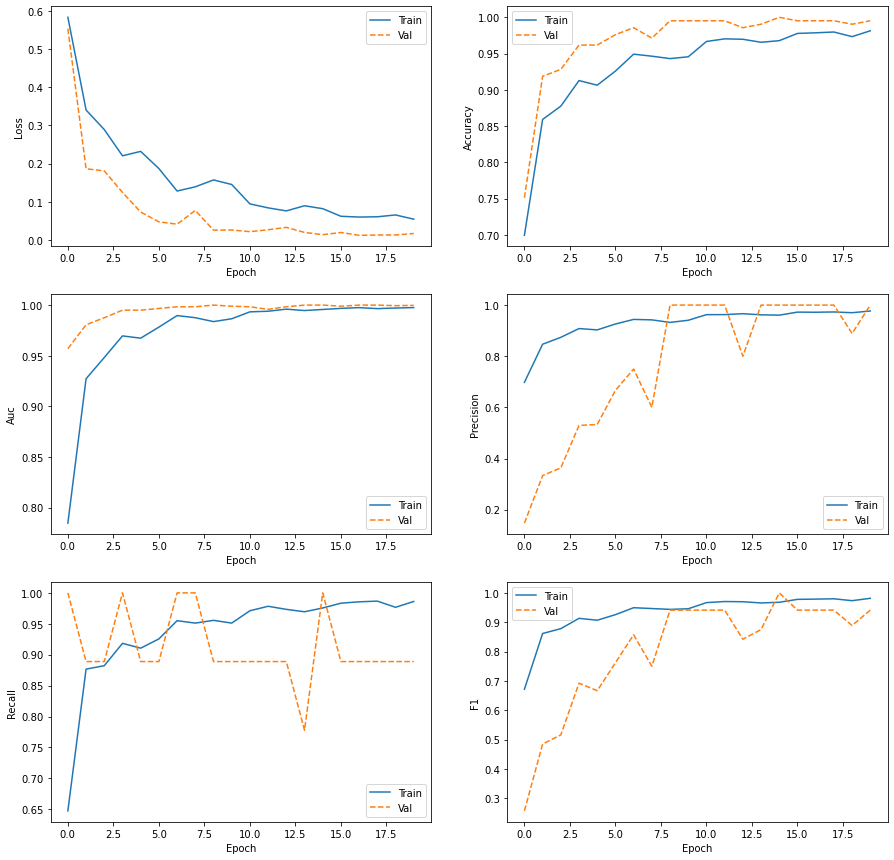

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 4


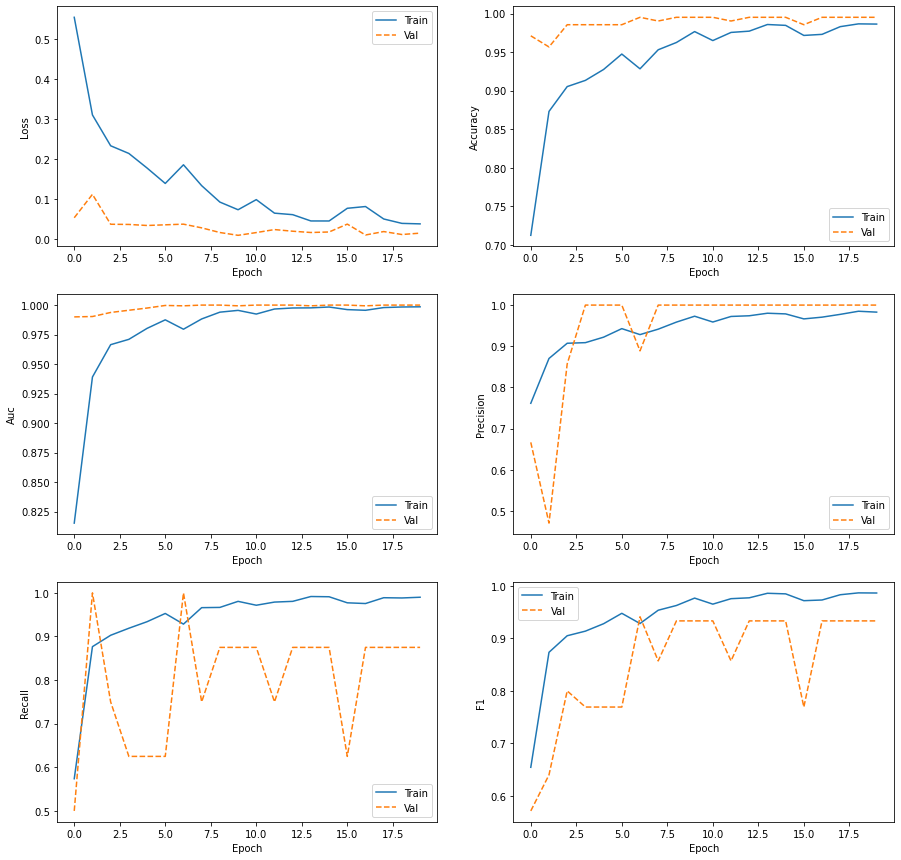

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 5


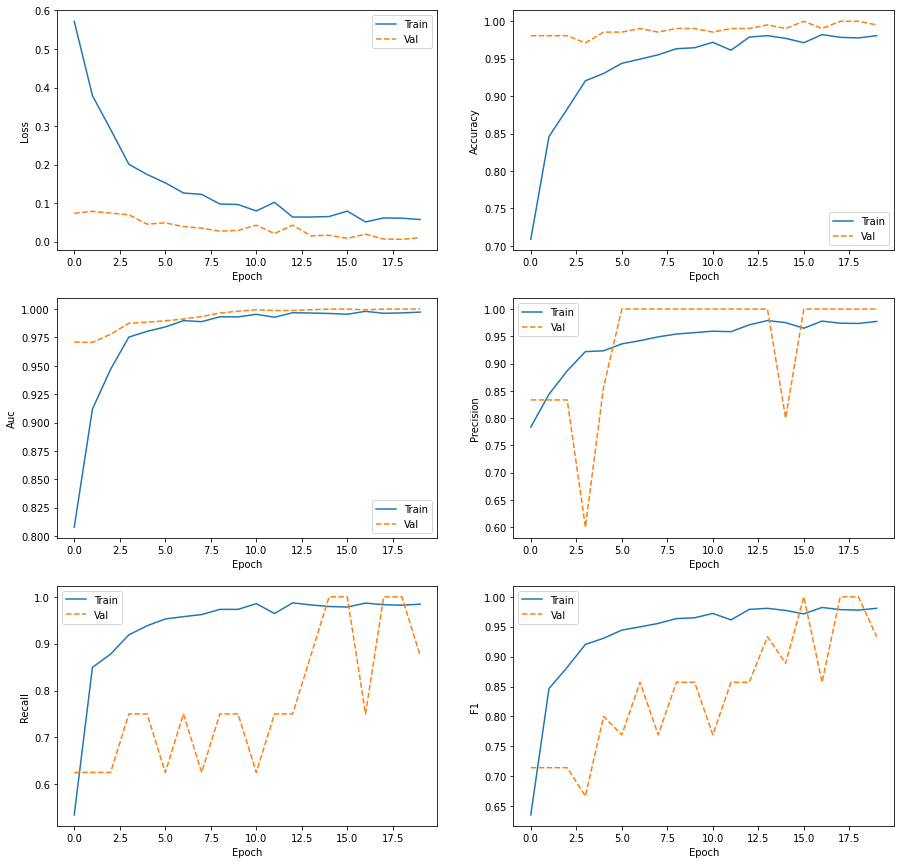

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 6


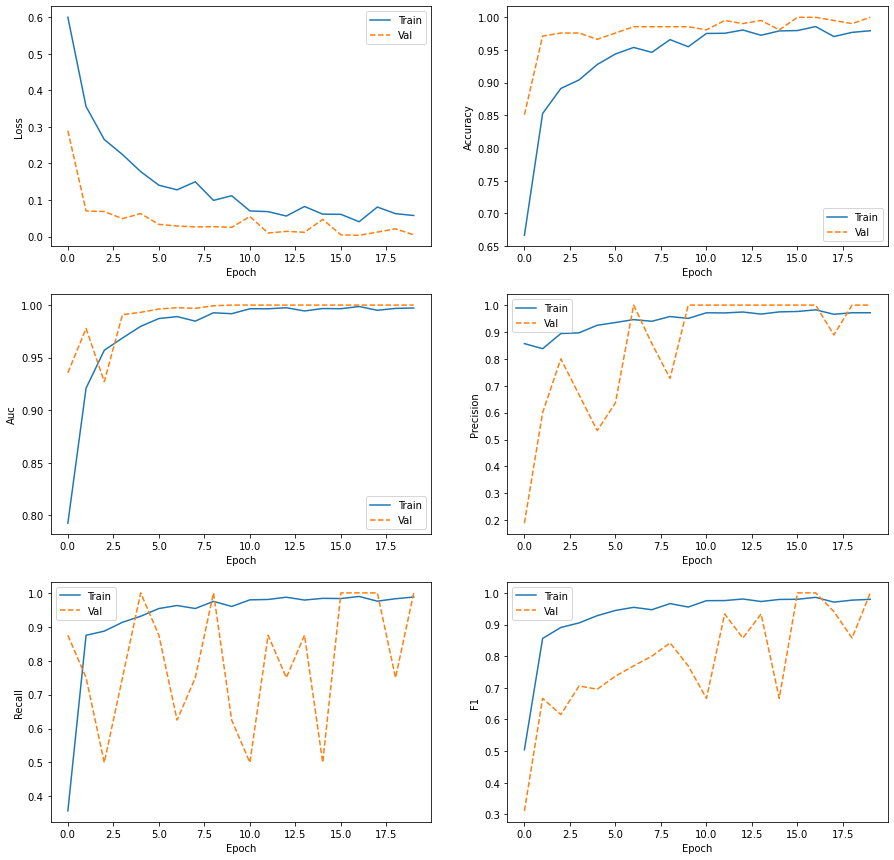

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 7


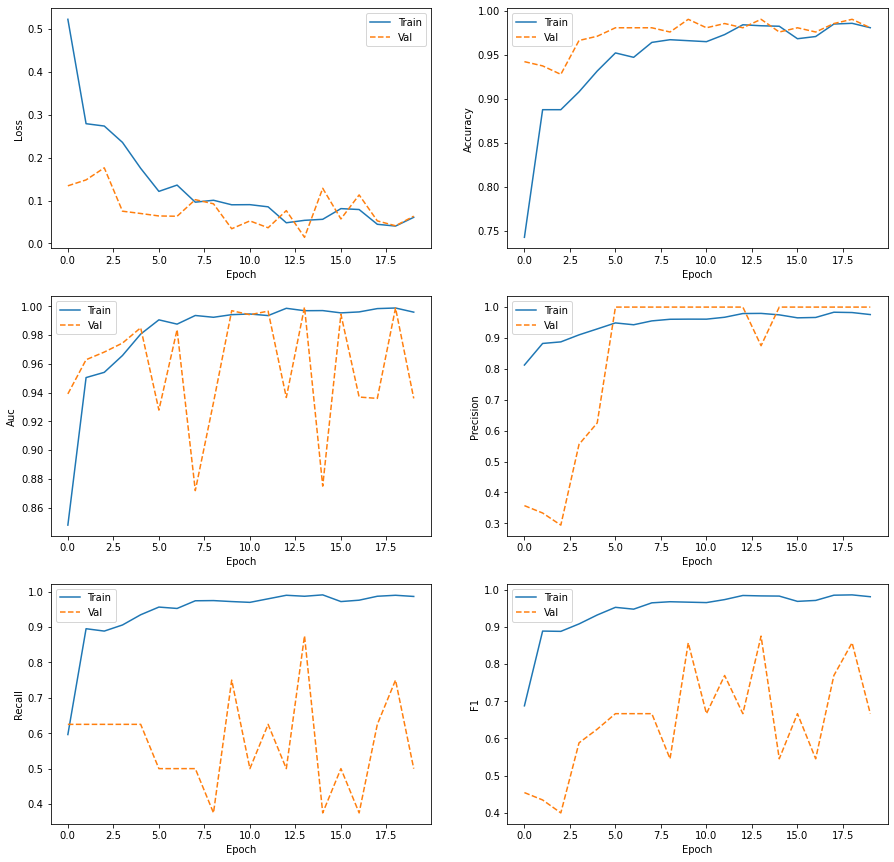

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 8


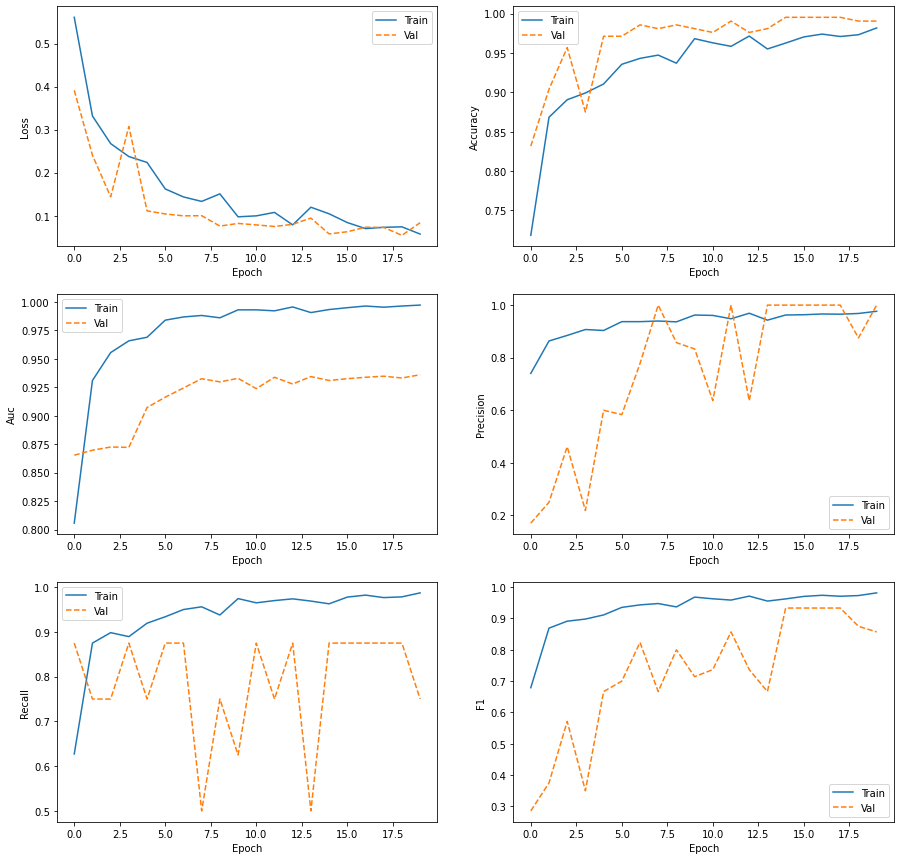

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 9


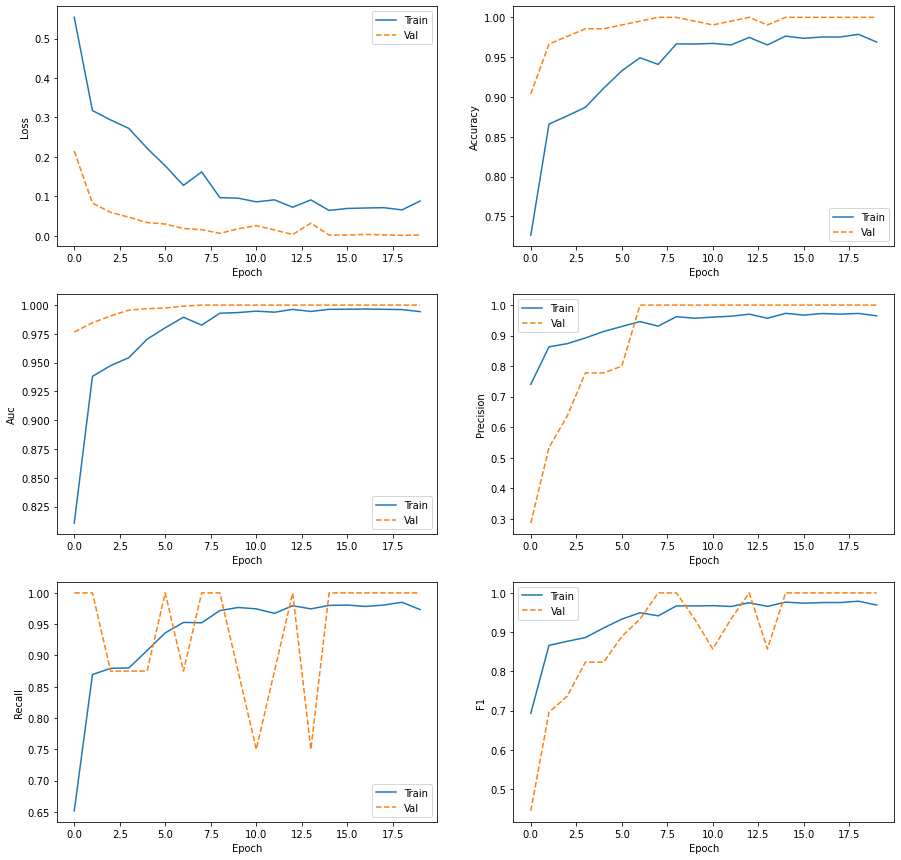

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1995    5]
 [  18   66]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99      2000
       Covid       0.93      0.79      0.85        84

    accuracy                           0.99      2084
   macro avg       0.96      0.89      0.92      2084
weighted avg       0.99      0.99      0.99      2084

['0:12:15.633332', '0:10:50.802416', '0:10:21.683812', '0:10:49.855009', '0:10:40.997367', '0:12:58.002506', '0:14:23.802034', '0:13:49.343342', '0:11:55.624684', '0:10:49.026188']


In [23]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[0], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

In [24]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 148, 148, 16)      160       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 15, 15, 128)     

### model 63

In [22]:
model_number = 63
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4 )
    add_dense(model, neurons = 256, n = 3 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 71s 3s/step - loss: 0.5886 - accuracy: 0.6628 - precision: 0.6845 - recall: 0.6039 - auc: 0.7486 - val_loss: 0.2946 - val_accuracy: 0.8708 - val_precision: 0.1786 - val_recall: 0.5556 - val_auc: 0.8886
Epoch 2/30
24/24 [==============================] - 64s 3s/step - loss: 0.3382 - accuracy: 0.8622 - precision: 0.8618 - recall: 0.8628 - auc: 0.9283 - val_loss: 0.2818 - val_accuracy: 0.8900 - val_precision: 0.2083 - val_recall: 0.5556 - val_auc: 0.9200
Epoch 3/30
24/24 [==============================] - 67s 3s/step - loss: 0.2920 - accuracy: 0.8792 - precision: 0.9003 - recall: 0.8528 - auc: 0.9479 - val_loss: 0.1603 - val_accuracy: 0.9330 - val_precision: 0.3333 - val_recall: 0.5556 - val_auc: 0.9522
Epoch 4/30
24/24 [==============================] - 62s 3s/step - loss: 0.27

Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 61s 3s/step - loss: 0.5965 - accuracy: 0.6868 - precision: 0.6774 - recall: 0.6501 - auc: 0.7675 - val_loss: 0.4056 - val_accuracy: 0.8182 - val_precision: 0.1915 - val_recall: 1.0000 - val_auc: 0.9481
Epoch 2/30
24/24 [==============================] - 58s 2s/step - loss: 0.3621 - accuracy: 0.8503 - precision: 0.8513 - recall: 0.8489 - auc: 0.9191 - val_loss: 0.2870 - val_accuracy: 0.9043 - val_precision: 0.2963 - val_recall: 0.8889 - val_auc: 0.9686
Epoch 3/30
24/24 [==============================] - 60s 3s/step - loss: 0.3195 - accuracy: 0.8706 - precision: 0.8773 - recall: 0.8617 - auc: 0.9362 - val_loss: 0.1101 - val_accuracy: 0.9617 - val_precision: 0.5333 - val_recall: 0.8889 - val_auc: 0.9842
Epoch 4/30
24/24 [==============================] - 80s 3s/step - loss: 0.2651 - accuracy: 0.8947 - precision: 0.9012

Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 66s 3s/step - loss: 0.5465 - accuracy: 0.7217 - precision: 0.7204 - recall: 0.6766 - auc: 0.8148 - val_loss: 0.3212 - val_accuracy: 0.8660 - val_precision: 0.2432 - val_recall: 1.0000 - val_auc: 0.9619
Epoch 2/30
24/24 [==============================] - 64s 3s/step - loss: 0.3660 - accuracy: 0.8514 - precision: 0.8504 - recall: 0.8528 - auc: 0.9158 - val_loss: 0.0785 - val_accuracy: 0.9713 - val_precision: 0.6364 - val_recall: 0.7778 - val_auc: 0.9792
Epoch 3/30
24/24 [==============================] - 64s 3s/step - loss: 0.2902 - accuracy: 0.8861 - precision: 0.8985 - recall: 0.8706 - auc: 0.9470 - val_loss: 0.1108 - val_accuracy: 0.9665 - val_precision: 0.5714 - val_recall: 0.8889 - val_auc: 0.9842
Epoch 4/30
24/24 [==============================] - 63s 3s/step - loss: 0.2294 - accuracy: 0.9047 - precision: 0.8949 - recall: 0.9172 - auc: 0.9665 - val_loss: 0.0552 - val_accu

Epoch 1/30
24/24 [==============================] - 67s 3s/step - loss: 0.5432 - accuracy: 0.7141 - precision: 0.8543 - recall: 0.4798 - auc: 0.8387 - val_loss: 0.0728 - val_accuracy: 0.9617 - val_precision: 0.5455 - val_recall: 0.6667 - val_auc: 0.9853
Epoch 2/30
24/24 [==============================] - 62s 3s/step - loss: 0.2811 - accuracy: 0.8858 - precision: 0.8843 - recall: 0.8878 - auc: 0.9506 - val_loss: 0.0516 - val_accuracy: 0.9761 - val_precision: 0.7500 - val_recall: 0.6667 - val_auc: 0.9925
Epoch 3/30
24/24 [==============================] - 63s 3s/step - loss: 0.2590 - accuracy: 0.8922 - precision: 0.8888 - recall: 0.8967 - auc: 0.9587 - val_loss: 0.1029 - val_accuracy: 0.9665 - val_precision: 0.5714 - val_recall: 0.8889 - val_auc: 0.9889
Epoch 4/30
24/24 [==============================] - 57s 2s/step - loss: 0.2000 - accuracy: 0.9164 - precision: 0.9116 - recall: 0.9222 - auc: 0.9751 - val_loss: 0.0440 - val_accuracy: 0.9856 - val_precision: 0.8750 - val_recall: 0.7778 - 

24/24 [==============================] - 57s 2s/step - loss: 0.5994 - accuracy: 0.6833 - precision: 0.7162 - recall: 0.5514 - auc: 0.7653 - val_loss: 0.1721 - val_accuracy: 0.9663 - val_precision: 0.5556 - val_recall: 0.6250 - val_auc: 0.9531
Epoch 2/30
24/24 [==============================] - 58s 2s/step - loss: 0.3317 - accuracy: 0.8722 - precision: 0.8665 - recall: 0.8800 - auc: 0.9316 - val_loss: 0.1841 - val_accuracy: 0.9327 - val_precision: 0.3333 - val_recall: 0.7500 - val_auc: 0.9609
Epoch 3/30
24/24 [==============================] - 58s 2s/step - loss: 0.2777 - accuracy: 0.8872 - precision: 0.8890 - recall: 0.8850 - auc: 0.9520 - val_loss: 0.2726 - val_accuracy: 0.8990 - val_precision: 0.2593 - val_recall: 0.8750 - val_auc: 0.9703
Epoch 4/30
24/24 [==============================] - 59s 2s/step - loss: 0.2650 - accuracy: 0.8944 - precision: 0.8958 - recall: 0.8928 - auc: 0.9564 - val_loss: 0.3013 - val_accuracy: 0.8798 - val_precision: 0.2258 - val_recall: 0.8750 - val_auc: 0.

24/24 [==============================] - 63s 3s/step - loss: 0.5835 - accuracy: 0.6741 - precision: 0.6894 - recall: 0.5708 - auc: 0.7800 - val_loss: 0.1210 - val_accuracy: 0.9471 - val_precision: 0.3636 - val_recall: 0.5000 - val_auc: 0.9384
Epoch 2/30
24/24 [==============================] - 56s 2s/step - loss: 0.2810 - accuracy: 0.8856 - precision: 0.8809 - recall: 0.8917 - auc: 0.9506 - val_loss: 0.1535 - val_accuracy: 0.9375 - val_precision: 0.3333 - val_recall: 0.6250 - val_auc: 0.9575
Epoch 3/30
24/24 [==============================] - 56s 2s/step - loss: 0.2625 - accuracy: 0.8964 - precision: 0.9024 - recall: 0.8889 - auc: 0.9571 - val_loss: 0.1727 - val_accuracy: 0.9279 - val_precision: 0.2941 - val_recall: 0.6250 - val_auc: 0.9659
Epoch 4/30
24/24 [==============================] - 65s 3s/step - loss: 0.2374 - accuracy: 0.9025 - precision: 0.9091 - recall: 0.8944 - auc: 0.9654 - val_loss: 0.1505 - val_accuracy: 0.9423 - val_precision: 0.3750 - val_recall: 0.7500 - val_auc: 0.

24/24 [==============================] - 54s 2s/step - loss: 0.5293 - accuracy: 0.7363 - precision: 0.8268 - recall: 0.5625 - auc: 0.8470 - val_loss: 0.1195 - val_accuracy: 0.9471 - val_precision: 0.4000 - val_recall: 0.7500 - val_auc: 0.9688
Epoch 2/30
24/24 [==============================] - 52s 2s/step - loss: 0.3081 - accuracy: 0.8753 - precision: 0.8738 - recall: 0.8772 - auc: 0.9411 - val_loss: 0.0754 - val_accuracy: 0.9615 - val_precision: 0.5000 - val_recall: 0.7500 - val_auc: 0.9769
Epoch 3/30
24/24 [==============================] - 44s 2s/step - loss: 0.2645 - accuracy: 0.8897 - precision: 0.8886 - recall: 0.8911 - auc: 0.9574 - val_loss: 0.0608 - val_accuracy: 0.9712 - val_precision: 0.6000 - val_recall: 0.7500 - val_auc: 0.9856
Epoch 4/30
24/24 [==============================] - 47s 2s/step - loss: 0.2301 - accuracy: 0.9028 - precision: 0.9019 - recall: 0.9039 - auc: 0.9672 - val_loss: 0.0455 - val_accuracy: 0.9856 - val_precision: 0.8571 - val_recall: 0.7500 - val_auc: 0.

In [17]:
model_number = 62
k = 10

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)
X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

model = build_model()
add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4 )
add_dense(model, neurons = 256, n = 3 )


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]

best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))
print("Best median epoch: ",val_epoch+1)


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.50)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

FOLD: 0best epoch: 30F1 score: 0.8421052727342643
FOLD: 1best epoch: 14F1 score: 0.9411764743006353
FOLD: 2best epoch: 23F1 score: 0.9473684078438459
FOLD: 3best epoch: 5F1 score: 0.9411764743006353
FOLD: 4best epoch: 8F1 score: 1.0
FOLD: 5best epoch: 19F1 score: 1.0
FOLD: 6best epoch: 17F1 score: 0.9333333333333333
FOLD: 7best epoch: 19F1 score: 0.9333333333333333
FOLD: 8best epoch: 21F1 score: 0.9333333333333333
FOLD: 9best epoch: 7F1 score: 1.0
Best median epoch:  18
Found 209 validated image filenames belonging to 2 classes.


ValueError: You are trying to load a weight file containing 8 layers into a model with 9 layers.

### Model 64

In [11]:
model_number = 64
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64,128,256,256], drop = 0.4 )
    add_dense(model, neurons = 256, n = 3 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6524 - accuracy: 0.5842 - precision: 0.6142 - recall: 0.4528 - auc: 0.6554 - val_loss: 0.1612 - val_accuracy: 0.9187 - val_precision: 0.2778 - val_recall: 0.5556 - val_auc: 0.9364
Epoch 2/30
24/24 [==============================] - 24s 983ms/step - loss: 0.3485 - accuracy: 0.8564 - precision: 0.8626 - recall: 0.8478 - auc: 0.9263 - val_loss: 0.1329 - val_accuracy: 0.9474 - val_precision: 0.4167 - val_recall: 0.5556 - val_auc: 0.9650
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.2533 - accuracy: 0.8922 - precision: 0.8957 - recall: 0.8878 - auc: 0.9612 - val_loss: 0.1220 - val_accuracy: 0.9474 - val_precision: 0.4167 - val_recall: 0.5556 - val_auc: 0.9633
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0

Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 0.6512 - accuracy: 0.6151 - precision: 0.5987 - recall: 0.5749 - auc: 0.6882 - val_loss: 0.1227 - val_accuracy: 0.9761 - val_precision: 0.7500 - val_recall: 0.6667 - val_auc: 0.9867
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 0.3464 - accuracy: 0.8497 - precision: 0.8527 - recall: 0.8456 - auc: 0.9261 - val_loss: 0.0886 - val_accuracy: 0.9761 - val_precision: 0.6667 - val_recall: 0.8889 - val_auc: 0.9864
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.2561 - accuracy: 0.8919 - precision: 0.9048 - recall: 0.8761 - auc: 0.9605 - val_loss: 0.1058 - val_accuracy: 0.9617 - val_precision: 0.5333 - val_recall: 0.8889 - val_auc: 0.9886
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.2092 - accuracy: 0.9114 - precision: 0.9144 - recall: 0.9078 - auc: 0.9736 - val_loss: 0.1671 - val_accuracy: 0.9378 - val_precision: 0.4000 - val_recall: 0.8889 - 

24/24 [==============================] - 26s 1s/step - loss: 0.6533 - accuracy: 0.6324 - precision: 0.6056 - recall: 0.6484 - auc: 0.6895 - val_loss: 0.2294 - val_accuracy: 0.9665 - val_precision: 0.5714 - val_recall: 0.8889 - val_auc: 0.9831
Epoch 2/30
24/24 [==============================] - 25s 1s/step - loss: 0.4036 - accuracy: 0.8325 - precision: 0.8372 - recall: 0.8256 - auc: 0.9001 - val_loss: 0.1657 - val_accuracy: 0.9665 - val_precision: 0.5714 - val_recall: 0.8889 - val_auc: 0.9806
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.3152 - accuracy: 0.8650 - precision: 0.8820 - recall: 0.8428 - auc: 0.9392 - val_loss: 0.0859 - val_accuracy: 0.9809 - val_precision: 0.7273 - val_recall: 0.8889 - val_auc: 0.9856
Epoch 4/30
24/24 [==============================] - 24s 989ms/step - loss: 0.1963 - accuracy: 0.9169 - precision: 0.9331 - recall: 0.8983 - auc: 0.9769 - val_loss: 0.0318 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



FOLD: 0best epoch: 11F1 score: 0.8750000083819031
FOLD: 1best epoch: 7F1 score: 0.9411764743006353
FOLD: 2best epoch: 4F1 score: 0.9411764743006353
FOLD: 3best epoch: 12F1 score: 1.0
FOLD: 4best epoch: 6F1 score: 1.0
FOLD: 5best epoch: 28F1 score: 1.0
FOLD: 6best epoch: 7F1 score: 1.0
FOLD: 7best epoch: 28F1 score: 1.0
FOLD: 8best epoch: 11F1 score: 1.0
FOLD: 9best epoch: 15F1 score: 1.0
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.

Iteratio

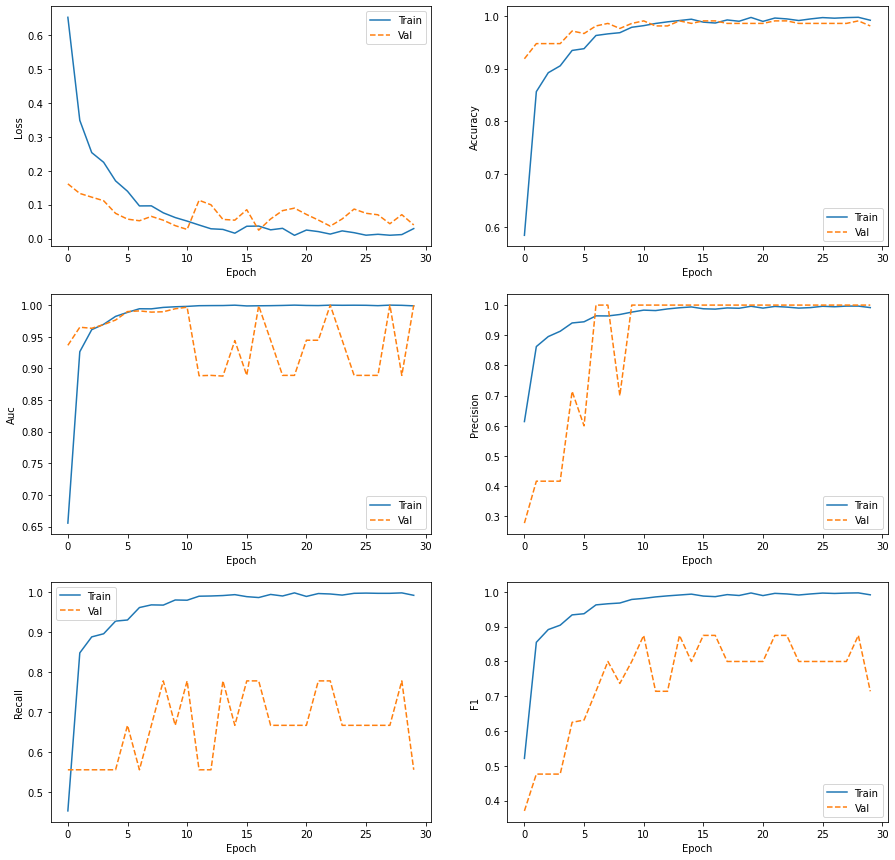

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.56      0.71         9

    accuracy                           0.98       209
   macro avg       0.99      0.78      0.85       209
weighted avg       0.98      0.98      0.98       209


Iteration 1


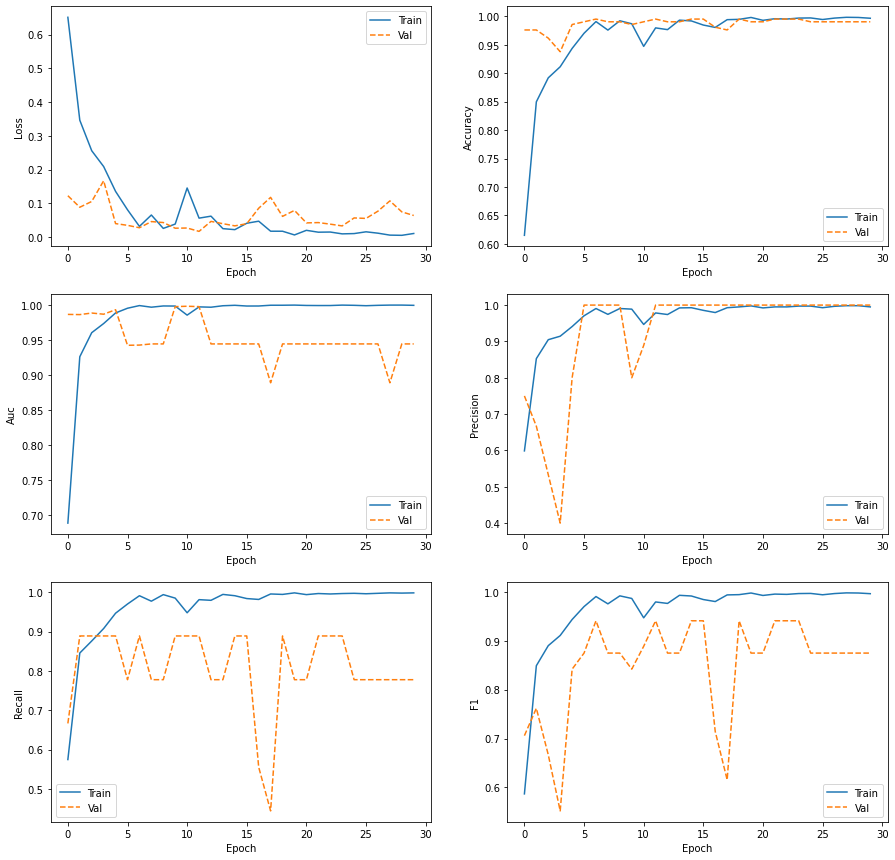

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 2


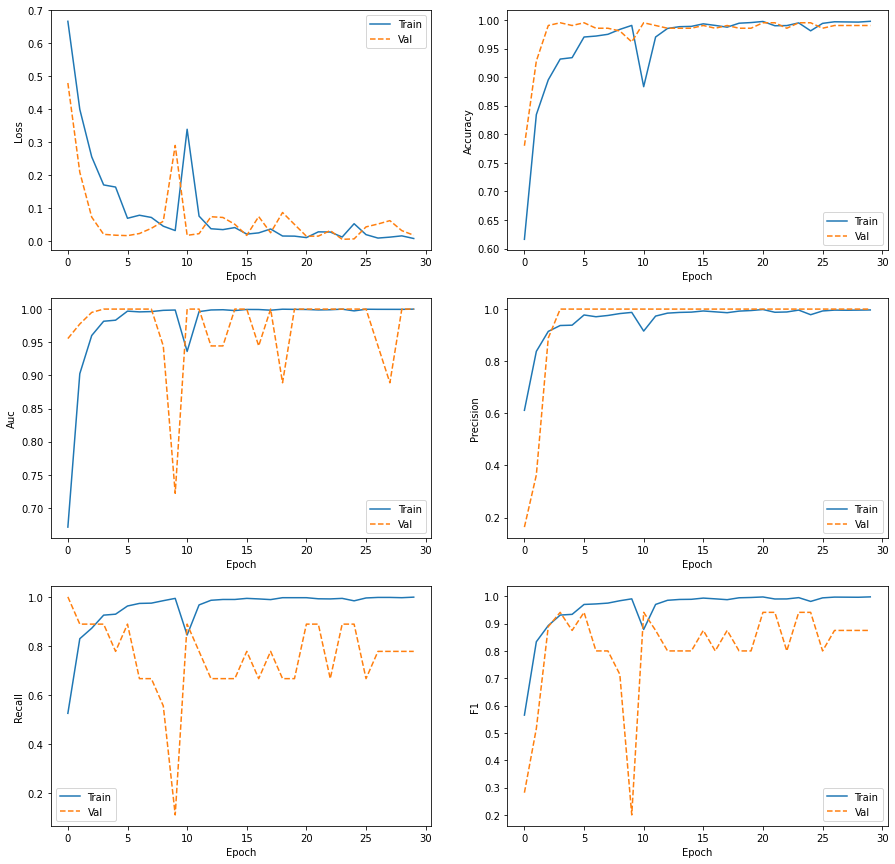

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 3


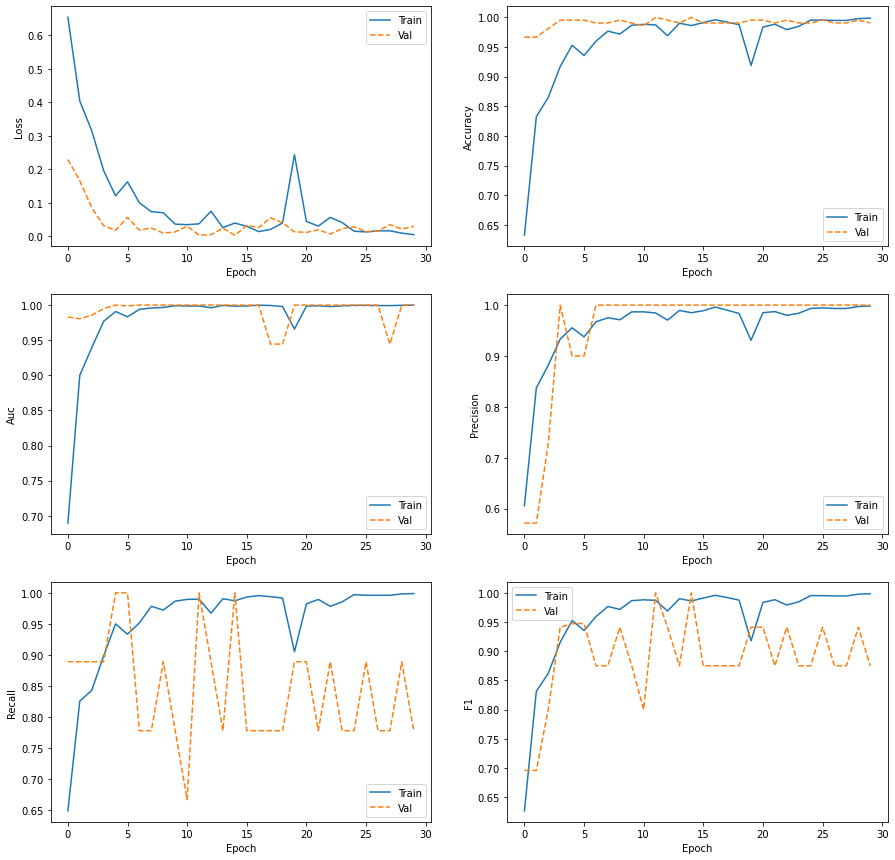

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 4


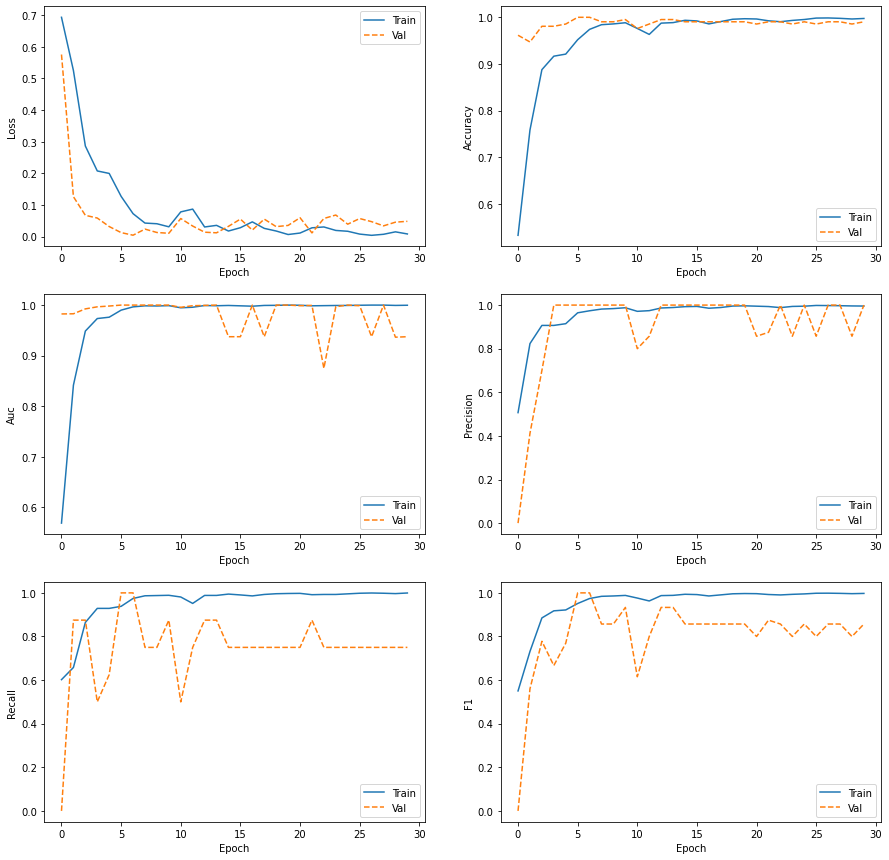

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 5


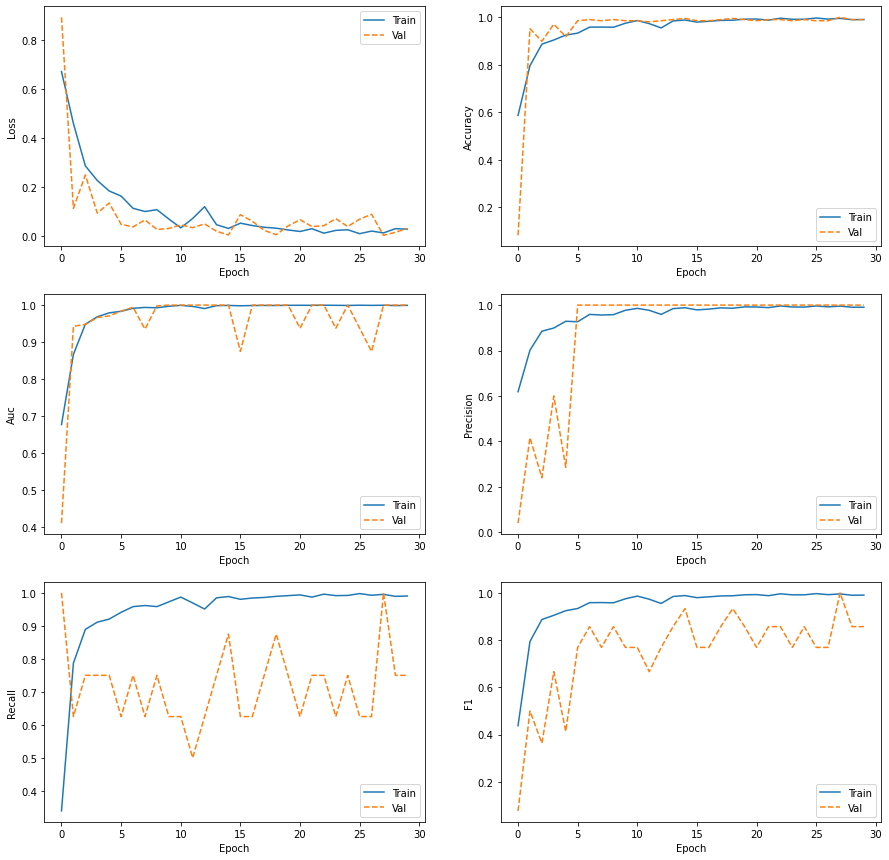

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 6


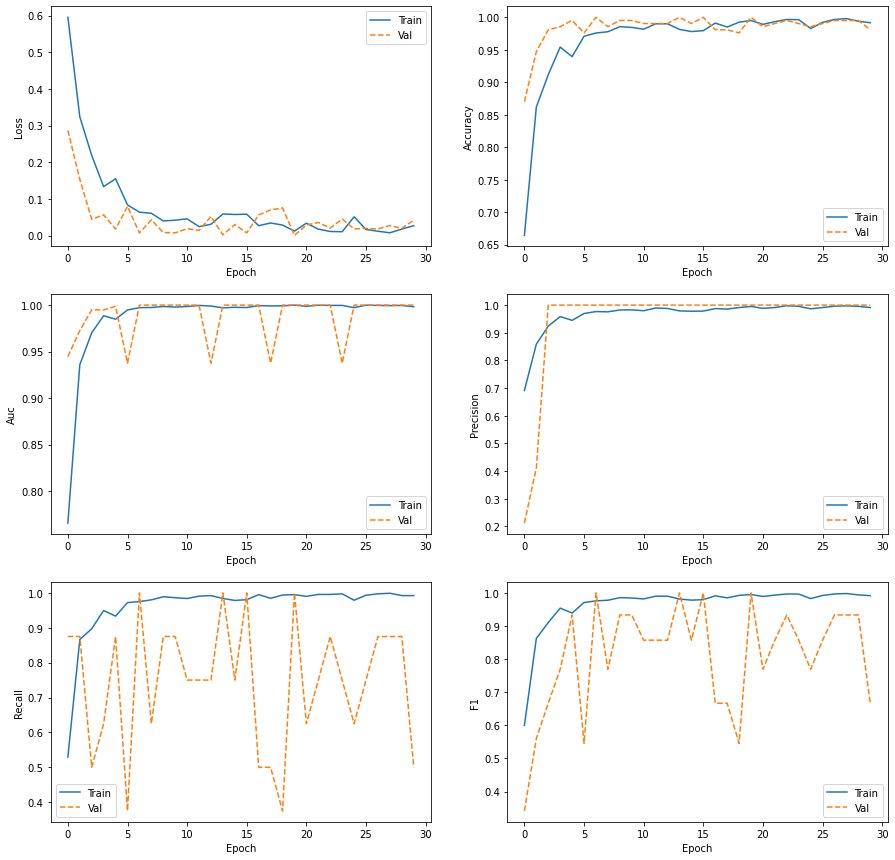

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 7


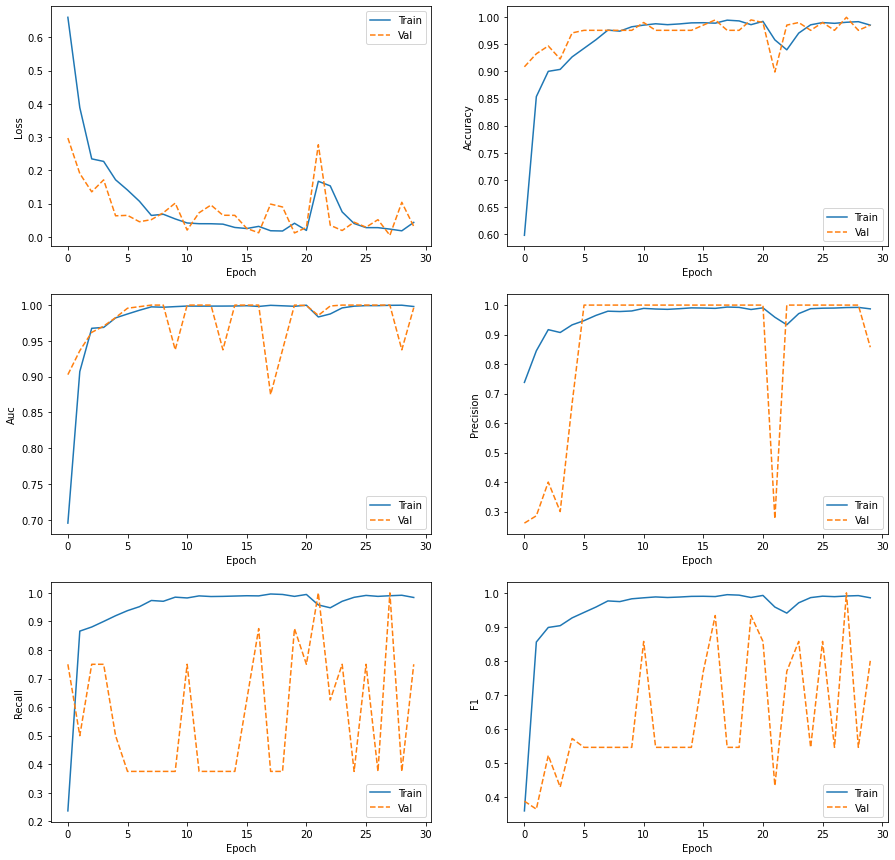

              precision    recall  f1-score   support

    No Covid       0.99      0.99      0.99       200
       Covid       0.86      0.75      0.80         8

    accuracy                           0.99       208
   macro avg       0.92      0.87      0.90       208
weighted avg       0.98      0.99      0.99       208


Iteration 8


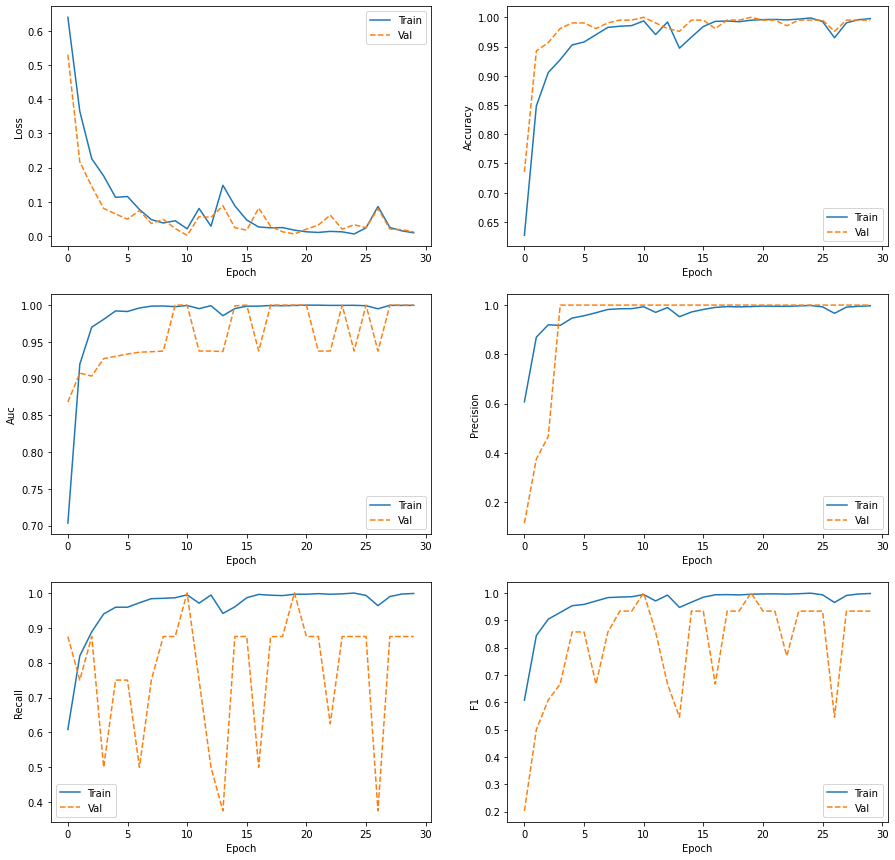

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


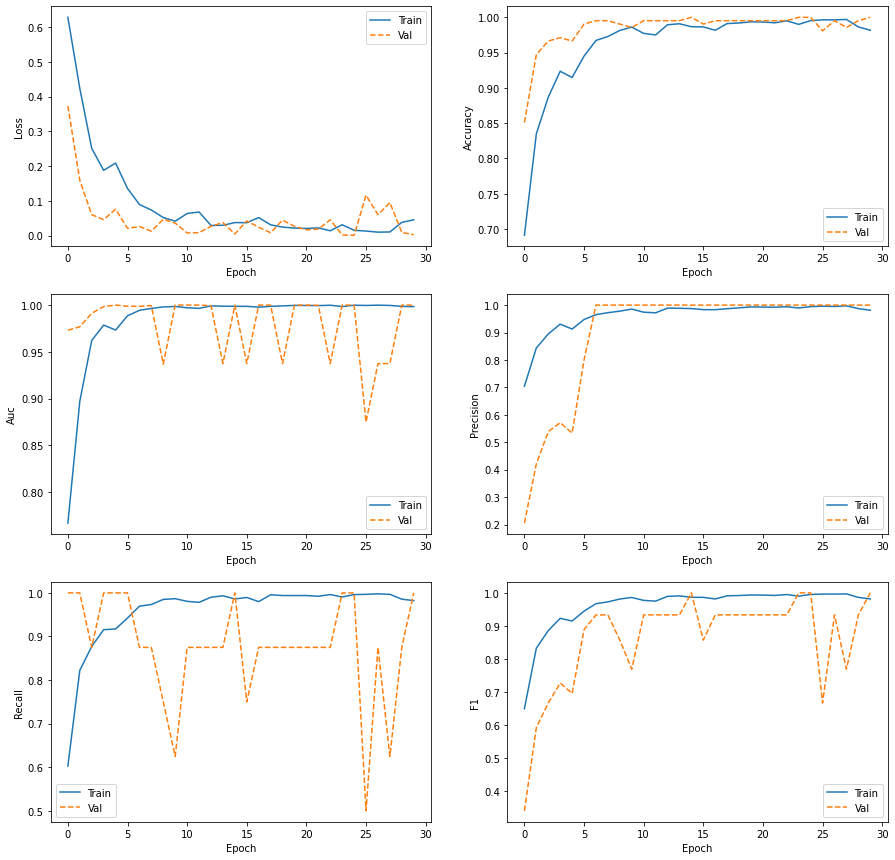

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1998    2]
 [  19   65]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99      2000
       Covid       0.97      0.77      0.86        84

    accuracy                           0.99      2084
   macro avg       0.98      0.89      0.93      2084
weighted avg       0.99      0.99      0.99      2084

['0:15:51.527862', '0:15:47.261640', '0:15:25.653367', '0:16:15.109640', '0:16:18.011718', '0:16:06.728346', '0:15:54.507322', '0:16:15.620602', '0:16:08.016266', '0:16:01.424403']


In [12]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

### model 65

In [13]:
model_number = 65
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [32, 64, 128,256,256,512], drop = 0.4 )
    add_dense(model, neurons = 256, n = 3 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 50s 2s/step - loss: 0.6887 - accuracy: 0.5410 - precision: 0.5549 - recall: 0.1676 - auc: 0.6013 - val_loss: 0.5235 - val_accuracy: 0.9426 - val_precision: 0.3636 - val_recall: 0.4444 - val_auc: 0.9606
Epoch 2/30
24/24 [==============================] - 49s 2s/step - loss: 0.4934 - accuracy: 0.8083 - precision: 0.8508 - recall: 0.7478 - auc: 0.8709 - val_loss: 0.1496 - val_accuracy: 0.9426 - val_precision: 0.3846 - val_recall: 0.5556 - val_auc: 0.9350
Epoch 3/30
24/24 [==============================] - 49s 2s/step - loss: 0.3110 - accuracy: 0.8744 - precision: 0.8851 - recall: 0.8606 - auc: 0.9406 - val_loss: 0.3246 - val_accuracy: 0.8852 - val_precision: 0.2000 - val_recall: 0.5556 - val_auc: 0.9294
Epoch 4/30
24/24 [==============================] - 48s 2s/step - loss: 0.20

Epoch 1/30
24/24 [==============================] - 50s 2s/step - loss: 0.6257 - accuracy: 0.6493 - precision: 0.7095 - recall: 0.4428 - auc: 0.7550 - val_loss: 0.1530 - val_accuracy: 0.9378 - val_precision: 0.4000 - val_recall: 0.8889 - val_auc: 0.9494
Epoch 2/30
24/24 [==============================] - 50s 2s/step - loss: 0.3512 - accuracy: 0.8606 - precision: 0.8598 - recall: 0.8617 - auc: 0.9244 - val_loss: 0.2240 - val_accuracy: 0.9282 - val_precision: 0.3636 - val_recall: 0.8889 - val_auc: 0.9703
Epoch 3/30
24/24 [==============================] - 49s 2s/step - loss: 0.2273 - accuracy: 0.9064 - precision: 0.9107 - recall: 0.9011 - auc: 0.9685 - val_loss: 0.0587 - val_accuracy: 0.9809 - val_precision: 0.7273 - val_recall: 0.8889 - val_auc: 0.9853
Epoch 4/30
24/24 [==============================] - 50s 2s/step - loss: 0.2338 - accuracy: 0.9017 - precision: 0.9003 - recall: 0.9033 - auc: 0.9668 - val_loss: 0.1069 - val_accuracy: 0.9522 - val_precision: 0.4706 - val_recall: 0.8889 - 

24/24 [==============================] - 50s 2s/step - loss: 0.6860 - accuracy: 0.5495 - precision: 0.5151 - recall: 0.8795 - auc: 0.6339 - val_loss: 0.6709 - val_accuracy: 0.8278 - val_precision: 0.1860 - val_recall: 0.8889 - val_auc: 0.9664
Epoch 2/30
24/24 [==============================] - 48s 2s/step - loss: 0.6674 - accuracy: 0.6086 - precision: 0.7064 - recall: 0.3717 - auc: 0.6674 - val_loss: 0.1820 - val_accuracy: 0.9474 - val_precision: 0.3750 - val_recall: 0.3333 - val_auc: 0.9539
Epoch 3/30
24/24 [==============================] - 49s 2s/step - loss: 0.3572 - accuracy: 0.8450 - precision: 0.8692 - recall: 0.8122 - auc: 0.9232 - val_loss: 0.0840 - val_accuracy: 0.9761 - val_precision: 0.6667 - val_recall: 0.8889 - val_auc: 0.9792
Epoch 4/30
24/24 [==============================] - 48s 2s/step - loss: 0.2635 - accuracy: 0.8836 - precision: 0.8868 - recall: 0.8794 - auc: 0.9576 - val_loss: 0.1510 - val_accuracy: 0.9234 - val_precision: 0.3478 - val_recall: 0.8889 - val_auc: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



FOLD: 0best epoch: 9F1 score: 0.8750000083819031
FOLD: 1best epoch: 10F1 score: 0.9411764743006353
FOLD: 2best epoch: 21F1 score: 1.0
FOLD: 3best epoch: 23F1 score: 1.0
FOLD: 4best epoch: 16F1 score: 1.0
FOLD: 5best epoch: 9F1 score: 1.0
FOLD: 6best epoch: 7F1 score: 1.0
FOLD: 7best epoch: 14F1 score: 0.9333333333333333
FOLD: 8best epoch: 23F1 score: 1.0
FOLD: 9best epoch: 7F1 score: 1.0
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.

Iteratio

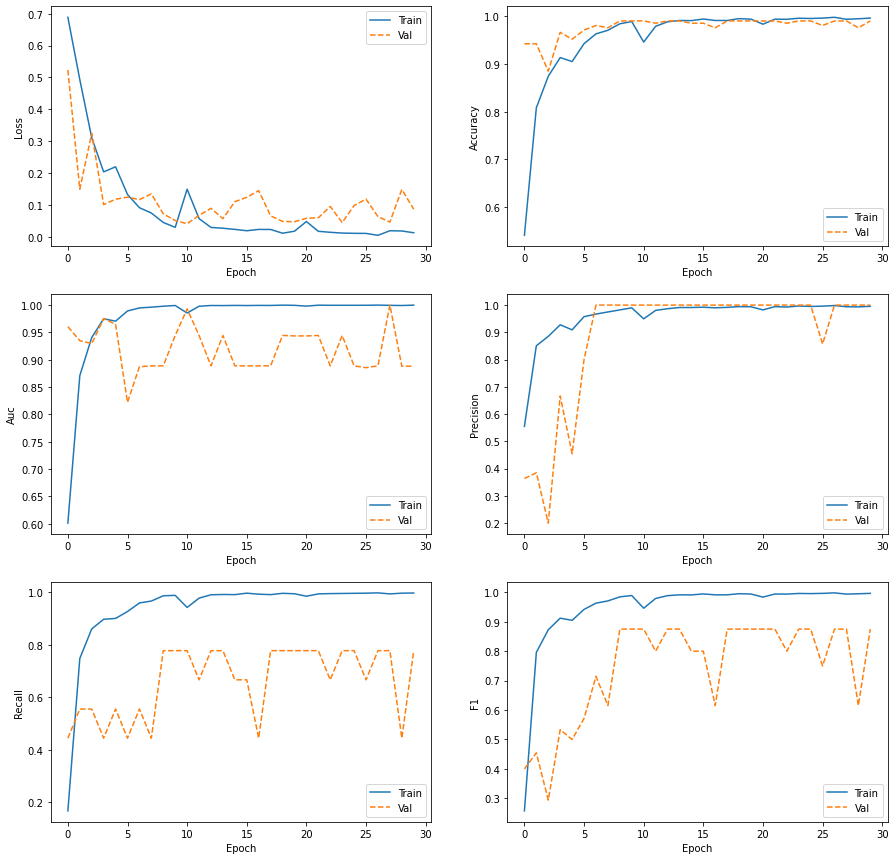

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 1


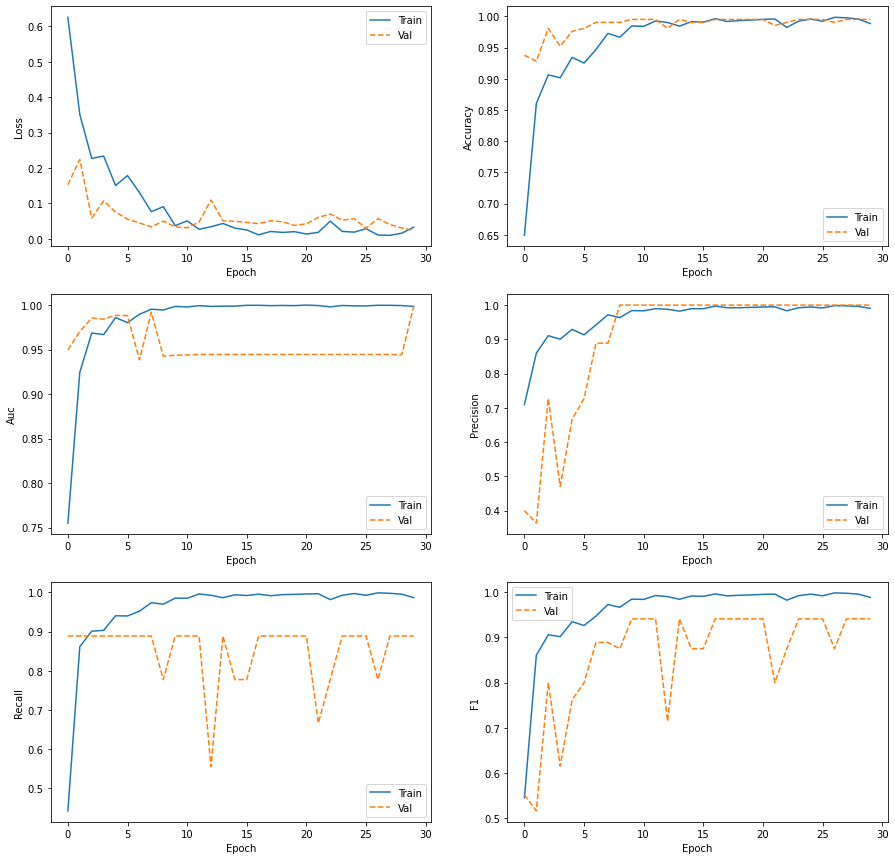

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


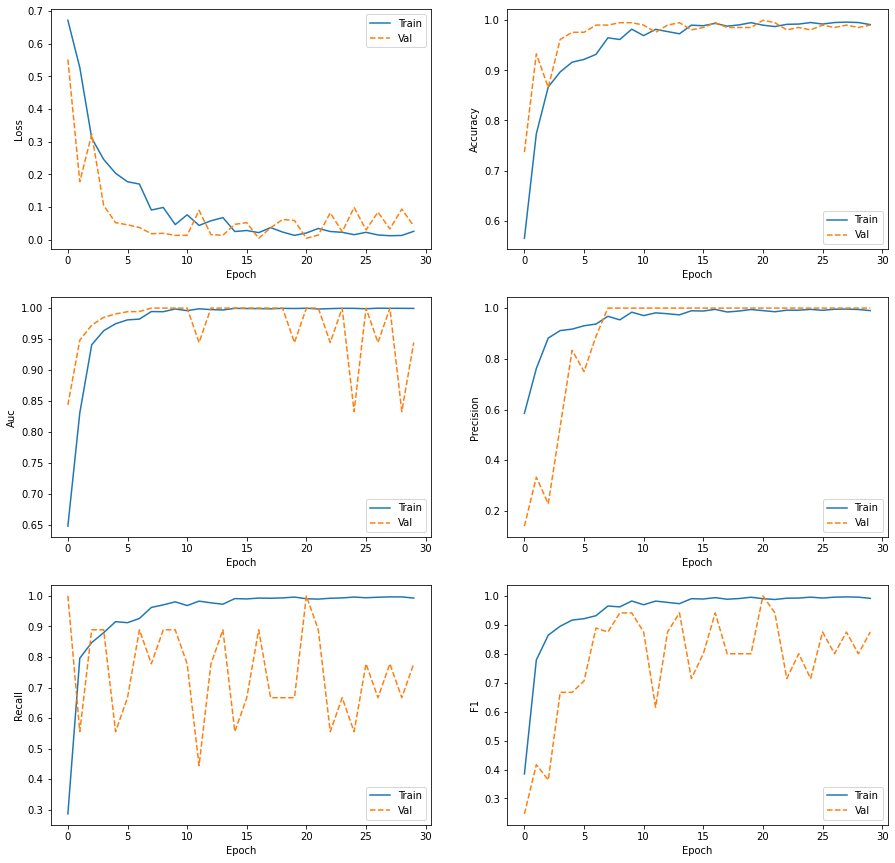

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 3


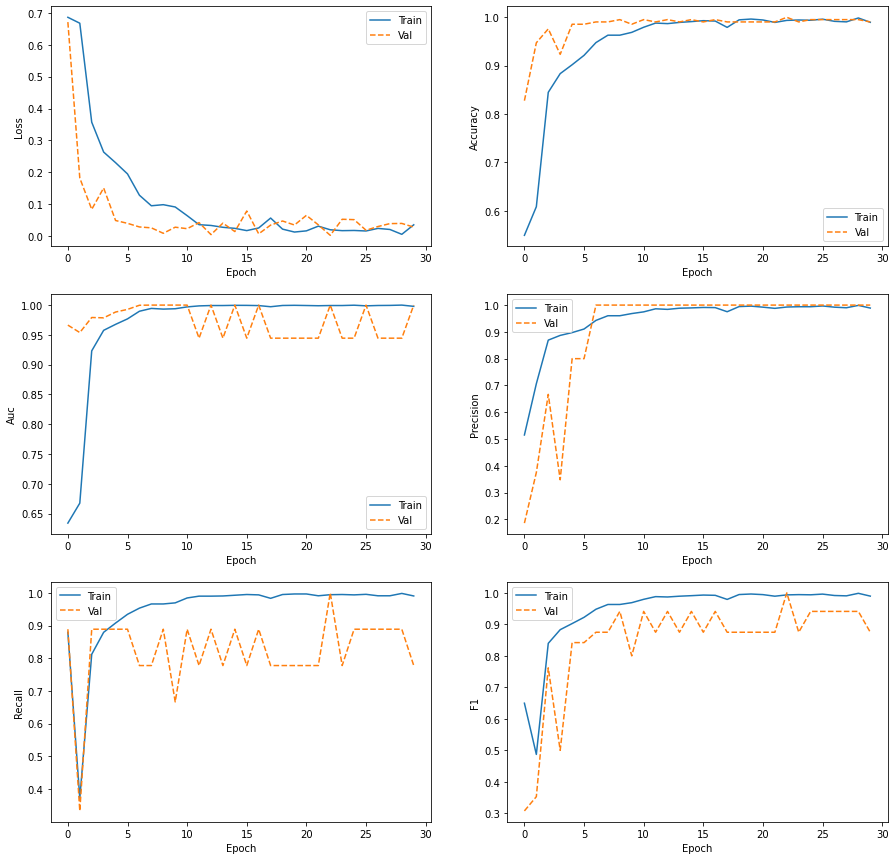

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 4


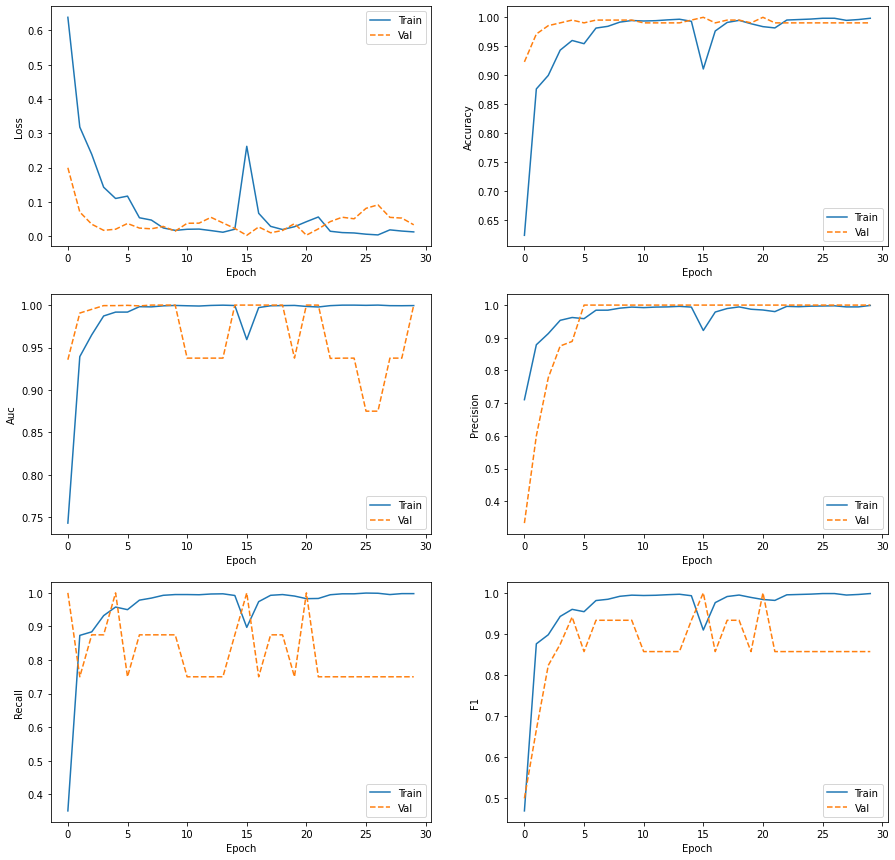

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 5


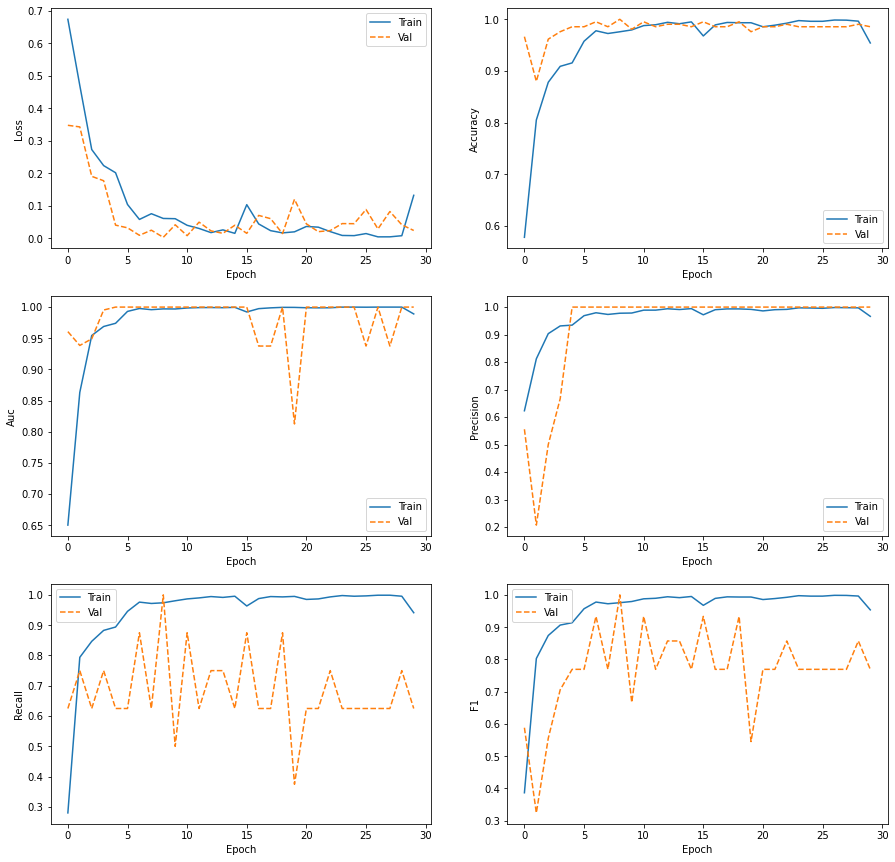

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.62      0.77         8

    accuracy                           0.99       208
   macro avg       0.99      0.81      0.88       208
weighted avg       0.99      0.99      0.98       208


Iteration 6


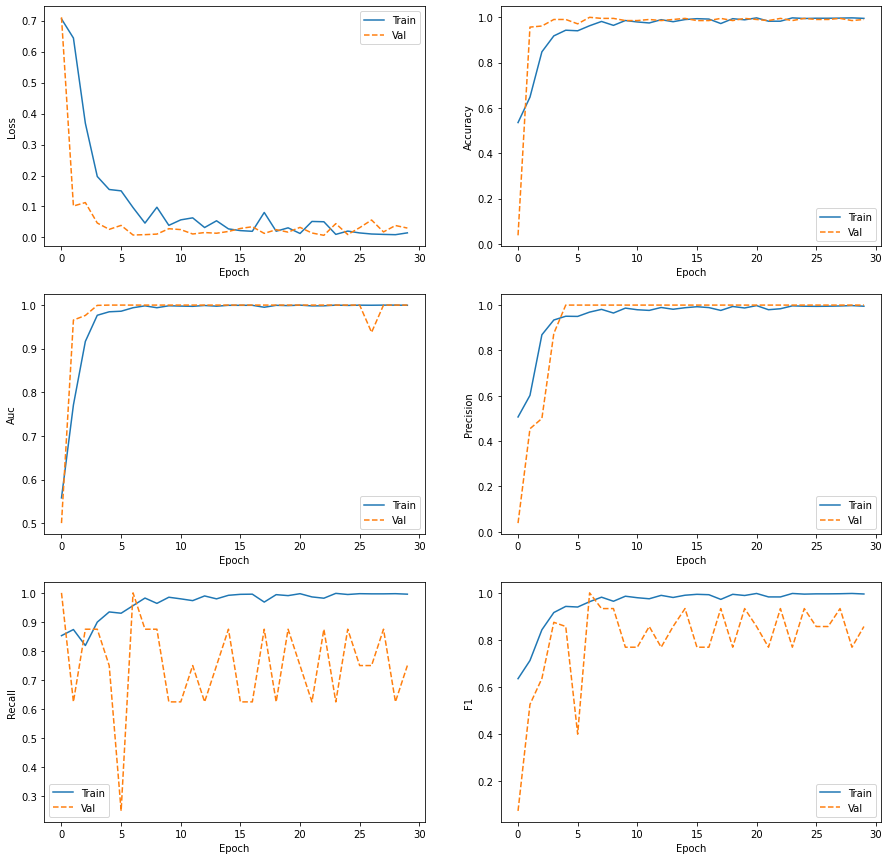

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 7


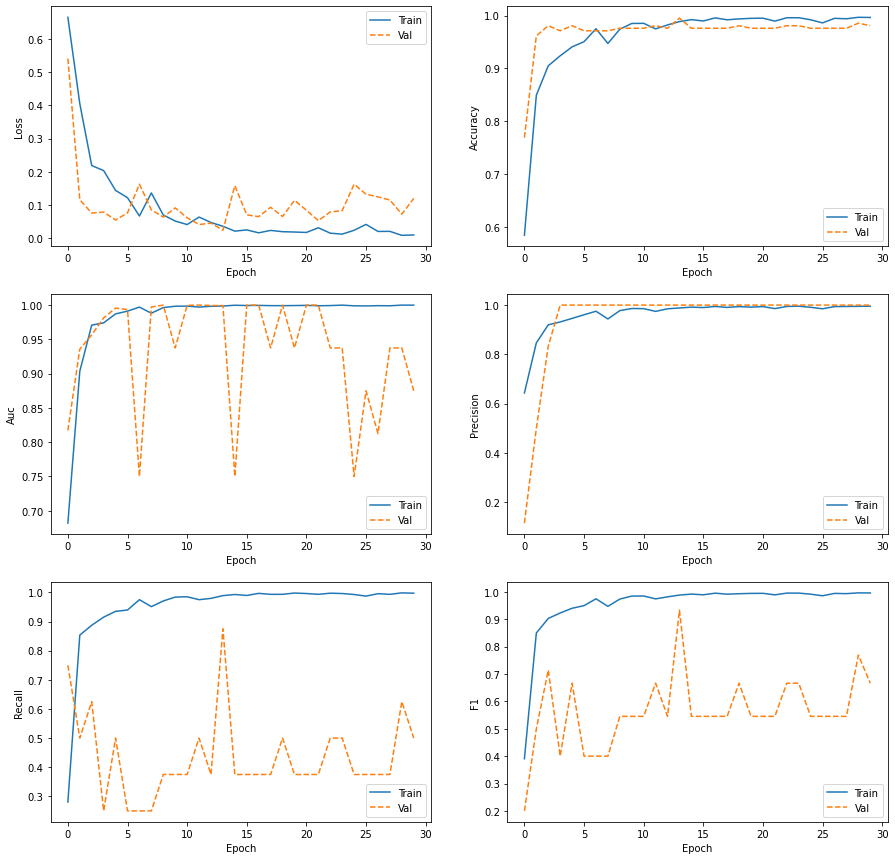

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 8


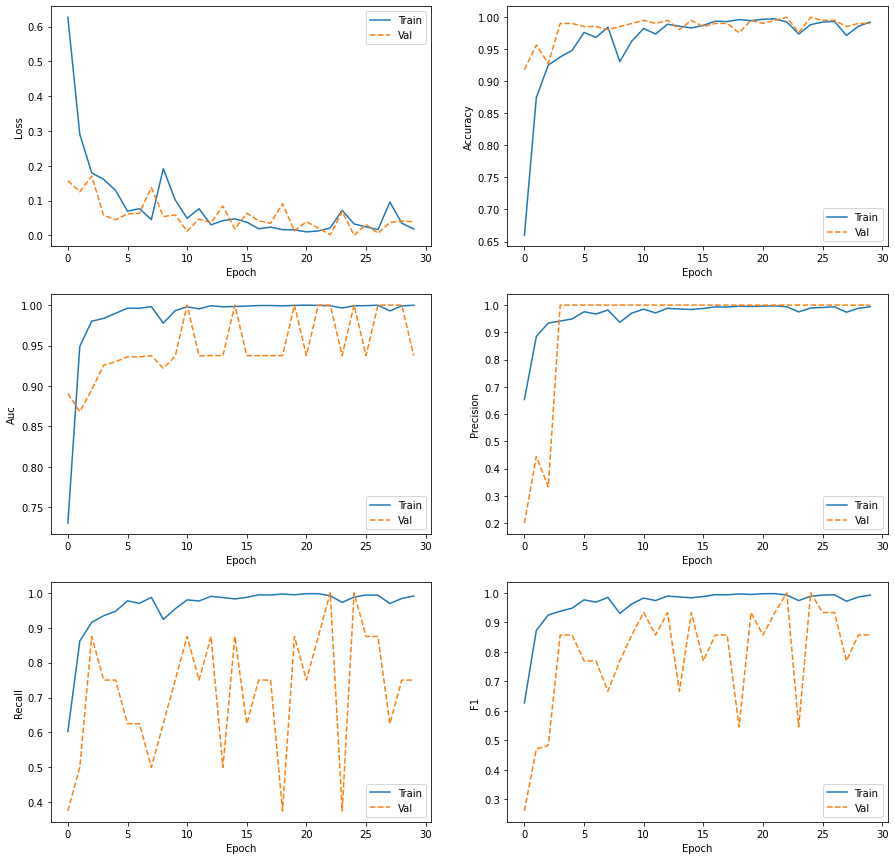

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 9


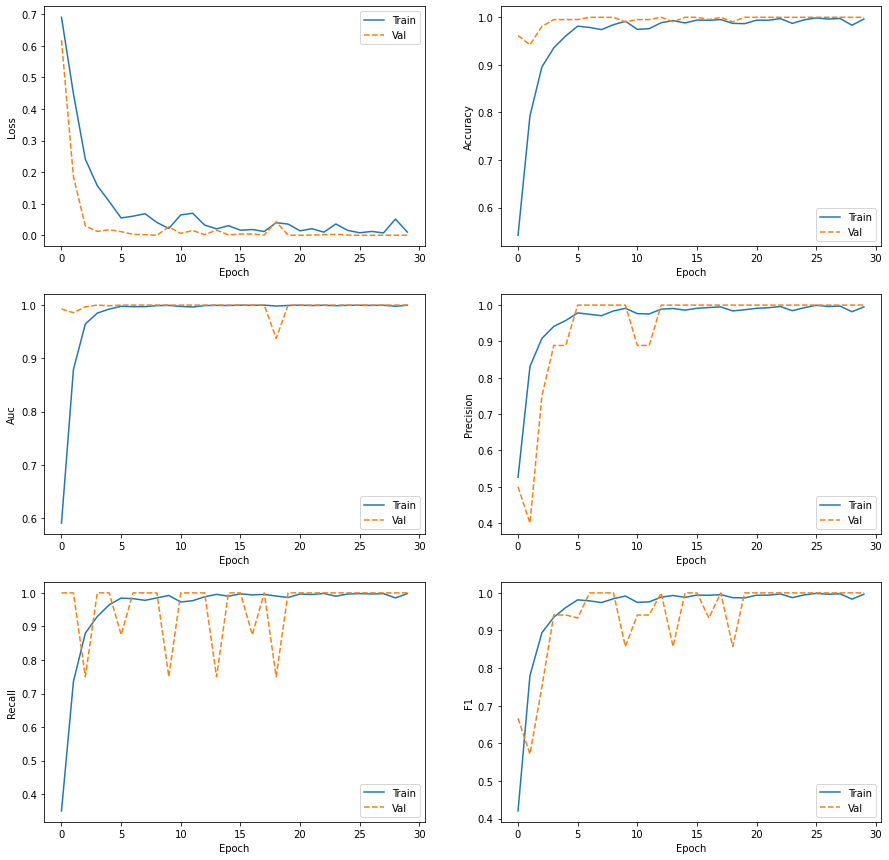

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1999    1]
 [  24   60]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99      2000
       Covid       0.98      0.71      0.83        84

    accuracy                           0.99      2084
   macro avg       0.99      0.86      0.91      2084
weighted avg       0.99      0.99      0.99      2084

['0:28:30.746474', '0:28:32.052664', '0:28:09.560142', '0:28:33.398264', '0:28:47.031713', '0:28:35.124702', '0:28:22.045033', '0:28:38.539234', '0:28:44.266840', '0:28:38.102007']


In [14]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

### model 66

In [ ]:
model_number = 66
k = 10
number_of_its = 10
epochs = 30

class_weight = {0: 1, 1: 1.5}


kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)
    model = build_model()
    add_cnl(model,neurons = [16, 32, 64, 128], drop = 0.3 )
    add_dense(model, neurons = 256, n = 2, reg = reg.l2(0.001) )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]], class_weight=class_weight)
    histories.append(history.history)
    json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 1.2579 - accuracy: 0.5650 - precision: 0.5386 - recall: 0.9072 - auc: 0.6422 - val_loss: 0.9742 - val_accuracy: 0.5646 - val_precision: 0.0900 - val_recall: 1.0000 - val_auc: 0.9367
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 0.6787 - accuracy: 0.8239 - precision: 0.8021 - recall: 0.8600 - auc: 0.9077 - val_loss: 0.4037 - val_accuracy: 0.9187 - val_precision: 0.2778 - val_recall: 0.5556 - val_auc: 0.9347
Epoch 3/30
 4/24 [====>.........................] - ETA: 13s - loss: 0.4472 - accuracy: 0.9017 - precision: 0.8957 - recall: 0.8925 - auc: 0.9665

In [ ]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

In [ ]:
model_number = 67
k = 10
number_of_its = 10
epochs = 30

class_weight = {0: 1, 1: 1.5}


kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)
    model = build_model()
    add_cnl(model,neurons = [16, 32, 64, 128], drop = 0.3 )
    add_dense(model, neurons = 256, n = 2, reg = reg.l2(0.001) )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]], class_weight=class_weight)
    histories.append(history.history)
    json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

In [ ]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

### model 70

In [19]:
model_number = 70
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4, pooling="average" )
    add_dense(model, neurons = 256, n = 3 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 24s 1s/step - loss: 0.5851 - accuracy: 0.6841 - precision: 0.6491 - recall: 0.7284 - auc: 0.7775 - val_loss: 0.2426 - val_accuracy: 0.9187 - val_precision: 0.2778 - val_recall: 0.5556 - val_auc: 0.8975
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 0.3736 - accuracy: 0.8428 - precision: 0.8655 - recall: 0.8117 - auc: 0.9146 - val_loss: 0.4117 - val_accuracy: 0.8278 - val_precision: 0.1351 - val_recall: 0.5556 - val_auc: 0.8750
Epoch 3/30
24/24 [==============================] - 22s 925ms/step - loss: 0.2910 - accuracy: 0.8797 - precision: 0.9004 - recall: 0.8539 - auc: 0.9482 - val_loss: 0.3511 - val_accuracy: 0.8947 - val_precision: 0.2593 - val_recall: 0.7778 - val_auc: 0.9417
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0

Epoch 1/30
24/24 [==============================] - 24s 1s/step - loss: 0.6020 - accuracy: 0.6752 - precision: 0.6375 - recall: 0.7330 - auc: 0.7628 - val_loss: 0.3356 - val_accuracy: 0.8660 - val_precision: 0.2432 - val_recall: 1.0000 - val_auc: 0.9633
Epoch 2/30
24/24 [==============================] - 26s 1s/step - loss: 0.3921 - accuracy: 0.8331 - precision: 0.8389 - recall: 0.8244 - auc: 0.9054 - val_loss: 0.3552 - val_accuracy: 0.8230 - val_precision: 0.1957 - val_recall: 1.0000 - val_auc: 0.9750
Epoch 3/30
24/24 [==============================] - 24s 992ms/step - loss: 0.2783 - accuracy: 0.8889 - precision: 0.8933 - recall: 0.8833 - auc: 0.9530 - val_loss: 0.0581 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9886
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.1860 - accuracy: 0.9283 - precision: 0.9381 - recall: 0.9172 - auc: 0.9788 - val_loss: 0.0344 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6588 - accuracy: 0.6401 - precision: 0.6746 - recall: 0.4677 - auc: 0.7087 - val_loss: 0.6095 - val_accuracy: 0.7033 - val_precision: 0.1159 - val_recall: 0.8889 - val_auc: 0.9181
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 0.4406 - accuracy: 0.7992 - precision: 0.8068 - recall: 0.7867 - auc: 0.8784 - val_loss: 0.2824 - val_accuracy: 0.8708 - val_precision: 0.2353 - val_recall: 0.8889 - val_auc: 0.9408
Epoch 3/30
24/24 [==============================] - 23s 964ms/step - loss: 0.3114 - accuracy: 0.8678 - precision: 0.8736 - recall: 0.8600 - auc: 0.9410 - val_loss: 0.1767 - val_accuracy: 0.9282 - val_precision: 0.3636 - val_recall: 0.8889 - val_auc: 0.9753
Epoch 4/30
24/24 [==============================] - 23s 978ms/step - loss: 0.2375 - accuracy: 0.9000 - precision: 0.9063 - recall: 0.8922 - auc: 0.9657 - val_loss: 0.0355 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6304 - accuracy: 0.6377 - precision: 0.6364 - recall: 0.5533 - auc: 0.7160 - val_loss: 0.3115 - val_accuracy: 0.8756 - val_precision: 0.2424 - val_recall: 0.8889 - val_auc: 0.9336
Epoch 2/30
24/24 [==============================] - 22s 931ms/step - loss: 0.4089 - accuracy: 0.8167 - precision: 0.8235 - recall: 0.8061 - auc: 0.8958 - val_loss: 0.1775 - val_accuracy: 0.9330 - val_precision: 0.3810 - val_recall: 0.8889 - val_auc: 0.9783
Epoch 3/30
24/24 [==============================] - 25s 1s/step - loss: 0.2678 - accuracy: 0.8883 - precision: 0.9031 - recall: 0.8700 - auc: 0.9565 - val_loss: 0.0746 - val_accuracy: 0.9809 - val_precision: 0.7273 - val_recall: 0.8889 - val_auc: 0.9875
Epoch 4/30
24/24 [==============================] - 24s 1000ms/step - loss: 0.1436 - accuracy: 0.9411 - precision: 0.9426 - recall: 0.9394 - auc: 0.9874 - val_loss: 0.0257 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6436 - accuracy: 0.6317 - precision: 0.5983 - recall: 0.6833 - auc: 0.7082 - val_loss: 0.4849 - val_accuracy: 0.7981 - val_precision: 0.1304 - val_recall: 0.7500 - val_auc: 0.9119
Epoch 2/30
24/24 [==============================] - 24s 979ms/step - loss: 0.4335 - accuracy: 0.8053 - precision: 0.8127 - recall: 0.7933 - auc: 0.8810 - val_loss: 0.2417 - val_accuracy: 0.9135 - val_precision: 0.3077 - val_recall: 1.0000 - val_auc: 0.9859
Epoch 3/30
24/24 [==============================] - 26s 1s/step - loss: 0.3035 - accuracy: 0.8708 - precision: 0.8834 - recall: 0.8544 - auc: 0.9443 - val_loss: 0.0431 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 4/30
24/24 [==============================] - 24s 995ms/step - loss: 0.1893 - accuracy: 0.9217 - precision: 0.9308 - recall: 0.9111 - auc: 0.9787 - val_loss: 0.0046 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6725 - accuracy: 0.6253 - precision: 0.5927 - recall: 0.6737 - auc: 0.6913 - val_loss: 0.8539 - val_accuracy: 0.4904 - val_precision: 0.0702 - val_recall: 1.0000 - val_auc: 0.8994
Epoch 2/30
24/24 [==============================] - 26s 1s/step - loss: 0.5559 - accuracy: 0.7208 - precision: 0.8490 - recall: 0.5372 - auc: 0.8379 - val_loss: 0.5317 - val_accuracy: 0.7356 - val_precision: 0.1148 - val_recall: 0.8750 - val_auc: 0.9144
Epoch 3/30
24/24 [==============================] - 23s 966ms/step - loss: 0.3298 - accuracy: 0.8606 - precision: 0.8562 - recall: 0.8667 - auc: 0.9344 - val_loss: 0.2724 - val_accuracy: 0.8750 - val_precision: 0.2188 - val_recall: 0.8750 - val_auc: 0.9581
Epoch 4/30
24/24 [==============================] - 23s 951ms/step - loss: 0.2618 - accuracy: 0.8967 - precision: 0.9016 - recall: 0.8906 - auc: 0.9577 - val_loss: 0.0575 - val_accuracy: 0.9808 - val_precision: 0.7000 - val_recall: 0.8

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6517 - accuracy: 0.6665 - precision: 0.6269 - recall: 0.7351 - auc: 0.7398 - val_loss: 0.2485 - val_accuracy: 0.9615 - val_precision: 0.5000 - val_recall: 0.1250 - val_auc: 0.9412
Epoch 2/30
24/24 [==============================] - 23s 977ms/step - loss: 0.5566 - accuracy: 0.7497 - precision: 0.7170 - recall: 0.8250 - auc: 0.8241 - val_loss: 0.2842 - val_accuracy: 0.8942 - val_precision: 0.2083 - val_recall: 0.6250 - val_auc: 0.9044
Epoch 3/30
24/24 [==============================] - 23s 971ms/step - loss: 0.3590 - accuracy: 0.8442 - precision: 0.8522 - recall: 0.8328 - auc: 0.9225 - val_loss: 0.0758 - val_accuracy: 0.9856 - val_precision: 0.8571 - val_recall: 0.7500 - val_auc: 0.9887
Epoch 4/30
24/24 [==============================] - 22s 927ms/step - loss: 0.2472 - accuracy: 0.9003 - precision: 0.9068 - recall: 0.8922 - auc: 0.9629 - val_loss: 0.0646 - val_accuracy: 0.9712 - val_precision: 1.0000 - val_recall: 

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6016 - accuracy: 0.6620 - precision: 0.6014 - recall: 0.8545 - auc: 0.7640 - val_loss: 0.5481 - val_accuracy: 0.7500 - val_precision: 0.1207 - val_recall: 0.8750 - val_auc: 0.8869
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 0.3306 - accuracy: 0.8628 - precision: 0.8677 - recall: 0.8561 - auc: 0.9332 - val_loss: 0.2833 - val_accuracy: 0.8654 - val_precision: 0.1875 - val_recall: 0.7500 - val_auc: 0.9284
Epoch 3/30
24/24 [==============================] - 26s 1s/step - loss: 0.2695 - accuracy: 0.8942 - precision: 0.8970 - recall: 0.8906 - auc: 0.9552 - val_loss: 0.0777 - val_accuracy: 0.9663 - val_precision: 0.5455 - val_recall: 0.7500 - val_auc: 0.9794
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0.1550 - accuracy: 0.9392 - precision: 0.9424 - recall: 0.9356 - auc: 0.9849 - val_loss: 0.0371 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - 

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6155 - accuracy: 0.6536 - precision: 0.6204 - recall: 0.6969 - auc: 0.7379 - val_loss: 0.2074 - val_accuracy: 0.9423 - val_precision: 0.3333 - val_recall: 0.5000 - val_auc: 0.8587
Epoch 2/30
24/24 [==============================] - 24s 995ms/step - loss: 0.3986 - accuracy: 0.8269 - precision: 0.8293 - recall: 0.8233 - auc: 0.9008 - val_loss: 0.2226 - val_accuracy: 0.8798 - val_precision: 0.1852 - val_recall: 0.6250 - val_auc: 0.8906
Epoch 3/30
24/24 [==============================] - 24s 994ms/step - loss: 0.3004 - accuracy: 0.8697 - precision: 0.8758 - recall: 0.8617 - auc: 0.9456 - val_loss: 0.1307 - val_accuracy: 0.9615 - val_precision: 0.5000 - val_recall: 0.7500 - val_auc: 0.9397
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.1875 - accuracy: 0.9231 - precision: 0.9329 - recall: 0.9117 - auc: 0.9788 - val_loss: 0.0270 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7

Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 0.6549 - accuracy: 0.6239 - precision: 0.5901 - recall: 0.6809 - auc: 0.6951 - val_loss: 0.5456 - val_accuracy: 0.7692 - val_precision: 0.1429 - val_recall: 1.0000 - val_auc: 0.9384
Epoch 2/30
24/24 [==============================] - 24s 992ms/step - loss: 0.4720 - accuracy: 0.7828 - precision: 0.7991 - recall: 0.7556 - auc: 0.8573 - val_loss: 0.3466 - val_accuracy: 0.8413 - val_precision: 0.1795 - val_recall: 0.8750 - val_auc: 0.9688
Epoch 3/30
24/24 [==============================] - 23s 943ms/step - loss: 0.3263 - accuracy: 0.8572 - precision: 0.8564 - recall: 0.8583 - auc: 0.9346 - val_loss: 0.0634 - val_accuracy: 0.9904 - val_precision: 0.8750 - val_recall: 0.8750 - val_auc: 0.9969
Epoch 4/30
24/24 [==============================] - 24s 982ms/step - loss: 0.2407 - accuracy: 0.9058 - precision: 0.9340 - recall: 0.8733 - auc: 0.9647 - val_loss: 0.0356 - val_accuracy: 0.9952 - val_precision: 0.8889 - val_recall: 

FOLD: 0best epoch: 30F1 score: 0.8421052727342643
FOLD: 1best epoch: 14F1 score: 0.9411764743006353
FOLD: 2best epoch: 23F1 score: 0.9473684078438459
FOLD: 3best epoch: 5F1 score: 0.9411764743006353
FOLD: 4best epoch: 8F1 score: 1.0
FOLD: 5best epoch: 19F1 score: 1.0
FOLD: 6best epoch: 17F1 score: 0.9333333333333333
FOLD: 7best epoch: 19F1 score: 0.9333333333333333
FOLD: 8best epoch: 21F1 score: 0.9333333333333333
FOLD: 9best epoch: 7F1 score: 1.0
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 20

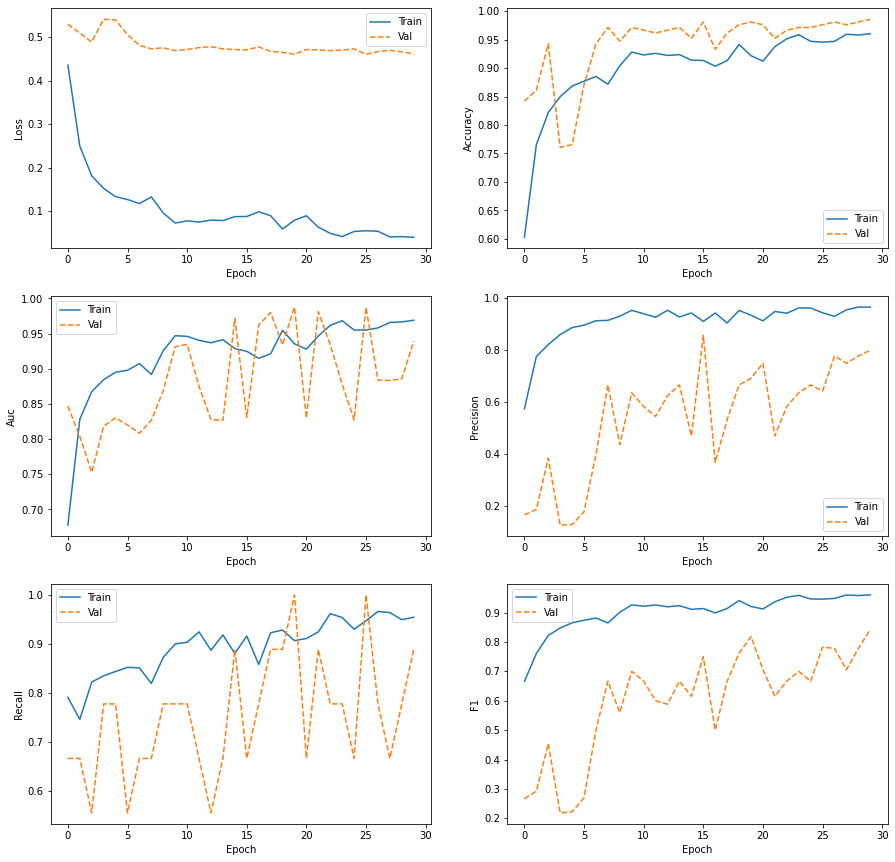

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 1


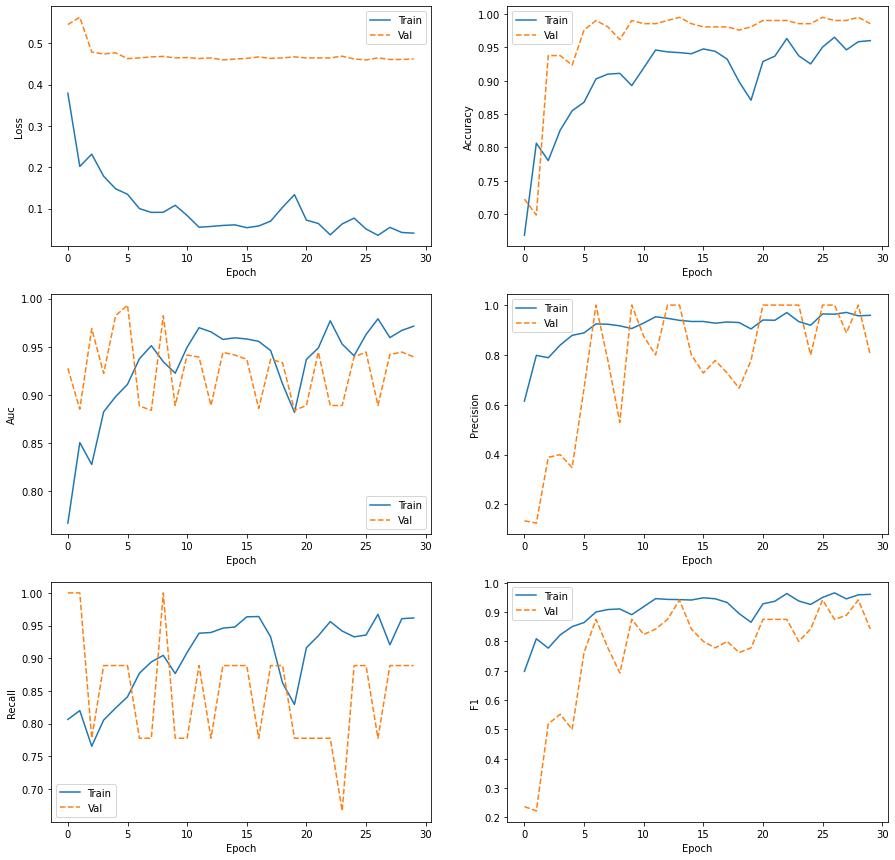

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


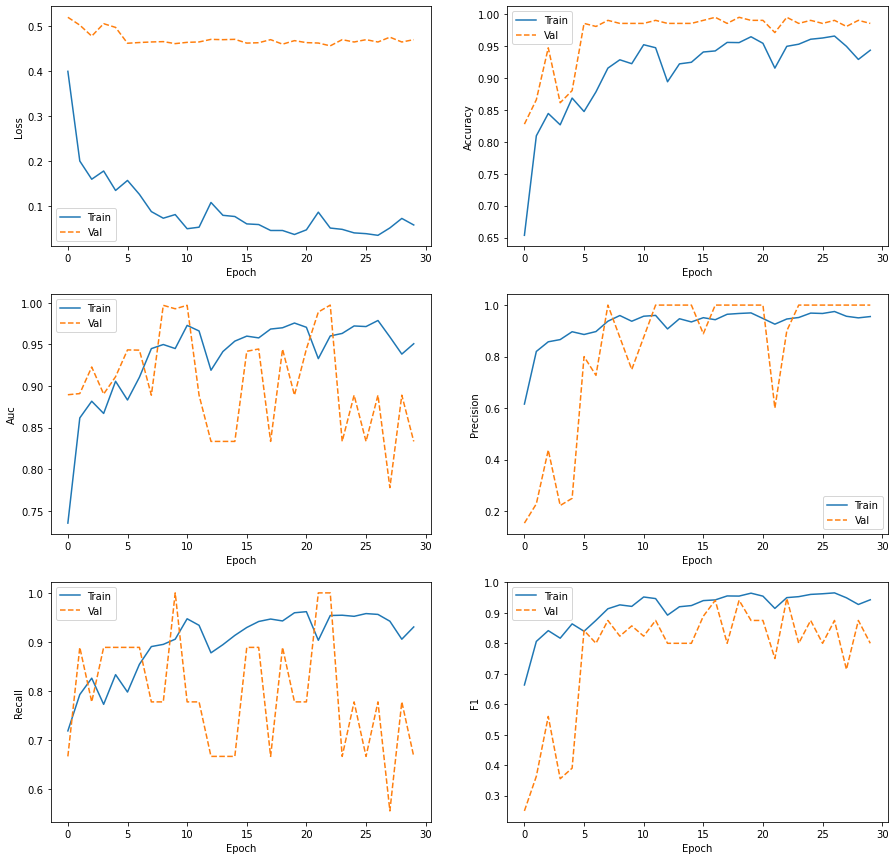

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 3


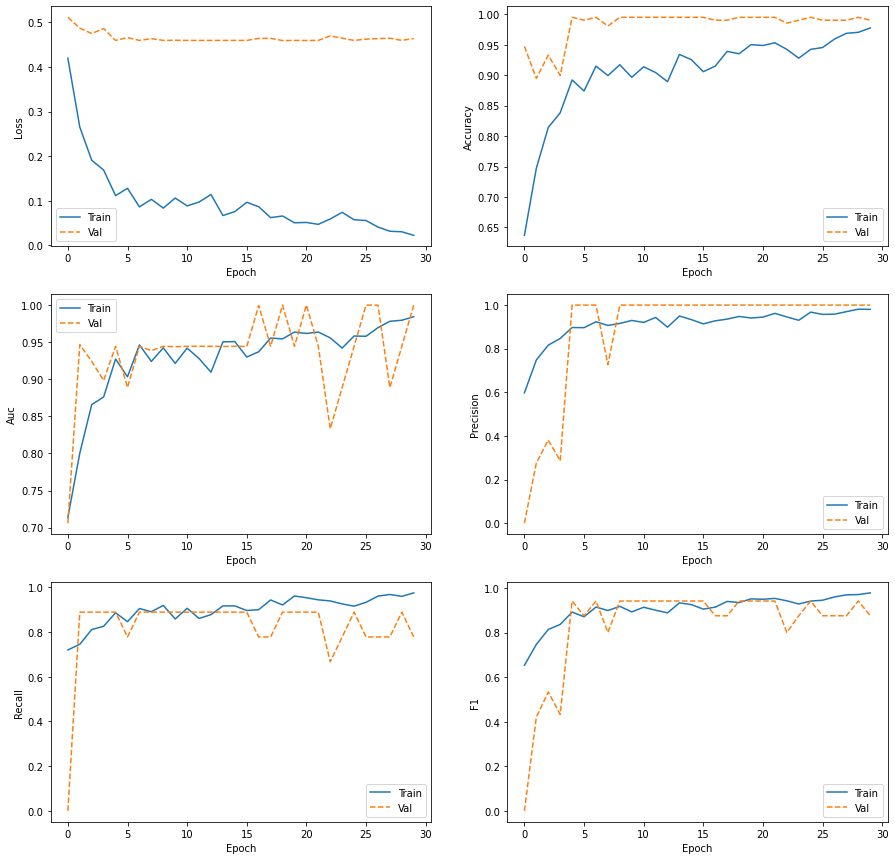

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 4


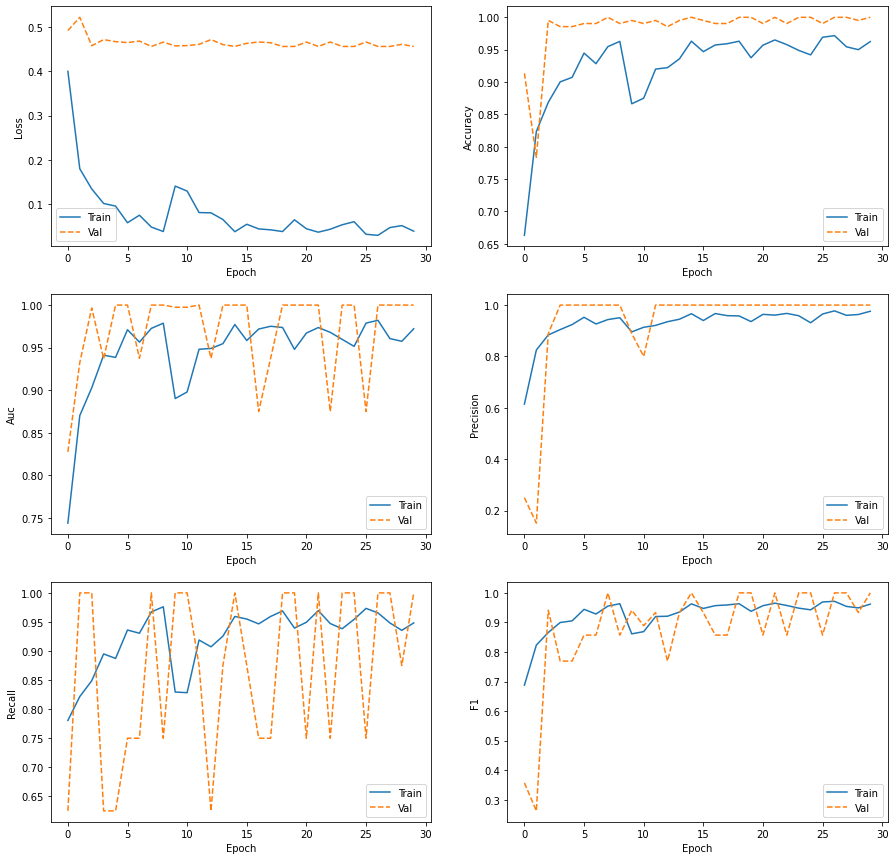

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 5


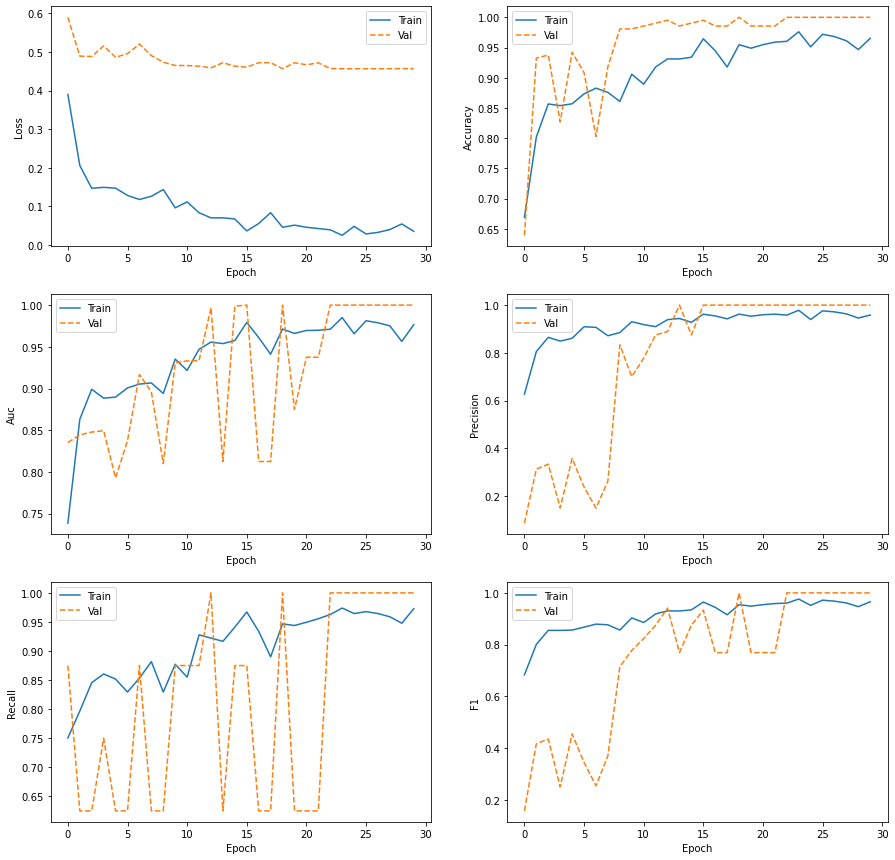

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 6


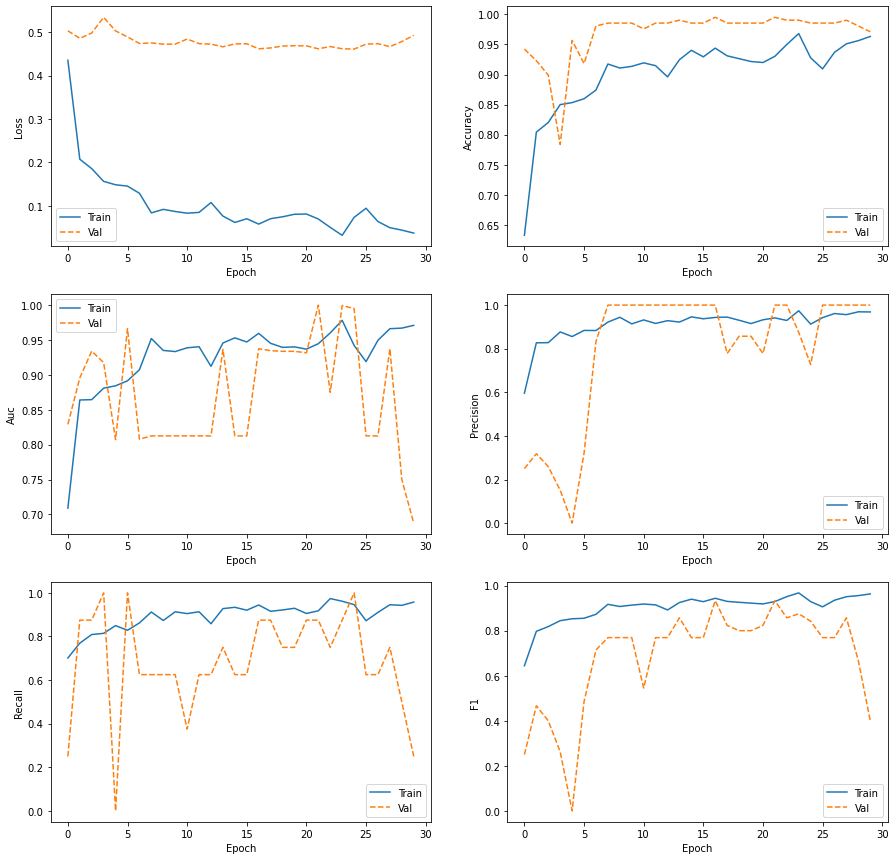

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.62      0.77         8

    accuracy                           0.99       208
   macro avg       0.99      0.81      0.88       208
weighted avg       0.99      0.99      0.98       208


Iteration 7


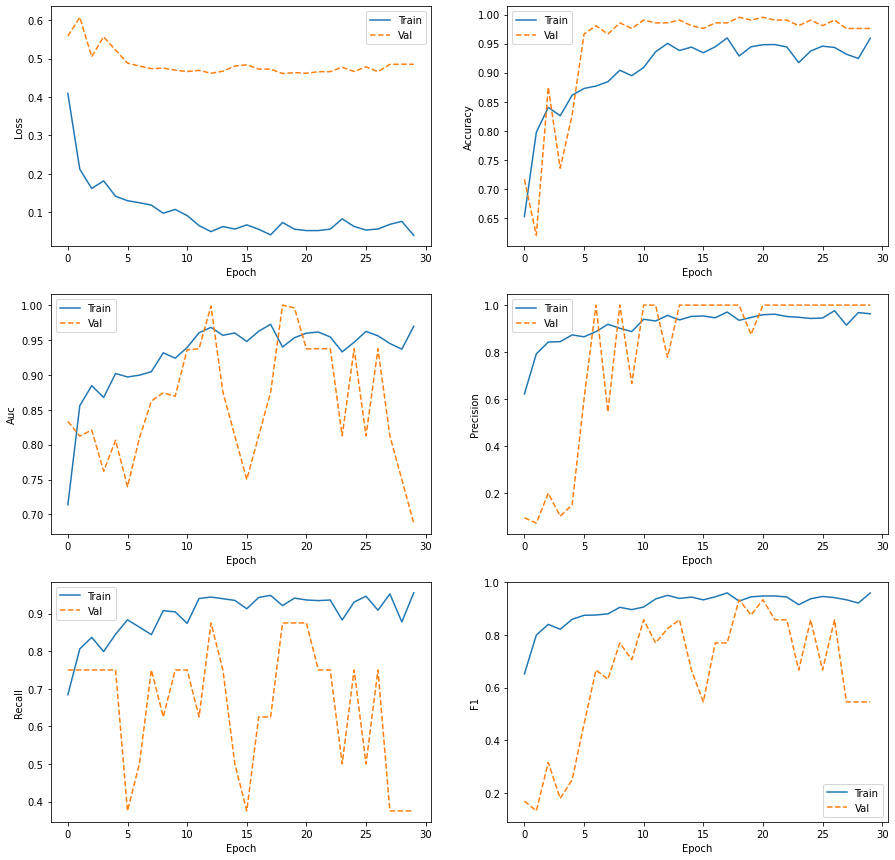

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.62      0.77         8

    accuracy                           0.99       208
   macro avg       0.99      0.81      0.88       208
weighted avg       0.99      0.99      0.98       208


Iteration 8


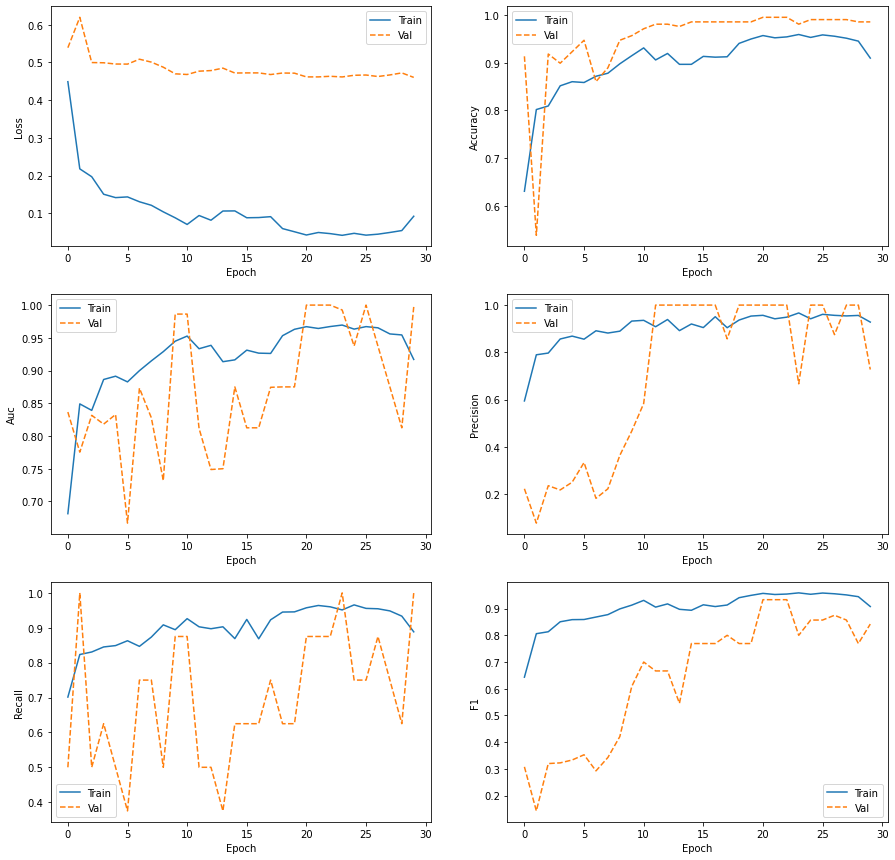

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


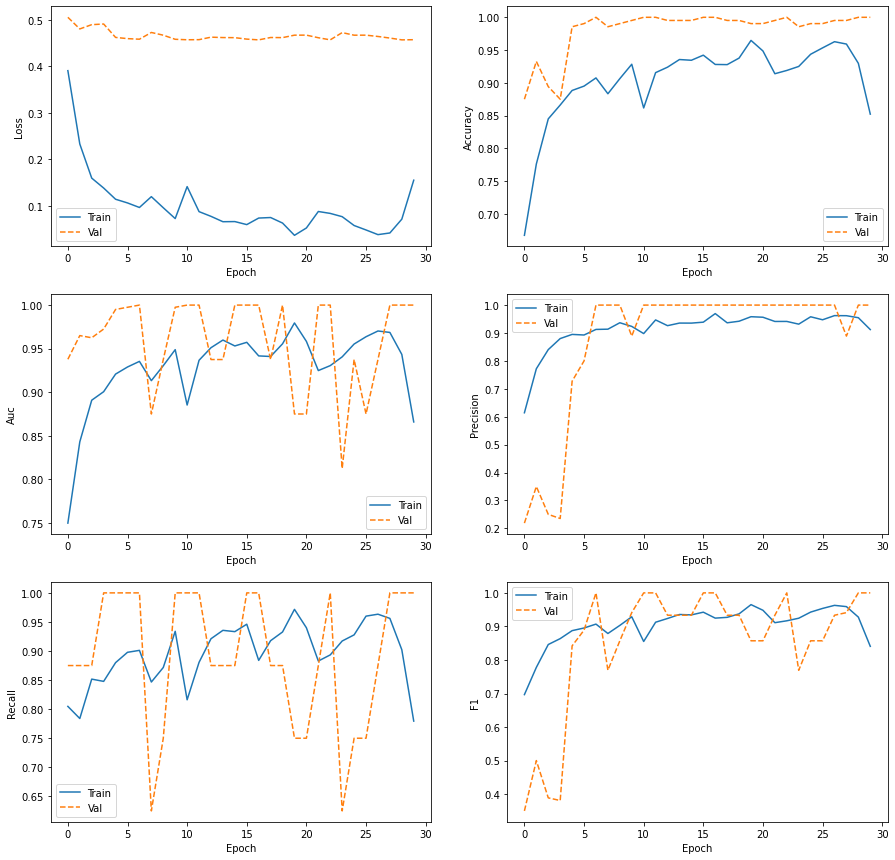

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[2000    0]
 [  21   63]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99      2000
       Covid       1.00      0.75      0.86        84

    accuracy                           0.99      2084
   macro avg       0.99      0.88      0.93      2084
weighted avg       0.99      0.99      0.99      2084

['0:15:18.558731', '0:15:16.347618', '0:15:02.839481', '0:15:34.142572', '0:15:39.075317', '0:15:25.389506', '0:15:19.987741', '0:15:38.897804', '0:15:37.795744', '0:15:33.227596']


In [32]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

### Model 71

In [11]:
model_number = 71
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4, pooling="average" )
    add_dense(model, neurons = 256, n = 3, reg = reg.l2(0.05) )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 24s 988ms/step - loss: 29.2926 - accuracy: 0.6014 - precision: 0.5834 - recall: 0.5608 - auc: 0.6404 - val_loss: 14.9764 - val_accuracy: 0.1866 - val_precision: 0.0503 - val_recall: 1.0000 - val_auc: 0.7844
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 9.8436 - accuracy: 0.7164 - precision: 0.6945 - recall: 0.7728 - auc: 0.7913 - val_loss: 6.0078 - val_accuracy: 0.8804 - val_precision: 0.1923 - val_recall: 0.5556 - val_auc: 0.8831
Epoch 3/30
24/24 [==============================] - 24s 1000ms/step - loss: 4.2928 - accuracy: 0.8261 - precision: 0.8381 - recall: 0.8083 - auc: 0.8995 - val_loss: 2.7202 - val_accuracy: 0.8708 - val_precision: 0.1786 - val_recall: 0.5556 - val_auc: 0.8775
Epoch 4/30
24/24 [==============================] - 24s 1s/step - l

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 29.3541 - accuracy: 0.6033 - precision: 0.5564 - recall: 0.8121 - auc: 0.6718 - val_loss: 15.0382 - val_accuracy: 0.3589 - val_precision: 0.0629 - val_recall: 1.0000 - val_auc: 0.9014
Epoch 2/30
24/24 [==============================] - 25s 1s/step - loss: 9.8017 - accuracy: 0.7619 - precision: 0.7598 - recall: 0.7661 - auc: 0.8361 - val_loss: 6.2891 - val_accuracy: 0.7368 - val_precision: 0.1406 - val_recall: 1.0000 - val_auc: 0.9625
Epoch 3/30
24/24 [==============================] - 24s 981ms/step - loss: 4.2950 - accuracy: 0.8350 - precision: 0.8361 - recall: 0.8333 - auc: 0.9054 - val_loss: 2.9474 - val_accuracy: 0.7608 - val_precision: 0.1525 - val_recall: 1.0000 - val_auc: 0.9647
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 1.9543 - accuracy: 0.8608 - precision: 0.8705 - recall: 0.8478 - auc: 0.9319 - val_loss: 1.3317 - val_accuracy: 0.8469 - val_precision: 0.2195 - val_recall: 1.00

Epoch 1/30
24/24 [==============================] - 23s 957ms/step - loss: 29.3107 - accuracy: 0.6083 - precision: 0.5645 - recall: 0.7673 - auc: 0.6675 - val_loss: 14.6276 - val_accuracy: 0.8995 - val_precision: 0.2000 - val_recall: 0.4444 - val_auc: 0.8622
Epoch 2/30
24/24 [==============================] - 23s 977ms/step - loss: 9.8319 - accuracy: 0.7550 - precision: 0.7495 - recall: 0.7661 - auc: 0.8240 - val_loss: 6.0833 - val_accuracy: 0.8517 - val_precision: 0.1944 - val_recall: 0.7778 - val_auc: 0.9175
Epoch 3/30
24/24 [==============================] - 23s 975ms/step - loss: 4.3365 - accuracy: 0.8242 - precision: 0.8317 - recall: 0.8128 - auc: 0.9006 - val_loss: 3.0735 - val_accuracy: 0.6890 - val_precision: 0.1216 - val_recall: 1.0000 - val_auc: 0.9369
Epoch 4/30
24/24 [==============================] - 24s 997ms/step - loss: 1.9675 - accuracy: 0.8650 - precision: 0.8733 - recall: 0.8539 - auc: 0.9369 - val_loss: 1.0958 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_rec

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 29.2951 - accuracy: 0.6104 - precision: 0.5659 - recall: 0.7711 - auc: 0.6741 - val_loss: 14.9519 - val_accuracy: 0.4641 - val_precision: 0.0744 - val_recall: 1.0000 - val_auc: 0.8869
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 9.7497 - accuracy: 0.7733 - precision: 0.7677 - recall: 0.7839 - auc: 0.8510 - val_loss: 5.9941 - val_accuracy: 0.8660 - val_precision: 0.2286 - val_recall: 0.8889 - val_auc: 0.9567
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 4.2473 - accuracy: 0.8408 - precision: 0.8508 - recall: 0.8267 - auc: 0.9178 - val_loss: 2.7295 - val_accuracy: 0.8612 - val_precision: 0.2222 - val_recall: 0.8889 - val_auc: 0.9578
Epoch 4/30
24/24 [==============================] - 23s 942ms/step - loss: 1.8942 - accuracy: 0.8872 - precision: 0.8974 - recall: 0.8744 - auc: 0.9535 - val_loss: 1.0634 - val_accuracy: 0.9856 - val_precision: 0.8000 - val_recall: 0.88

Epoch 1/30
24/24 [==============================] - 24s 999ms/step - loss: 29.4216 - accuracy: 0.6267 - precision: 0.5763 - recall: 0.8082 - auc: 0.6917 - val_loss: 14.7972 - val_accuracy: 0.8606 - val_precision: 0.1613 - val_recall: 0.6250 - val_auc: 0.8363
Epoch 2/30
24/24 [==============================] - 23s 957ms/step - loss: 9.9617 - accuracy: 0.7531 - precision: 0.7389 - recall: 0.7828 - auc: 0.8289 - val_loss: 6.2036 - val_accuracy: 0.8125 - val_precision: 0.1702 - val_recall: 1.0000 - val_auc: 0.9737
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 4.4457 - accuracy: 0.8114 - precision: 0.8197 - recall: 0.7983 - auc: 0.8874 - val_loss: 2.6787 - val_accuracy: 0.9375 - val_precision: 0.3684 - val_recall: 0.8750 - val_auc: 0.9800
Epoch 4/30
24/24 [==============================] - 24s 988ms/step - loss: 2.0575 - accuracy: 0.8458 - precision: 0.8531 - recall: 0.8356 - auc: 0.9146 - val_loss: 1.1620 - val_accuracy: 0.9519 - val_precision: 0.4286 - val_recall

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 29.3236 - accuracy: 0.6266 - precision: 0.5976 - recall: 0.6538 - auc: 0.6795 - val_loss: 14.9170 - val_accuracy: 0.9183 - val_precision: 0.2000 - val_recall: 0.3750 - val_auc: 0.8341
Epoch 2/30
24/24 [==============================] - 23s 975ms/step - loss: 10.0139 - accuracy: 0.7758 - precision: 0.7662 - recall: 0.7939 - auc: 0.8394 - val_loss: 6.1456 - val_accuracy: 0.9087 - val_precision: 0.2381 - val_recall: 0.6250 - val_auc: 0.9250
Epoch 3/30
24/24 [==============================] - 24s 998ms/step - loss: 4.4257 - accuracy: 0.8294 - precision: 0.8291 - recall: 0.8300 - auc: 0.9083 - val_loss: 2.6464 - val_accuracy: 0.9760 - val_precision: 0.7143 - val_recall: 0.6250 - val_auc: 0.9391
Epoch 4/30
24/24 [==============================] - 23s 966ms/step - loss: 2.0021 - accuracy: 0.8797 - precision: 0.8953 - recall: 0.8600 - auc: 0.9479 - val_loss: 1.2583 - val_accuracy: 0.9087 - val_precision: 0.2800 - val_recal

Epoch 1/30
24/24 [==============================] - 24s 1s/step - loss: 29.4049 - accuracy: 0.6082 - precision: 0.5586 - recall: 0.8324 - auc: 0.6827 - val_loss: 15.0057 - val_accuracy: 0.7837 - val_precision: 0.0698 - val_recall: 0.3750 - val_auc: 0.7997
Epoch 2/30
24/24 [==============================] - 23s 969ms/step - loss: 9.9826 - accuracy: 0.7558 - precision: 0.7657 - recall: 0.7372 - auc: 0.8166 - val_loss: 6.5387 - val_accuracy: 0.5240 - val_precision: 0.0748 - val_recall: 1.0000 - val_auc: 0.8906
Epoch 3/30
24/24 [==============================] - 24s 993ms/step - loss: 4.4689 - accuracy: 0.8025 - precision: 0.7948 - recall: 0.8156 - auc: 0.8721 - val_loss: 2.7915 - val_accuracy: 0.8942 - val_precision: 0.2500 - val_recall: 0.8750 - val_auc: 0.9278
Epoch 4/30
24/24 [==============================] - 24s 986ms/step - loss: 1.9998 - accuracy: 0.8669 - precision: 0.8785 - recall: 0.8517 - auc: 0.9387 - val_loss: 1.1311 - val_accuracy: 0.9808 - val_precision: 0.7500 - val_recall

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 29.2185 - accuracy: 0.5874 - precision: 0.5374 - recall: 0.9408 - auc: 0.6894 - val_loss: 14.4576 - val_accuracy: 0.9519 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8341
Epoch 2/30
24/24 [==============================] - 25s 1s/step - loss: 9.7297 - accuracy: 0.7347 - precision: 0.7367 - recall: 0.7306 - auc: 0.8133 - val_loss: 5.7964 - val_accuracy: 0.9519 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.8800
Epoch 3/30
24/24 [==============================] - 25s 1s/step - loss: 4.1901 - accuracy: 0.8464 - precision: 0.8501 - recall: 0.8411 - auc: 0.9278 - val_loss: 2.5515 - val_accuracy: 0.9519 - val_precision: 0.4286 - val_recall: 0.7500 - val_auc: 0.9591
Epoch 4/30
24/24 [==============================] - 23s 966ms/step - loss: 1.8934 - accuracy: 0.8822 - precision: 0.8922 - recall: 0.8694 - auc: 0.9473 - val_loss: 1.0771 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_reca

Epoch 1/30
24/24 [==============================] - 24s 1s/step - loss: 29.3121 - accuracy: 0.6179 - precision: 0.5777 - recall: 0.7262 - auc: 0.6757 - val_loss: 14.9630 - val_accuracy: 0.5192 - val_precision: 0.0660 - val_recall: 0.8750 - val_auc: 0.7809
Epoch 2/30
24/24 [==============================] - 24s 1s/step - loss: 9.9035 - accuracy: 0.7489 - precision: 0.7430 - recall: 0.7611 - auc: 0.8213 - val_loss: 6.4053 - val_accuracy: 0.6971 - val_precision: 0.0896 - val_recall: 0.7500 - val_auc: 0.8475
Epoch 3/30
24/24 [==============================] - 23s 972ms/step - loss: 4.4043 - accuracy: 0.8319 - precision: 0.8366 - recall: 0.8250 - auc: 0.9029 - val_loss: 2.7227 - val_accuracy: 0.9183 - val_precision: 0.2632 - val_recall: 0.6250 - val_auc: 0.9050
Epoch 4/30
24/24 [==============================] - 23s 973ms/step - loss: 2.0482 - accuracy: 0.8628 - precision: 0.8656 - recall: 0.8589 - auc: 0.9322 - val_loss: 1.1743 - val_accuracy: 0.9615 - val_precision: 0.5000 - val_recall: 0

Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 29.2966 - accuracy: 0.5738 - precision: 0.5359 - recall: 0.7644 - auc: 0.6487 - val_loss: 14.9784 - val_accuracy: 0.6875 - val_precision: 0.0746 - val_recall: 0.6250 - val_auc: 0.7319
Epoch 2/30
24/24 [==============================] - 24s 997ms/step - loss: 10.0337 - accuracy: 0.6728 - precision: 0.6247 - recall: 0.8656 - auc: 0.7701 - val_loss: 6.1115 - val_accuracy: 0.9087 - val_precision: 0.2609 - val_recall: 0.7500 - val_auc: 0.9363
Epoch 3/30
24/24 [==============================] - 24s 981ms/step - loss: 4.4115 - accuracy: 0.8119 - precision: 0.8189 - recall: 0.8011 - auc: 0.8873 - val_loss: 2.6152 - val_accuracy: 0.9615 - val_precision: 0.5000 - val_recall: 0.8750 - val_auc: 0.9728
Epoch 4/30
24/24 [==============================] - 24s 998ms/step - loss: 2.0690 - accuracy: 0.8239 - precision: 0.8309 - recall: 0.8133 - auc: 0.8991 - val_loss: 1.1967 - val_accuracy: 0.9519 - val_precision: 0.4375 - val_recal

FOLD: 0best epoch: 30F1 score: 0.9411764743006353
FOLD: 1best epoch: 8F1 score: 0.9411764743006353
FOLD: 2best epoch: 5F1 score: 0.9411764743006353
FOLD: 3best epoch: 17F1 score: 1.0
FOLD: 4best epoch: 7F1 score: 1.0
FOLD: 5best epoch: 12F1 score: 1.0
FOLD: 6best epoch: 12F1 score: 1.0
FOLD: 7best epoch: 26F1 score: 1.0
FOLD: 8best epoch: 24F1 score: 1.0
FOLD: 9best epoch: 17F1 score: 1.0
Median best epoch:  14
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging

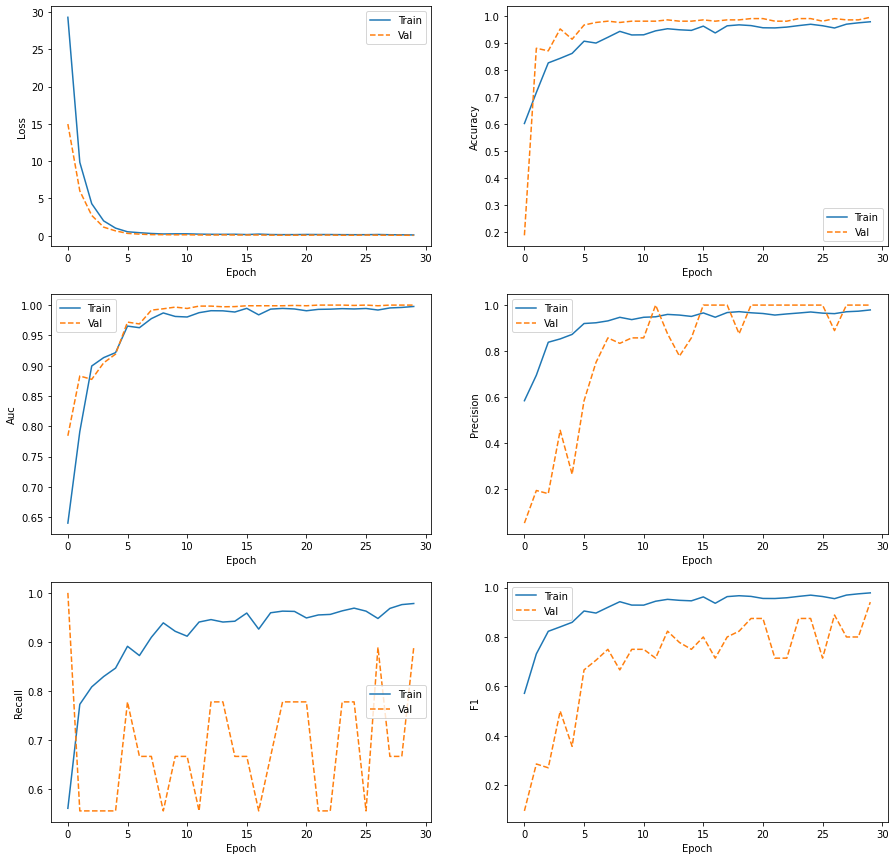

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 1


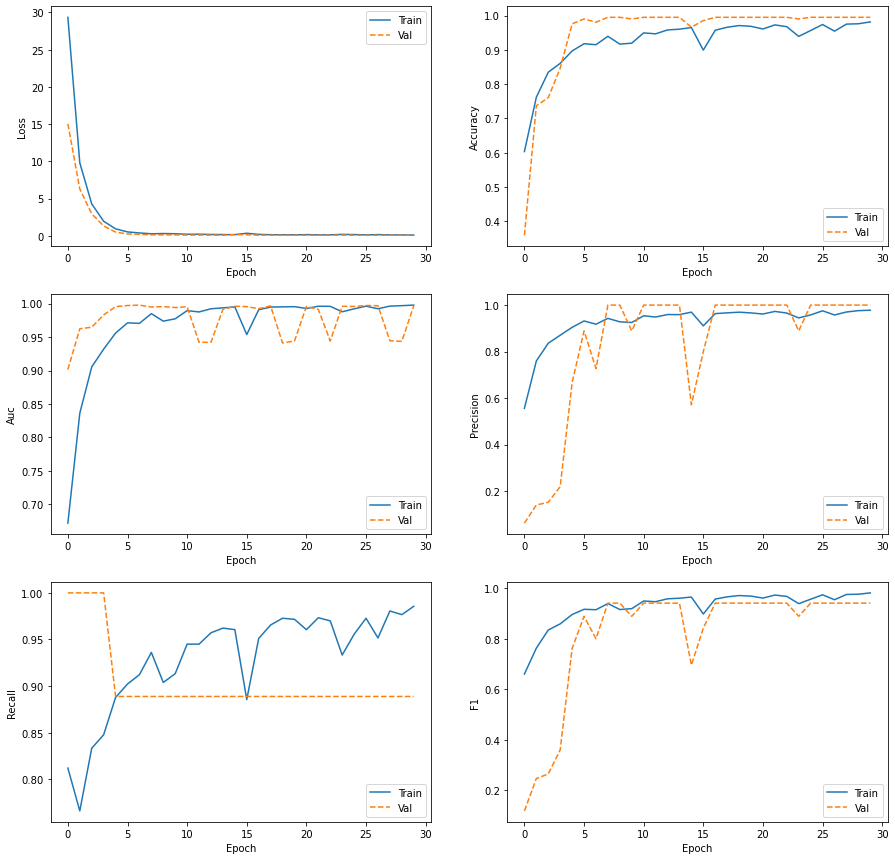

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


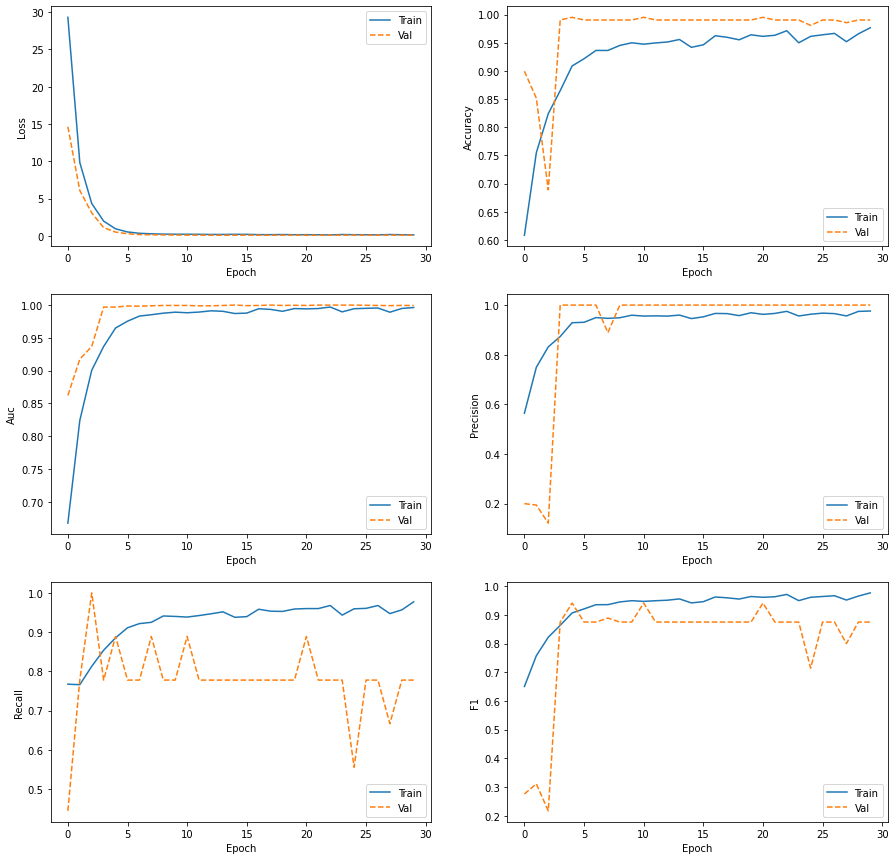

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 3


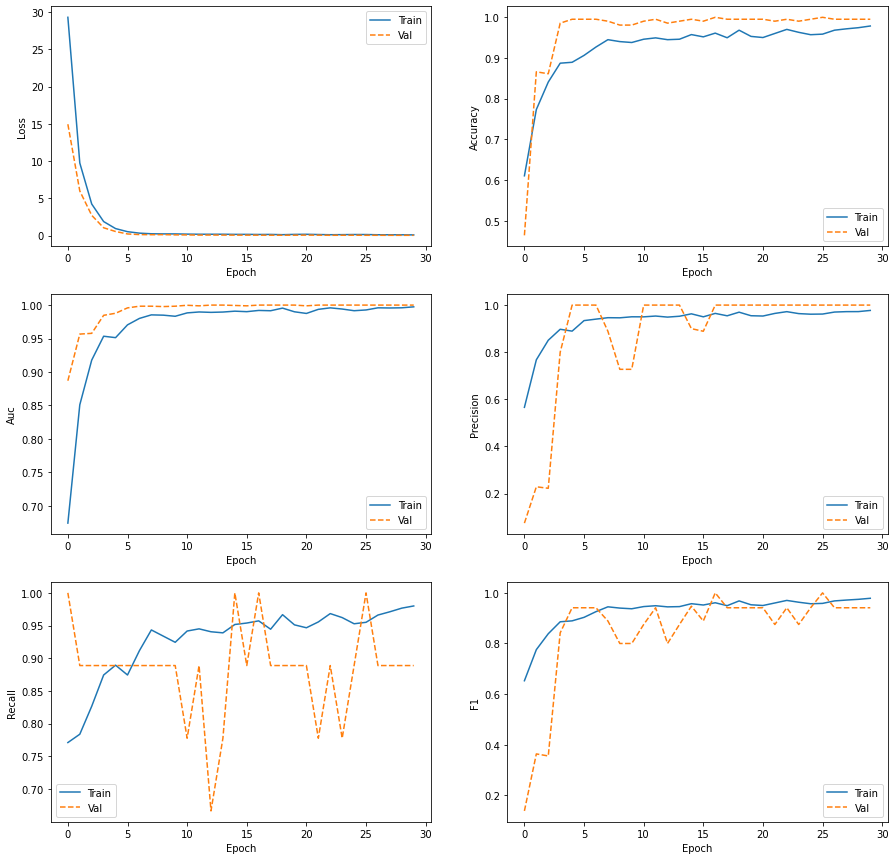

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 4


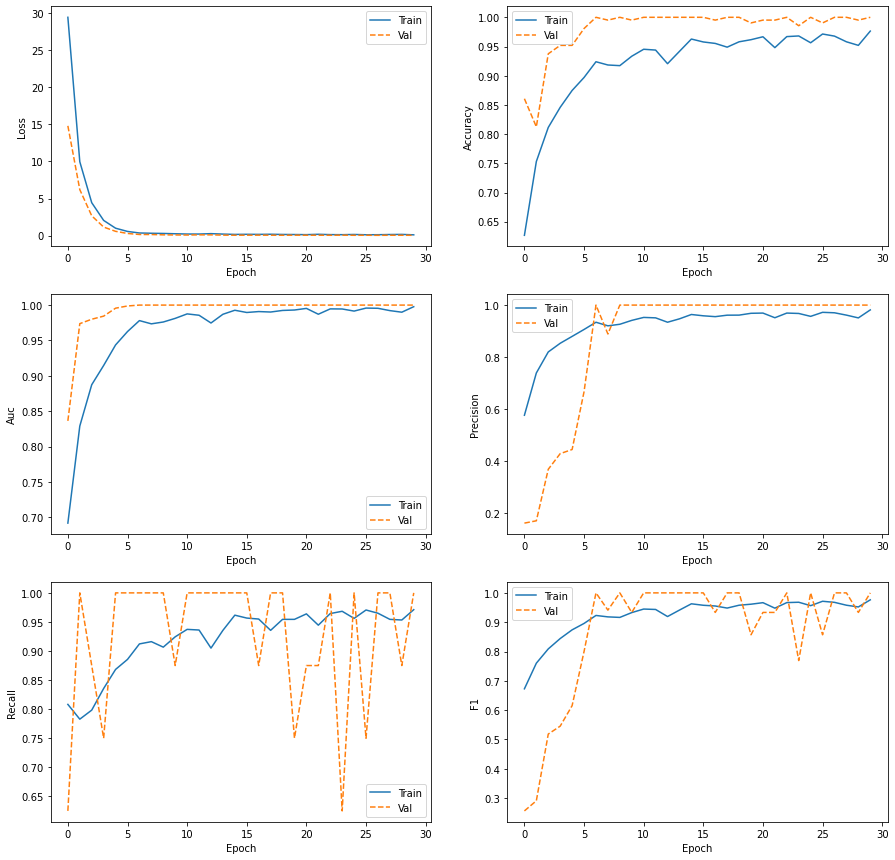

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 5


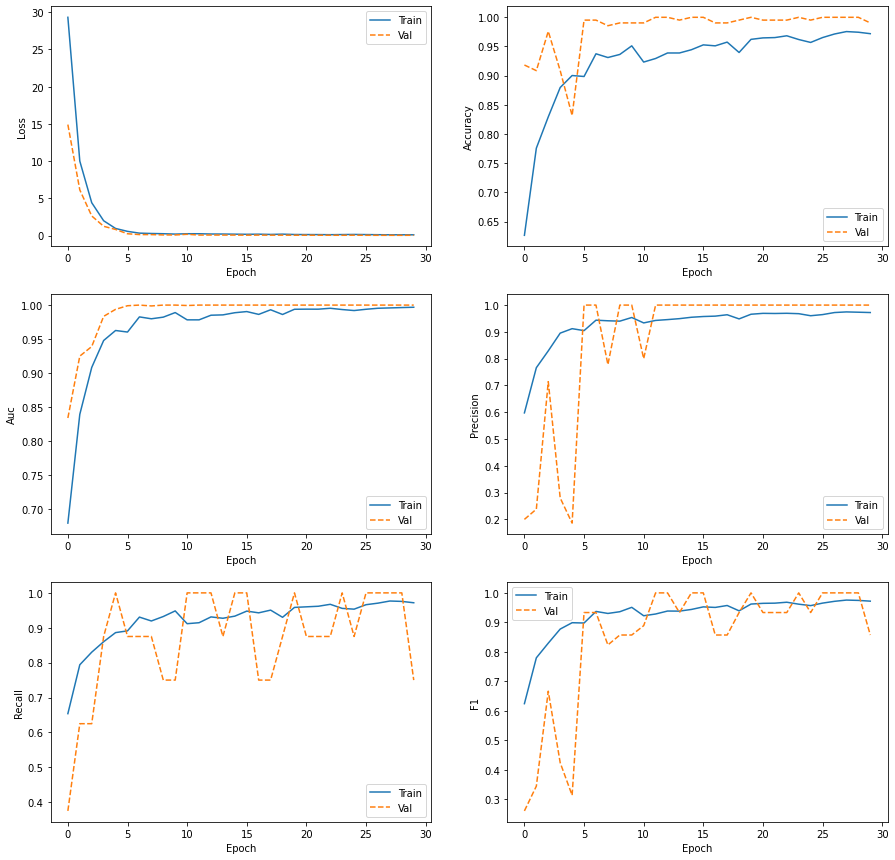

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 6


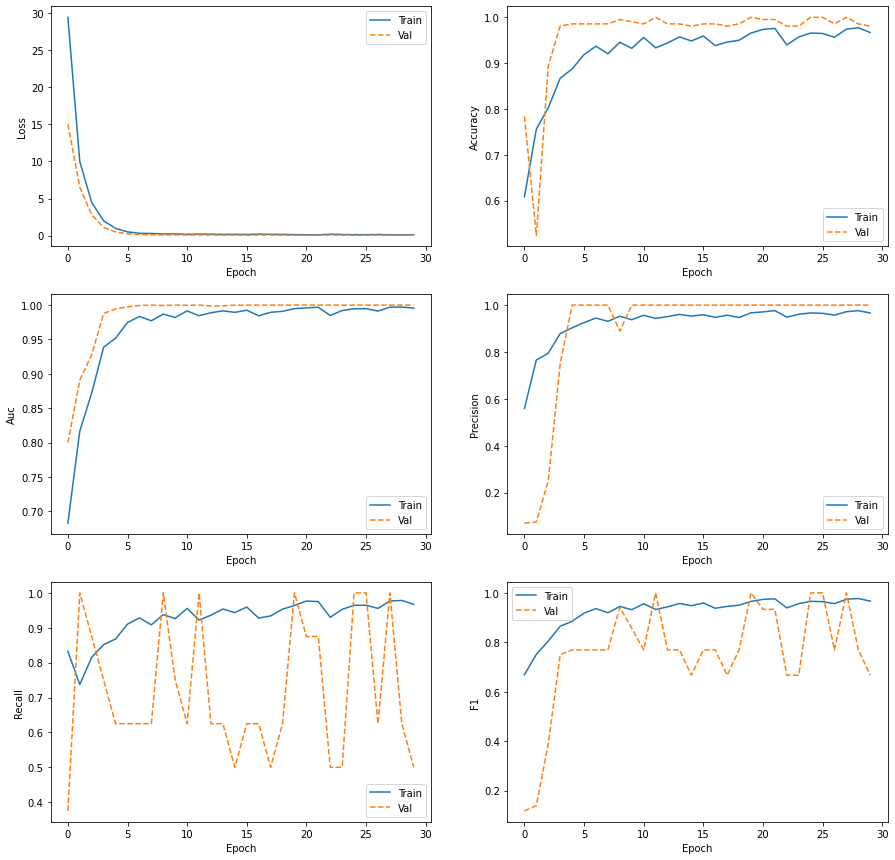

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 7


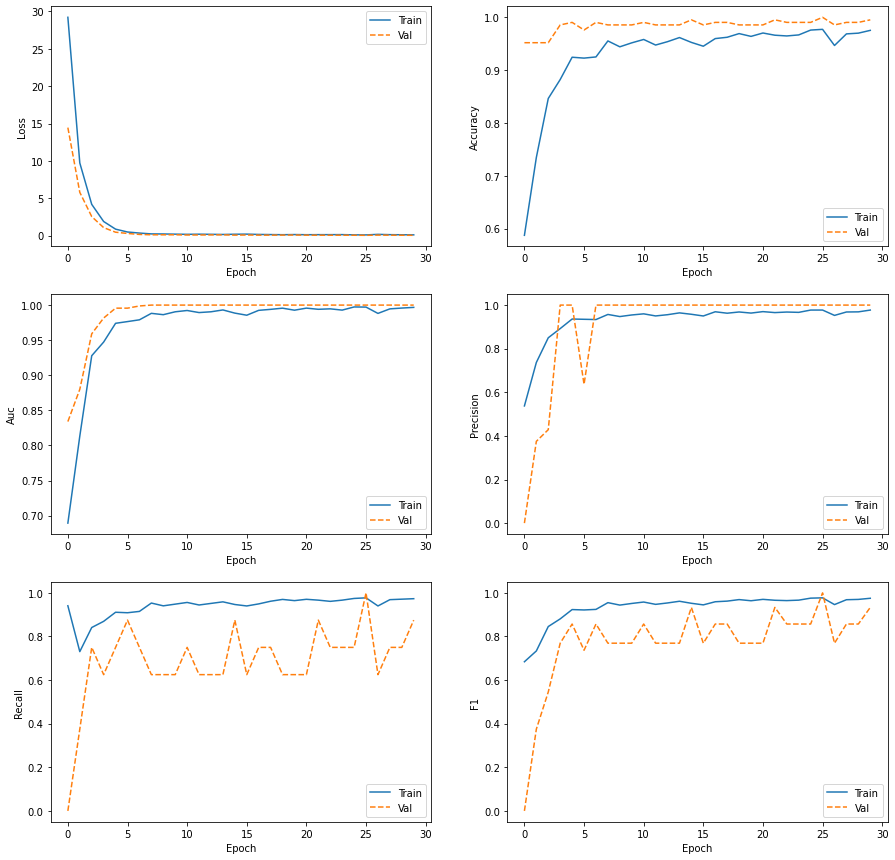

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 8


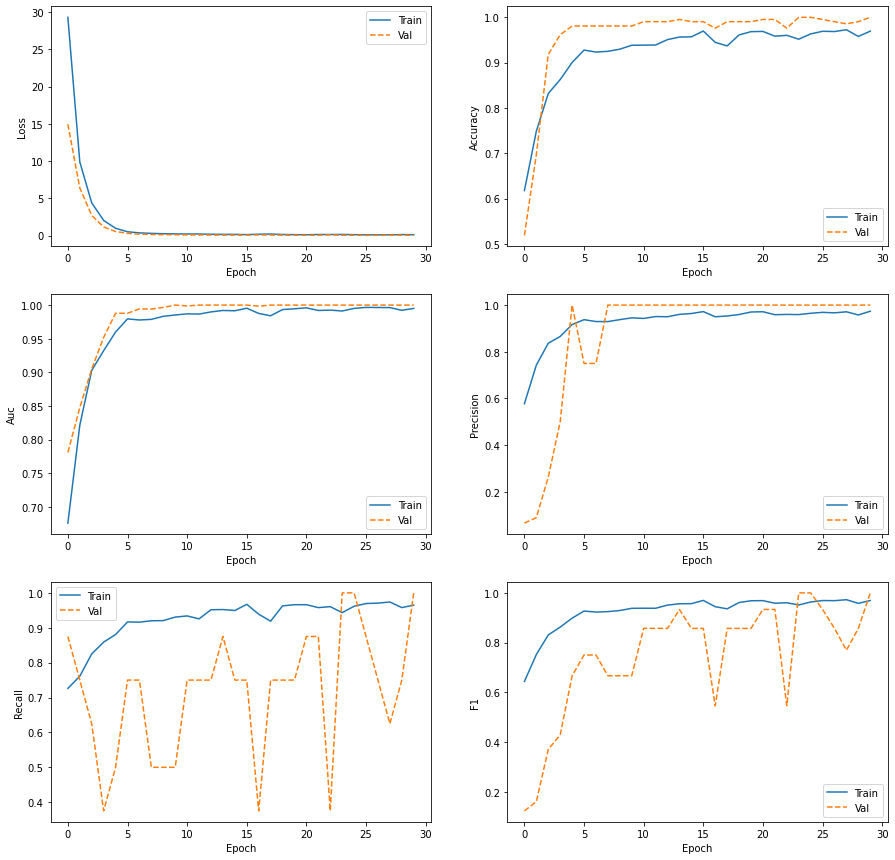

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


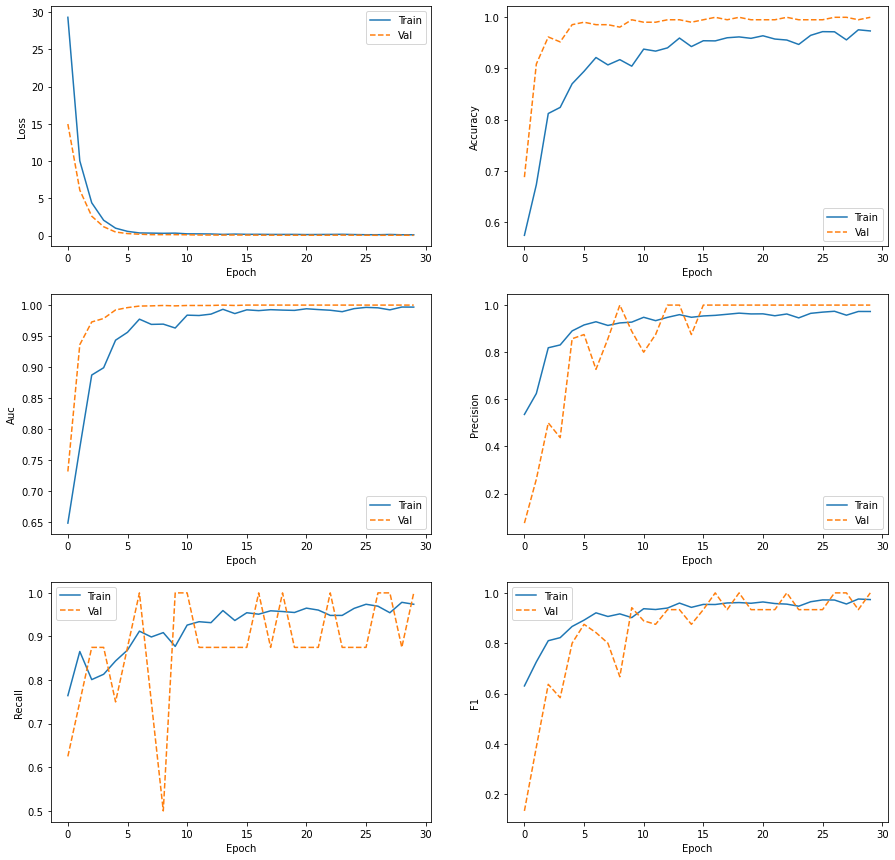

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1998    2]
 [  16   68]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00      2000
       Covid       0.97      0.81      0.88        84

    accuracy                           0.99      2084
   macro avg       0.98      0.90      0.94      2084
weighted avg       0.99      0.99      0.99      2084

['0:15:52.880092', '0:15:39.560863', '0:15:11.631754', '0:15:55.719450', '0:16:13.258074', '0:15:48.366416', '0:15:49.789660', '0:16:00.068986', '0:16:01.526821', '0:15:55.310914']


In [27]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))
print("Median best epoch: ", val_epoch+1)

val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

### model 72

In [8]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [11]:
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [12]:
model_number = 72
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model(loss=macro_double_soft_f1)
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4, pooling="max" )
    add_dense(model, neurons = 256, n = 3)

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.4358 - accuracy: 0.6028 - precision: 0.5747 - recall: 0.7911 - auc: 0.6777 - val_loss: 0.5296 - val_accuracy: 0.8421 - val_precision: 0.1667 - val_recall: 0.6667 - val_auc: 0.8469
Epoch 2/30
24/24 [==============================] - 29s 1s/step - loss: 0.2499 - accuracy: 0.7653 - precision: 0.7759 - recall: 0.7461 - auc: 0.8280 - val_loss: 0.5097 - val_accuracy: 0.8612 - val_precision: 0.1875 - val_recall: 0.6667 - val_auc: 0.8039
Epoch 3/30
24/24 [==============================] - 26s 1s/step - loss: 0.1812 - accuracy: 0.8219 - precision: 0.8218 - recall: 0.8222 - auc: 0.8676 - val_loss: 0.4888 - val_accuracy: 0.9426 - val_precision: 0.3846 - val_recall: 0.5556 - val_auc: 0.7528
Epoch 4/30
24/24 [==============================] - 23s 975ms/step - loss: 0

Epoch 1/30
24/24 [==============================] - 28s 1s/step - loss: 0.3788 - accuracy: 0.6682 - precision: 0.6148 - recall: 0.8065 - auc: 0.7665 - val_loss: 0.5451 - val_accuracy: 0.7225 - val_precision: 0.1343 - val_recall: 1.0000 - val_auc: 0.9275
Epoch 2/30
24/24 [==============================] - 23s 966ms/step - loss: 0.2019 - accuracy: 0.8064 - precision: 0.7983 - recall: 0.8200 - auc: 0.8503 - val_loss: 0.5626 - val_accuracy: 0.6986 - val_precision: 0.1250 - val_recall: 1.0000 - val_auc: 0.8850
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.2316 - accuracy: 0.7803 - precision: 0.7888 - recall: 0.7656 - auc: 0.8275 - val_loss: 0.4784 - val_accuracy: 0.9378 - val_precision: 0.3889 - val_recall: 0.7778 - val_auc: 0.9689
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.1782 - accuracy: 0.8258 - precision: 0.8396 - recall: 0.8056 - auc: 0.8823 - val_loss: 0.4740 - val_accuracy: 0.9378 - val_precision: 0.4000 - val_recall: 0.8889

Epoch 3/30
24/24 [==============================] - 24s 997ms/step - loss: 0.1591 - accuracy: 0.8444 - precision: 0.8576 - recall: 0.8261 - auc: 0.8816 - val_loss: 0.4774 - val_accuracy: 0.9474 - val_precision: 0.4375 - val_recall: 0.7778 - val_auc: 0.9228
Epoch 4/30
24/24 [==============================] - 23s 954ms/step - loss: 0.1774 - accuracy: 0.8267 - precision: 0.8661 - recall: 0.7728 - auc: 0.8669 - val_loss: 0.5051 - val_accuracy: 0.8612 - val_precision: 0.2222 - val_recall: 0.8889 - val_auc: 0.8903
Epoch 5/30
24/24 [==============================] - 23s 977ms/step - loss: 0.1342 - accuracy: 0.8686 - precision: 0.8966 - recall: 0.8333 - auc: 0.9056 - val_loss: 0.4968 - val_accuracy: 0.8804 - val_precision: 0.2500 - val_recall: 0.8889 - val_auc: 0.9111
Epoch 6/30
24/24 [==============================] - 24s 991ms/step - loss: 0.1564 - accuracy: 0.8475 - precision: 0.8859 - recall: 0.7978 - auc: 0.8831 - val_loss: 0.4616 - val_accuracy: 0.9856 - val_precision: 0.8000 - val_recal

Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.1907 - accuracy: 0.8142 - precision: 0.8161 - recall: 0.8111 - auc: 0.8659 - val_loss: 0.4749 - val_accuracy: 0.9330 - val_precision: 0.3810 - val_recall: 0.8889 - val_auc: 0.9242
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.1687 - accuracy: 0.8383 - precision: 0.8472 - recall: 0.8256 - auc: 0.8761 - val_loss: 0.4859 - val_accuracy: 0.8995 - val_precision: 0.2857 - val_recall: 0.8889 - val_auc: 0.8983
Epoch 5/30
24/24 [==============================] - 24s 982ms/step - loss: 0.1113 - accuracy: 0.8922 - precision: 0.8971 - recall: 0.8861 - auc: 0.9273 - val_loss: 0.4594 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9444
Epoch 6/30
24/24 [==============================] - 23s 951ms/step - loss: 0.1278 - accuracy: 0.8742 - precision: 0.8964 - recall: 0.8461 - auc: 0.9033 - val_loss: 0.4657 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7

Epoch 3/30
24/24 [==============================] - 24s 1000ms/step - loss: 0.1339 - accuracy: 0.8686 - precision: 0.8837 - recall: 0.8489 - auc: 0.9028 - val_loss: 0.4585 - val_accuracy: 0.9952 - val_precision: 0.8889 - val_recall: 1.0000 - val_auc: 0.9966
Epoch 4/30
24/24 [==============================] - 23s 948ms/step - loss: 0.1009 - accuracy: 0.9003 - precision: 0.9045 - recall: 0.8950 - auc: 0.9412 - val_loss: 0.4722 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.9369
Epoch 5/30
24/24 [==============================] - 24s 1s/step - loss: 0.0950 - accuracy: 0.9072 - precision: 0.9242 - recall: 0.8872 - auc: 0.9385 - val_loss: 0.4677 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 1.0000
Epoch 6/30
24/24 [==============================] - 24s 1s/step - loss: 0.0572 - accuracy: 0.9447 - precision: 0.9525 - recall: 0.9361 - auc: 0.9711 - val_loss: 0.4655 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.

Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.1470 - accuracy: 0.8567 - precision: 0.8648 - recall: 0.8456 - auc: 0.8991 - val_loss: 0.4885 - val_accuracy: 0.9375 - val_precision: 0.3333 - val_recall: 0.6250 - val_auc: 0.8478
Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.1495 - accuracy: 0.8539 - precision: 0.8492 - recall: 0.8606 - auc: 0.8884 - val_loss: 0.5158 - val_accuracy: 0.8269 - val_precision: 0.1500 - val_recall: 0.7500 - val_auc: 0.8494
Epoch 5/30
24/24 [==============================] - 22s 937ms/step - loss: 0.1473 - accuracy: 0.8569 - precision: 0.8608 - recall: 0.8517 - auc: 0.8897 - val_loss: 0.4863 - val_accuracy: 0.9423 - val_precision: 0.3571 - val_recall: 0.6250 - val_auc: 0.7928
Epoch 6/30
24/24 [==============================] - 23s 957ms/step - loss: 0.1286 - accuracy: 0.8733 - precision: 0.9093 - recall: 0.8294 - auc: 0.9007 - val_loss: 0.4959 - val_accuracy: 0.9087 - val_precision: 0.2381 - val_recall: 0.6

Epoch 3/30
24/24 [==============================] - 25s 1s/step - loss: 0.1856 - accuracy: 0.8203 - precision: 0.8277 - recall: 0.8089 - auc: 0.8645 - val_loss: 0.4980 - val_accuracy: 0.8990 - val_precision: 0.2593 - val_recall: 0.8750 - val_auc: 0.9341
Epoch 4/30
24/24 [==============================] - 23s 952ms/step - loss: 0.1562 - accuracy: 0.8500 - precision: 0.8768 - recall: 0.8144 - auc: 0.8810 - val_loss: 0.5342 - val_accuracy: 0.7837 - val_precision: 0.1509 - val_recall: 1.0000 - val_auc: 0.9175
Epoch 5/30
24/24 [==============================] - 24s 998ms/step - loss: 0.1484 - accuracy: 0.8533 - precision: 0.8557 - recall: 0.8500 - auc: 0.8843 - val_loss: 0.5029 - val_accuracy: 0.9567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8072
Epoch 6/30
24/24 [==============================] - 25s 1s/step - loss: 0.1453 - accuracy: 0.8597 - precision: 0.8838 - recall: 0.8283 - auc: 0.8915 - val_loss: 0.4890 - val_accuracy: 0.9183 - val_precision: 0.3200 - val_rec

Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.1623 - accuracy: 0.8403 - precision: 0.8428 - recall: 0.8367 - auc: 0.8846 - val_loss: 0.5047 - val_accuracy: 0.8750 - val_precision: 0.2000 - val_recall: 0.7500 - val_auc: 0.8209
Epoch 4/30
24/24 [==============================] - 27s 1s/step - loss: 0.1821 - accuracy: 0.8258 - precision: 0.8444 - recall: 0.7989 - auc: 0.8676 - val_loss: 0.5565 - val_accuracy: 0.7356 - val_precision: 0.1017 - val_recall: 0.7500 - val_auc: 0.7619
Epoch 5/30
24/24 [==============================] - 23s 953ms/step - loss: 0.1419 - accuracy: 0.8611 - precision: 0.8731 - recall: 0.8450 - auc: 0.9019 - val_loss: 0.5219 - val_accuracy: 0.8269 - val_precision: 0.1500 - val_recall: 0.7500 - val_auc: 0.8062
Epoch 6/30
24/24 [==============================] - 23s 964ms/step - loss: 0.1305 - accuracy: 0.8728 - precision: 0.8651 - recall: 0.8833 - auc: 0.8970 - val_loss: 0.4881 - val_accuracy: 0.9663 - val_precision: 0.6000 - val_recall: 0.3

Epoch 3/30
24/24 [==============================] - 24s 999ms/step - loss: 0.1971 - accuracy: 0.8094 - precision: 0.7969 - recall: 0.8306 - auc: 0.8391 - val_loss: 0.4998 - val_accuracy: 0.9183 - val_precision: 0.2353 - val_recall: 0.5000 - val_auc: 0.8316
Epoch 4/30
24/24 [==============================] - 23s 974ms/step - loss: 0.1508 - accuracy: 0.8517 - precision: 0.8564 - recall: 0.8450 - auc: 0.8863 - val_loss: 0.4992 - val_accuracy: 0.8990 - val_precision: 0.2174 - val_recall: 0.6250 - val_auc: 0.8181
Epoch 5/30
24/24 [==============================] - 24s 1s/step - loss: 0.1418 - accuracy: 0.8603 - precision: 0.8687 - recall: 0.8489 - auc: 0.8914 - val_loss: 0.4959 - val_accuracy: 0.9231 - val_precision: 0.2500 - val_recall: 0.5000 - val_auc: 0.8328
Epoch 6/30
24/24 [==============================] - 25s 1s/step - loss: 0.1437 - accuracy: 0.8586 - precision: 0.8556 - recall: 0.8628 - auc: 0.8827 - val_loss: 0.4957 - val_accuracy: 0.9471 - val_precision: 0.3333 - val_recall: 0.3

Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.1594 - accuracy: 0.8450 - precision: 0.8405 - recall: 0.8517 - auc: 0.8908 - val_loss: 0.4894 - val_accuracy: 0.8942 - val_precision: 0.2500 - val_recall: 0.8750 - val_auc: 0.9625
Epoch 4/30
24/24 [==============================] - 23s 956ms/step - loss: 0.1381 - accuracy: 0.8661 - precision: 0.8800 - recall: 0.8478 - auc: 0.9006 - val_loss: 0.4908 - val_accuracy: 0.8750 - val_precision: 0.2353 - val_recall: 1.0000 - val_auc: 0.9725
Epoch 5/30
24/24 [==============================] - 24s 991ms/step - loss: 0.1140 - accuracy: 0.8883 - precision: 0.8949 - recall: 0.8800 - auc: 0.9208 - val_loss: 0.4620 - val_accuracy: 0.9856 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.9950
Epoch 6/30
24/24 [==============================] - 23s 968ms/step - loss: 0.1060 - accuracy: 0.8950 - precision: 0.8928 - recall: 0.8978 - auc: 0.9289 - val_loss: 0.4594 - val_accuracy: 0.9904 - val_precision: 0.8000 - val_recall: 

In [18]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))
print("Median best epoch: ", val_epoch+1)

val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

FOLD: 0best epoch: 30F1 score: 0.8421052727342643
FOLD: 1best epoch: 14F1 score: 0.9411764743006353
FOLD: 2best epoch: 23F1 score: 0.9473684078438459
FOLD: 3best epoch: 5F1 score: 0.9411764743006353
FOLD: 4best epoch: 8F1 score: 1.0
FOLD: 5best epoch: 19F1 score: 1.0
FOLD: 6best epoch: 17F1 score: 0.9333333333333333
FOLD: 7best epoch: 19F1 score: 0.9333333333333333
FOLD: 8best epoch: 21F1 score: 0.9333333333333333
FOLD: 9best epoch: 7F1 score: 1.0
Median best epoch:  18
Found 209 validated image filenames belonging to 2 classes.


ValueError: You are trying to load a weight file containing 8 layers into a model with 9 layers.

### model 73

In [33]:
model_number = 73
k = 10
number_of_its = 10
epochs = 30

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [16,32, 64, 128,256], drop = 0.4, pooling="average" )
    add_dense(model, neurons = 128, n = 3 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 0.6419 - accuracy: 0.6423 - precision: 0.6279 - recall: 0.6056 - auc: 0.7121 - val_loss: 0.4496 - val_accuracy: 0.8373 - val_precision: 0.1622 - val_recall: 0.6667 - val_auc: 0.8553
Epoch 2/30
24/24 [==============================] - 26s 1s/step - loss: 0.4312 - accuracy: 0.8117 - precision: 0.8209 - recall: 0.7972 - auc: 0.8833 - val_loss: 0.6488 - val_accuracy: 0.6938 - val_precision: 0.1014 - val_recall: 0.7778 - val_auc: 0.8556
Epoch 3/30
24/24 [==============================] - 26s 1s/step - loss: 0.3148 - accuracy: 0.8717 - precision: 0.8717 - recall: 0.8717 - auc: 0.9393 - val_loss: 0.1833 - val_accuracy: 0.9330 - val_precision: 0.3529 - val_recall: 0.6667 - val_auc: 0.9294
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0.21

Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 0.6565 - accuracy: 0.5996 - precision: 0.5667 - recall: 0.6672 - auc: 0.6804 - val_loss: 0.6714 - val_accuracy: 0.6938 - val_precision: 0.1233 - val_recall: 1.0000 - val_auc: 0.9275
Epoch 2/30
24/24 [==============================] - 23s 963ms/step - loss: 0.4548 - accuracy: 0.7939 - precision: 0.8068 - recall: 0.7728 - auc: 0.8708 - val_loss: 0.3317 - val_accuracy: 0.8900 - val_precision: 0.2667 - val_recall: 0.8889 - val_auc: 0.9753
Epoch 3/30
24/24 [==============================] - 23s 958ms/step - loss: 0.3457 - accuracy: 0.8589 - precision: 0.8542 - recall: 0.8656 - auc: 0.9268 - val_loss: 0.2466 - val_accuracy: 0.8900 - val_precision: 0.2667 - val_recall: 0.8889 - val_auc: 0.9808
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0.2427 - accuracy: 0.9064 - precision: 0.9178 - recall: 0.8928 - auc: 0.9644 - val_loss: 0.0577 - val_accuracy: 0.9809 - val_precision: 0.7273 - val_recall: 0.8

24/24 [==============================] - 26s 1s/step - loss: 0.6234 - accuracy: 0.6374 - precision: 0.5898 - recall: 0.7772 - auc: 0.7389 - val_loss: 0.4583 - val_accuracy: 0.8086 - val_precision: 0.1702 - val_recall: 0.8889 - val_auc: 0.9189
Epoch 2/30
24/24 [==============================] - 26s 1s/step - loss: 0.3761 - accuracy: 0.8306 - precision: 0.8463 - recall: 0.8078 - auc: 0.9137 - val_loss: 0.4679 - val_accuracy: 0.7608 - val_precision: 0.1404 - val_recall: 0.8889 - val_auc: 0.9486
Epoch 3/30
24/24 [==============================] - 24s 1s/step - loss: 0.3280 - accuracy: 0.8586 - precision: 0.8616 - recall: 0.8544 - auc: 0.9344 - val_loss: 0.1783 - val_accuracy: 0.9378 - val_precision: 0.4000 - val_recall: 0.8889 - val_auc: 0.9794
Epoch 4/30
24/24 [==============================] - 25s 1s/step - loss: 0.2027 - accuracy: 0.9175 - precision: 0.9248 - recall: 0.9089 - auc: 0.9751 - val_loss: 0.0288 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6667 - val_auc: 1.

24/24 [==============================] - 26s 1s/step - loss: 0.2434 - accuracy: 0.9000 - precision: 0.9091 - recall: 0.8889 - auc: 0.9637 - val_loss: 0.0321 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9939
Epoch 5/30
24/24 [==============================] - 24s 1s/step - loss: 0.1615 - accuracy: 0.9333 - precision: 0.9382 - recall: 0.9278 - auc: 0.9851 - val_loss: 0.0154 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 0.9997
Epoch 6/30
24/24 [==============================] - 25s 1s/step - loss: 0.0991 - accuracy: 0.9642 - precision: 0.9655 - recall: 0.9628 - auc: 0.9939 - val_loss: 0.0242 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7778 - val_auc: 1.0000
Epoch 7/30
24/24 [==============================] - 24s 1s/step - loss: 0.1379 - accuracy: 0.9461 - precision: 0.9516 - recall: 0.9400 - auc: 0.9883 - val_loss: 0.0116 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8889 - val_auc: 1.

24/24 [==============================] - 23s 962ms/step - loss: 0.1839 - accuracy: 0.9278 - precision: 0.9375 - recall: 0.9167 - auc: 0.9799 - val_loss: 0.0088 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 5/30
24/24 [==============================] - 25s 1s/step - loss: 0.1611 - accuracy: 0.9397 - precision: 0.9484 - recall: 0.9300 - auc: 0.9836 - val_loss: 0.0274 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 6/30
24/24 [==============================] - 24s 994ms/step - loss: 0.1098 - accuracy: 0.9575 - precision: 0.9583 - recall: 0.9567 - auc: 0.9922 - val_loss: 0.0041 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 7/30
24/24 [==============================] - 25s 1s/step - loss: 0.1223 - accuracy: 0.9539 - precision: 0.9569 - recall: 0.9506 - auc: 0.9904 - val_loss: 0.0058 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_a

24/24 [==============================] - 25s 1s/step - loss: 0.1861 - accuracy: 0.9272 - precision: 0.9306 - recall: 0.9233 - auc: 0.9789 - val_loss: 0.0176 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 1.0000
Epoch 5/30
24/24 [==============================] - 29s 1s/step - loss: 0.1551 - accuracy: 0.9353 - precision: 0.9409 - recall: 0.9289 - auc: 0.9855 - val_loss: 0.0168 - val_accuracy: 0.9952 - val_precision: 0.8889 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 6/30
24/24 [==============================] - 24s 1s/step - loss: 0.0976 - accuracy: 0.9617 - precision: 0.9606 - recall: 0.9628 - auc: 0.9937 - val_loss: 0.0048 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 7/30
24/24 [==============================] - 25s 1s/step - loss: 0.1614 - accuracy: 0.9364 - precision: 0.9405 - recall: 0.9317 - auc: 0.9837 - val_loss: 0.0566 - val_accuracy: 0.9952 - val_precision: 0.8889 - val_recall: 1.0000 - val_auc: 1.

Epoch 4/30
24/24 [==============================] - 24s 1s/step - loss: 0.2068 - accuracy: 0.9103 - precision: 0.9222 - recall: 0.8961 - auc: 0.9743 - val_loss: 0.0264 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.9994
Epoch 5/30
24/24 [==============================] - 26s 1s/step - loss: 0.1562 - accuracy: 0.9397 - precision: 0.9484 - recall: 0.9300 - auc: 0.9842 - val_loss: 0.0295 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 1.0000
Epoch 6/30
24/24 [==============================] - 25s 1s/step - loss: 0.1243 - accuracy: 0.9508 - precision: 0.9640 - recall: 0.9367 - auc: 0.9909 - val_loss: 0.0102 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 7/30
24/24 [==============================] - 25s 1s/step - loss: 0.1281 - accuracy: 0.9519 - precision: 0.9512 - recall: 0.9528 - auc: 0.9893 - val_loss: 0.0295 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - 

24/24 [==============================] - 30s 1s/step - loss: 0.1663 - accuracy: 0.9342 - precision: 0.9373 - recall: 0.9306 - auc: 0.9832 - val_loss: 0.0233 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 1.0000
Epoch 5/30
24/24 [==============================] - 25s 1s/step - loss: 0.1195 - accuracy: 0.9533 - precision: 0.9564 - recall: 0.9500 - auc: 0.9910 - val_loss: 0.0078 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 6/30
24/24 [==============================] - 25s 1s/step - loss: 0.1022 - accuracy: 0.9617 - precision: 0.9617 - recall: 0.9617 - auc: 0.9934 - val_loss: 0.0258 - val_accuracy: 0.9856 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 1.0000
Epoch 7/30
24/24 [==============================] - 27s 1s/step - loss: 0.0826 - accuracy: 0.9714 - precision: 0.9748 - recall: 0.9678 - auc: 0.9952 - val_loss: 0.0217 - val_accuracy: 0.9904 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 1.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24/24 [==============================] - 24s 1s/step - loss: 0.0499 - accuracy: 0.9806 - precision: 0.9816 - recall: 0.9794 - auc: 0.9981 - val_loss: 0.0133 - val_accuracy: 0.9952 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 1.0000
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208

0:16:36.366623
###### K Fold Validation step => 9 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Epoch 1/30
24/24 [==============================] - 25s 1s/step - loss: 0.6896 - accuracy: 0.5449 - precision: 0.5176 - recall: 0.6090 - auc: 0.5961 - val_loss: 0.7665 - val_accuracy: 0.0625 - val_precision: 0.0394 - val_recall: 1.

Epoch 30/30
24/24 [==============================] - 24s 1s/step - loss: 0.0205 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9956 - auc: 0.9992 - val_loss: 6.6377e-04 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208

0:16:48.521305


FOLD: 0best epoch: 12F1 score: 1.0
FOLD: 1best epoch: 12F1 score: 0.9411764743006353
FOLD: 2best epoch: 10F1 score: 1.0
FOLD: 3best epoch: 9F1 score: 1.0
FOLD: 4best epoch: 4F1 score: 1.0
FOLD: 5best epoch: 6F1 score: 1.0
FOLD: 6best epoch: 6F1 score: 1.0
FOLD: 7best epoch: 5F1 score: 1.0
FOLD: 8best epoch: 6F1 score: 1.0
FOLD: 9best epoch: 5F1 score: 1.0
Median best epoch:  6
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.

Iteration 0


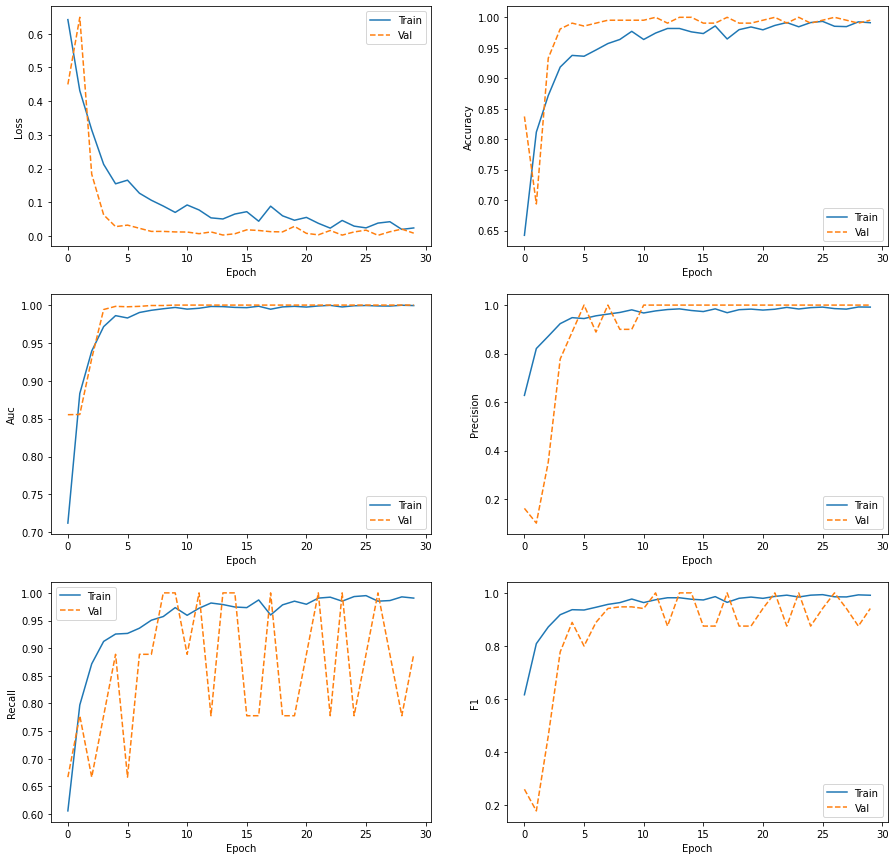

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 1


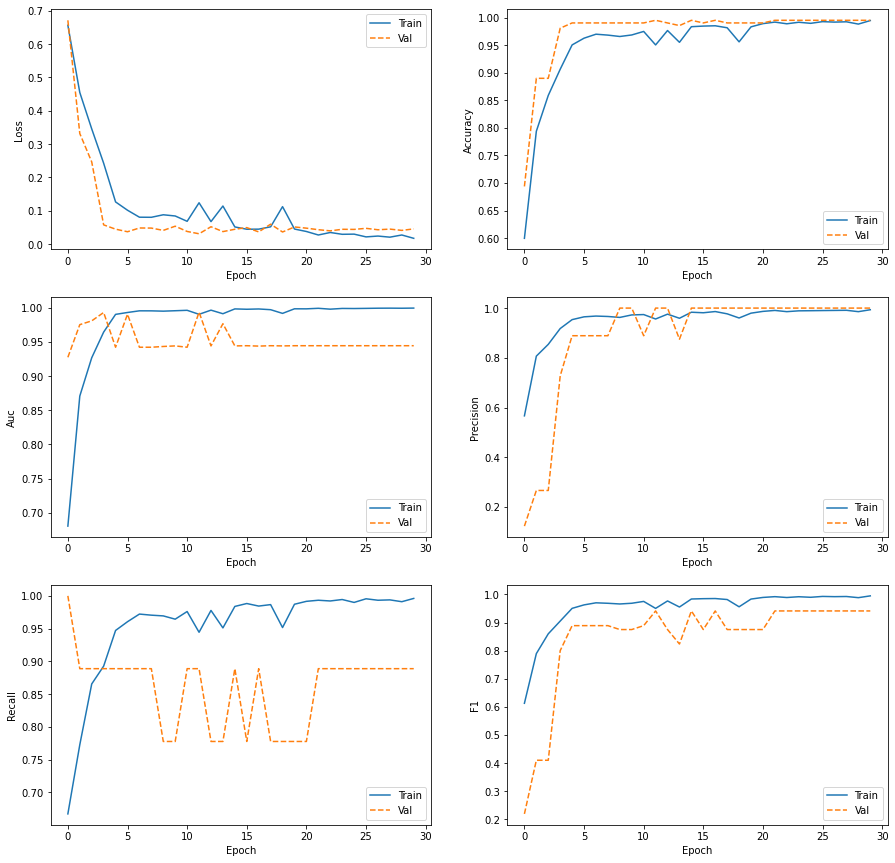

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


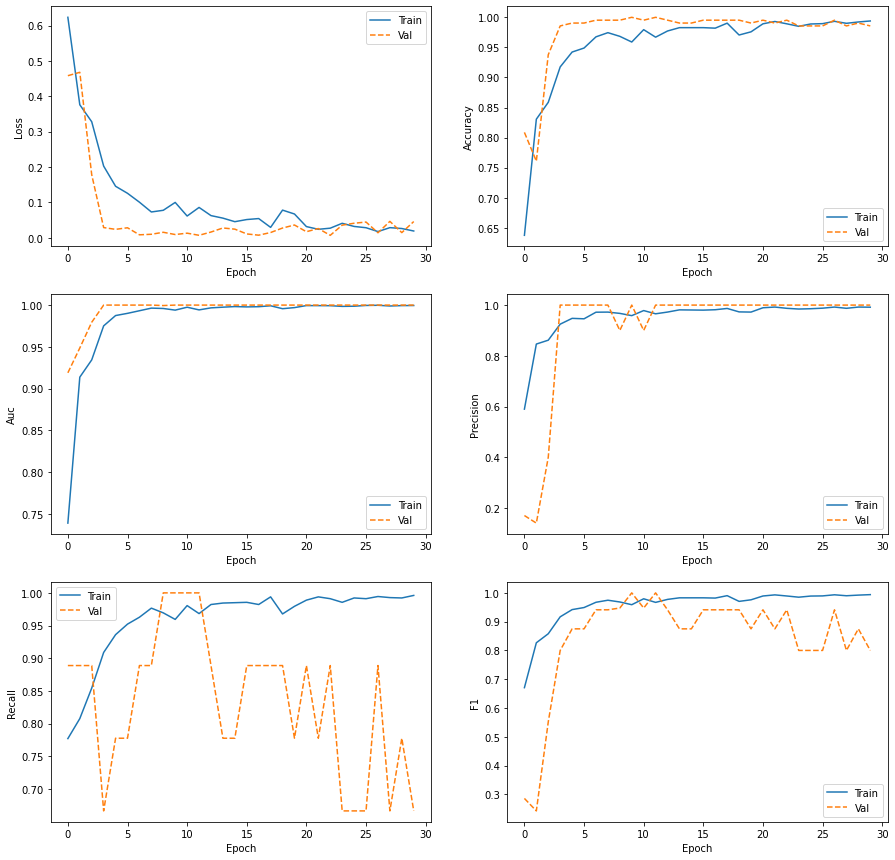

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.67      0.80         9

    accuracy                           0.99       209
   macro avg       0.99      0.83      0.90       209
weighted avg       0.99      0.99      0.98       209


Iteration 3


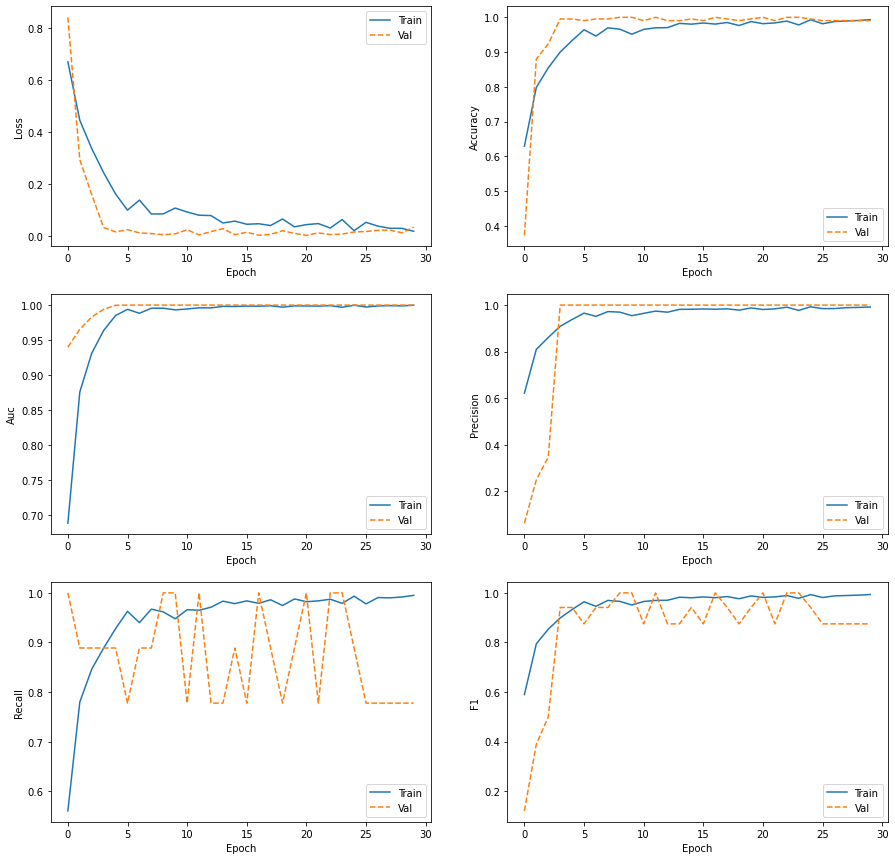

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 4


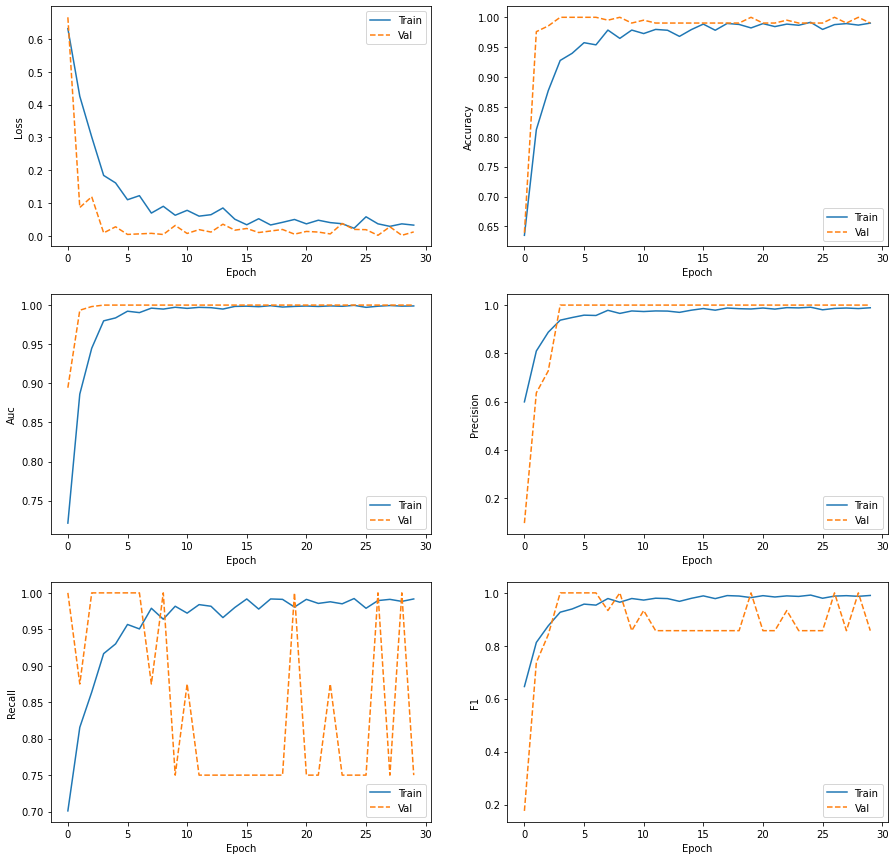

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 5


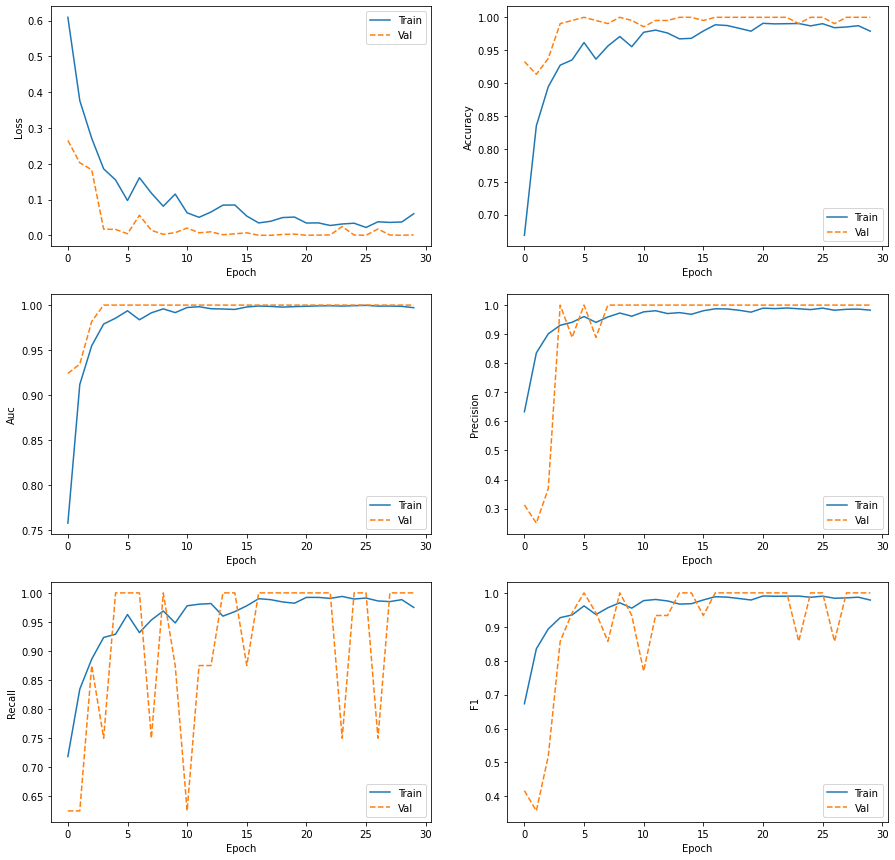

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Iteration 6


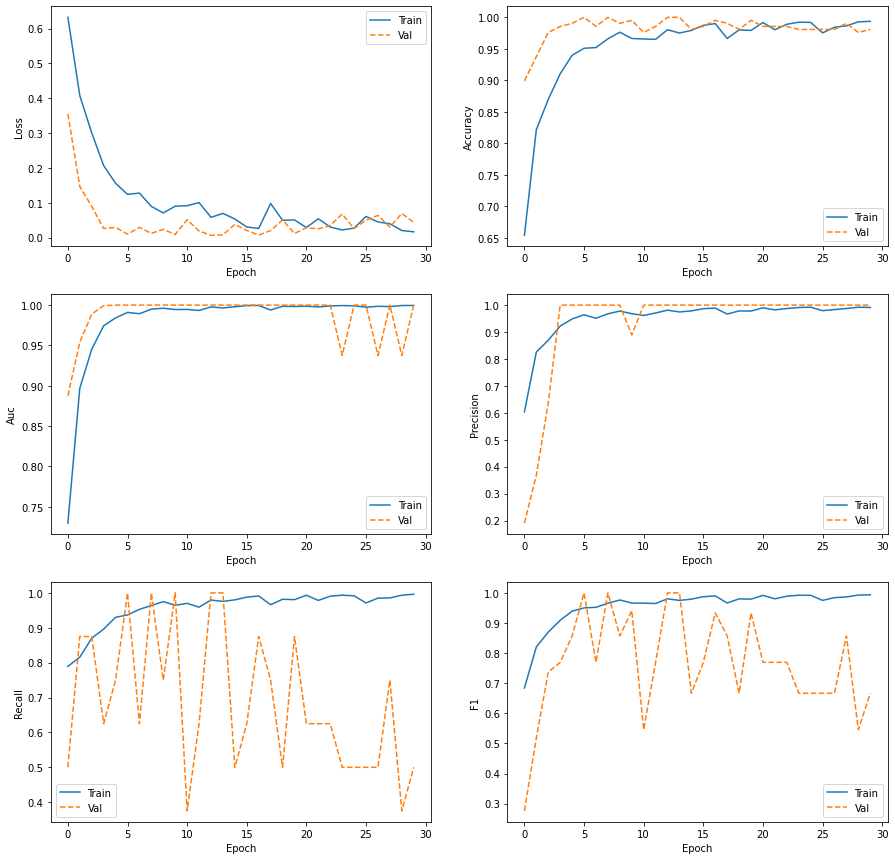

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 7


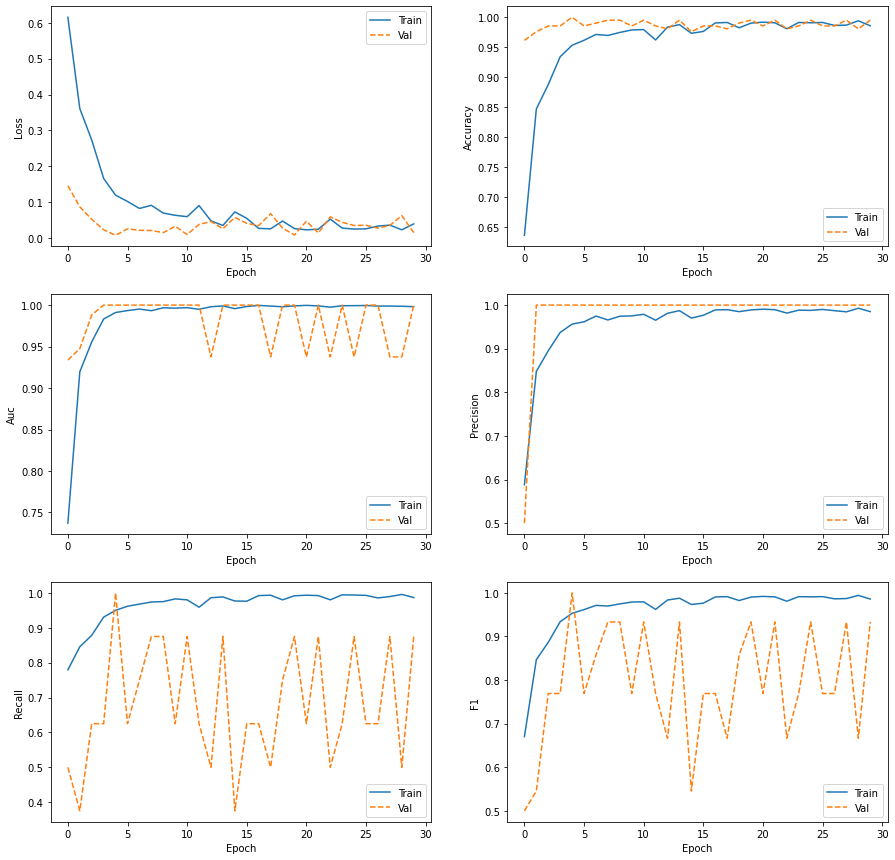

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 8


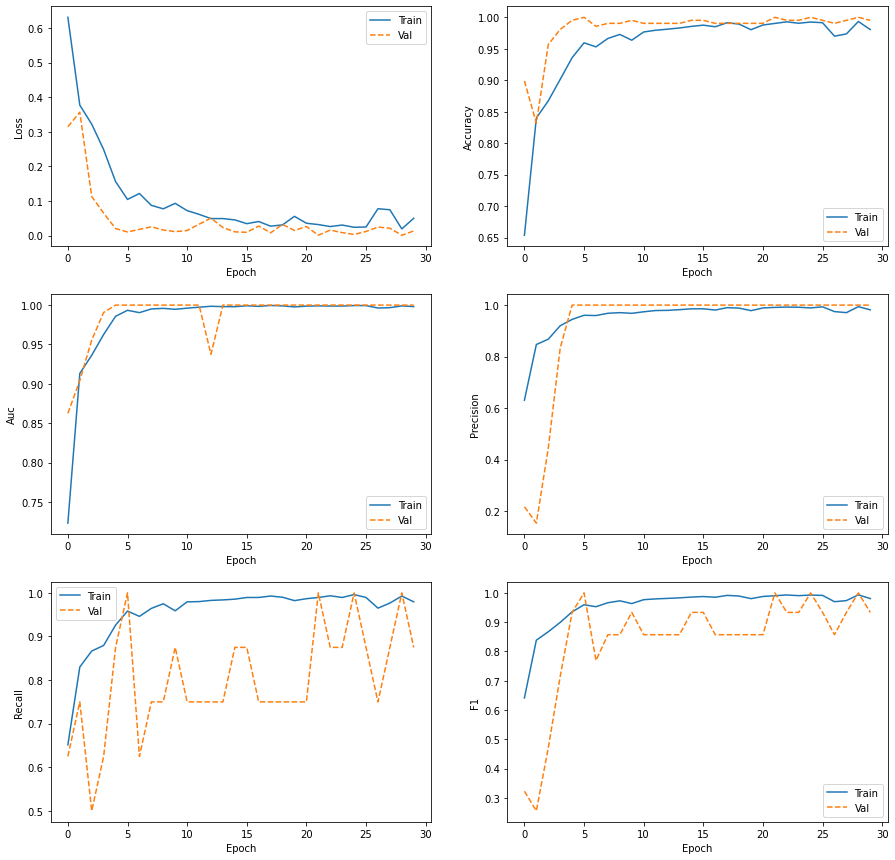

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


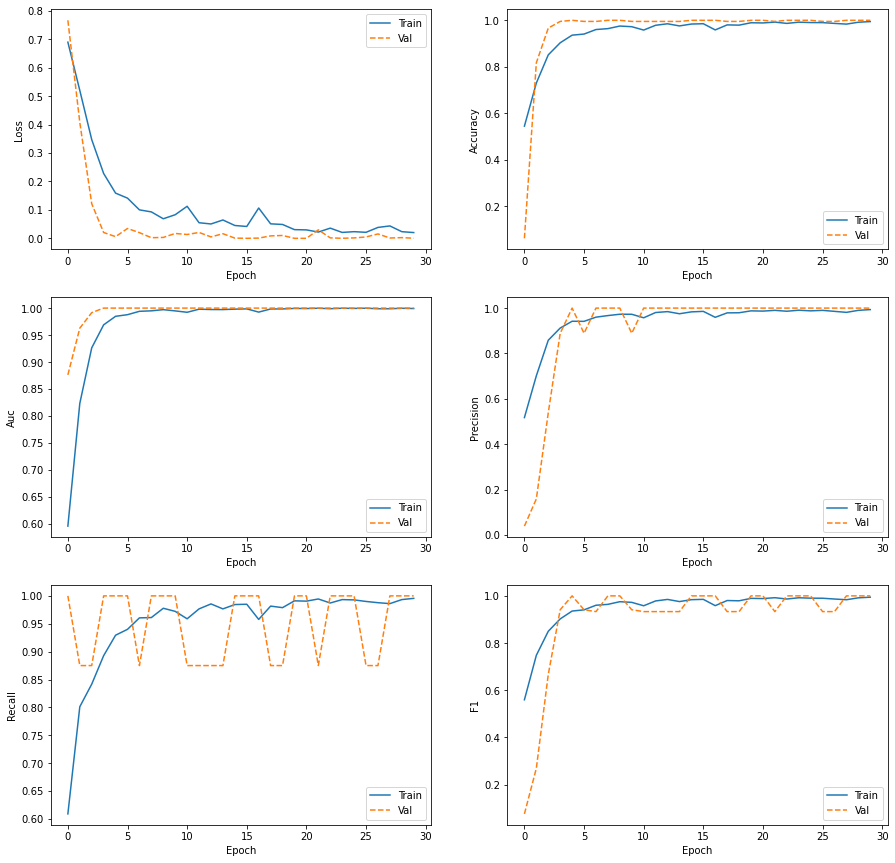

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[1998    2]
 [  11   73]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00      2000
       Covid       0.97      0.87      0.92        84

    accuracy                           0.99      2084
   macro avg       0.98      0.93      0.96      2084
weighted avg       0.99      0.99      0.99      2084

['0:16:20.155364', '0:16:33.790907', '0:16:03.070195', '0:16:07.475235', '0:16:47.320238', '0:16:45.154479', '0:16:33.110974', '0:17:04.586179', '0:16:36.366623', '0:16:48.521305']


In [41]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      if (p[i]+r[i])== 0:
        f1_single = 0
      else:
        f1_single = 2*(p[i]*r[i])/(p[i]+r[i])
      f1.append(f1_single)
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.median(best))
print("Median best epoch: ", val_epoch+1)

val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.50)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("Covid/histories/model"+str(model_number)):
    os.makedirs("Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[i], open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)



# Load Histories

History 0


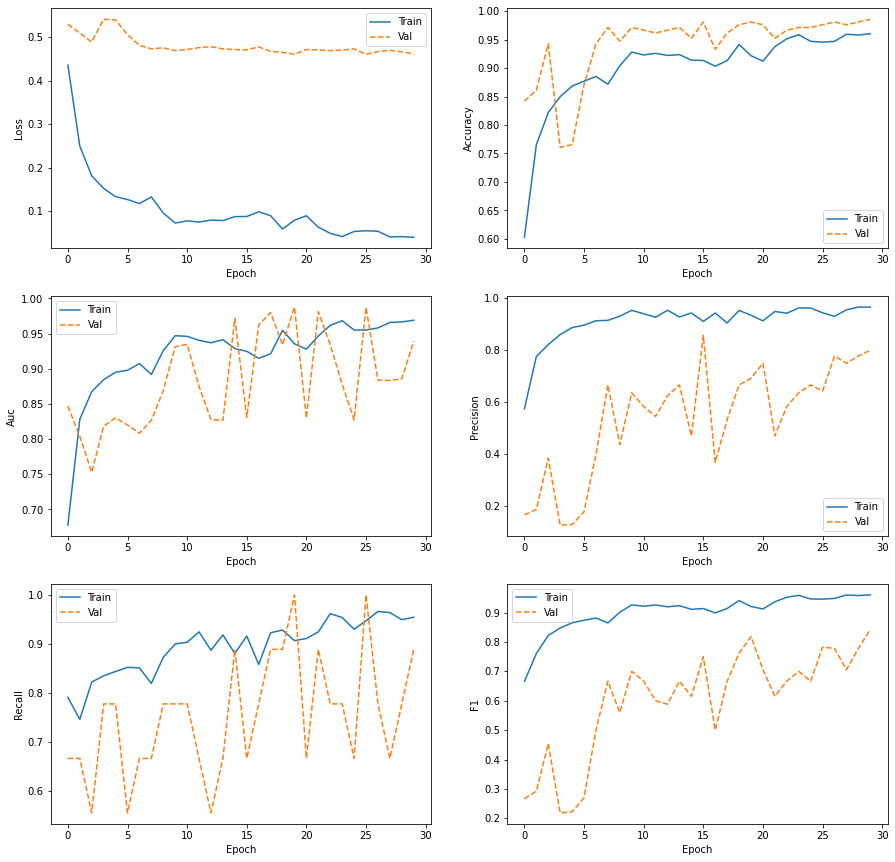

History 1


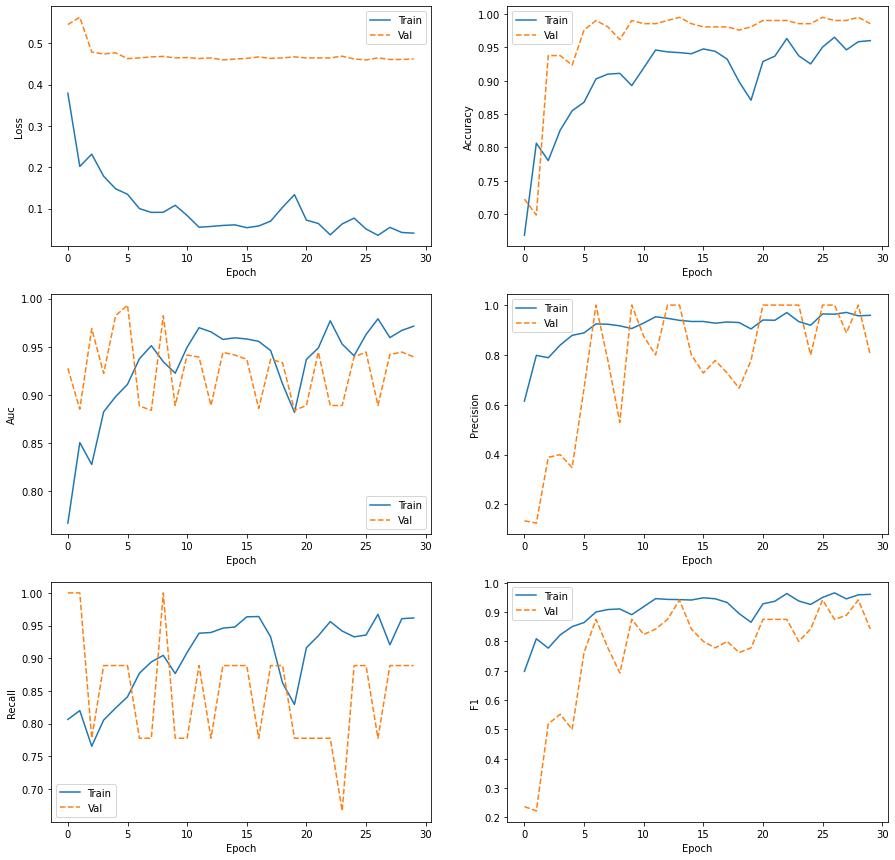

History 2


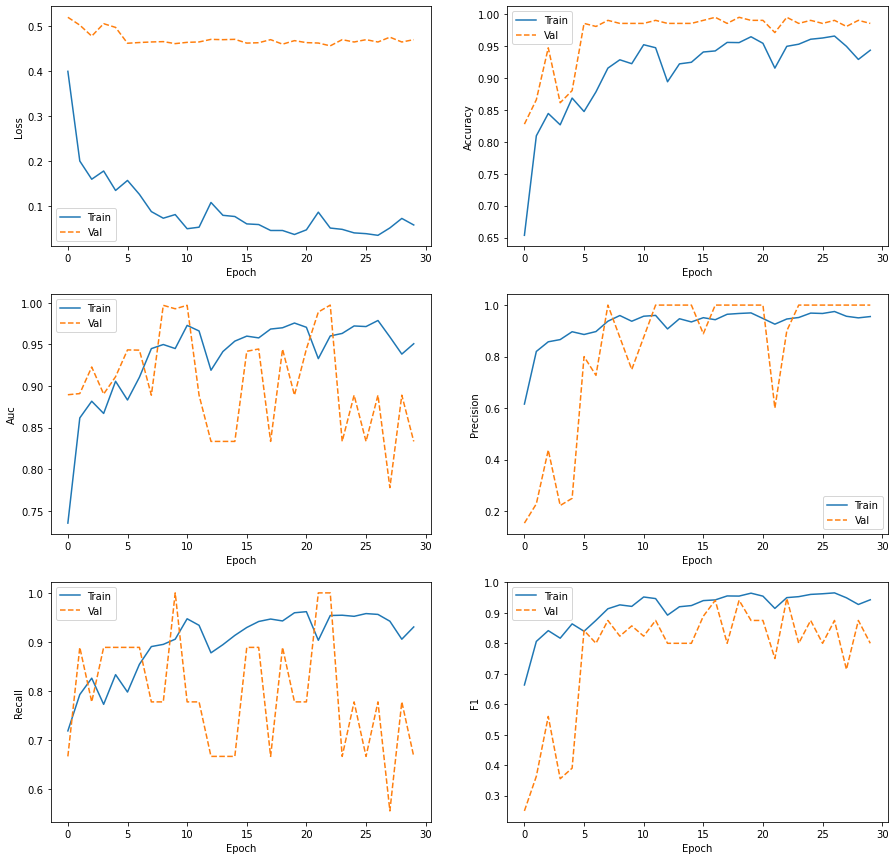

History 3


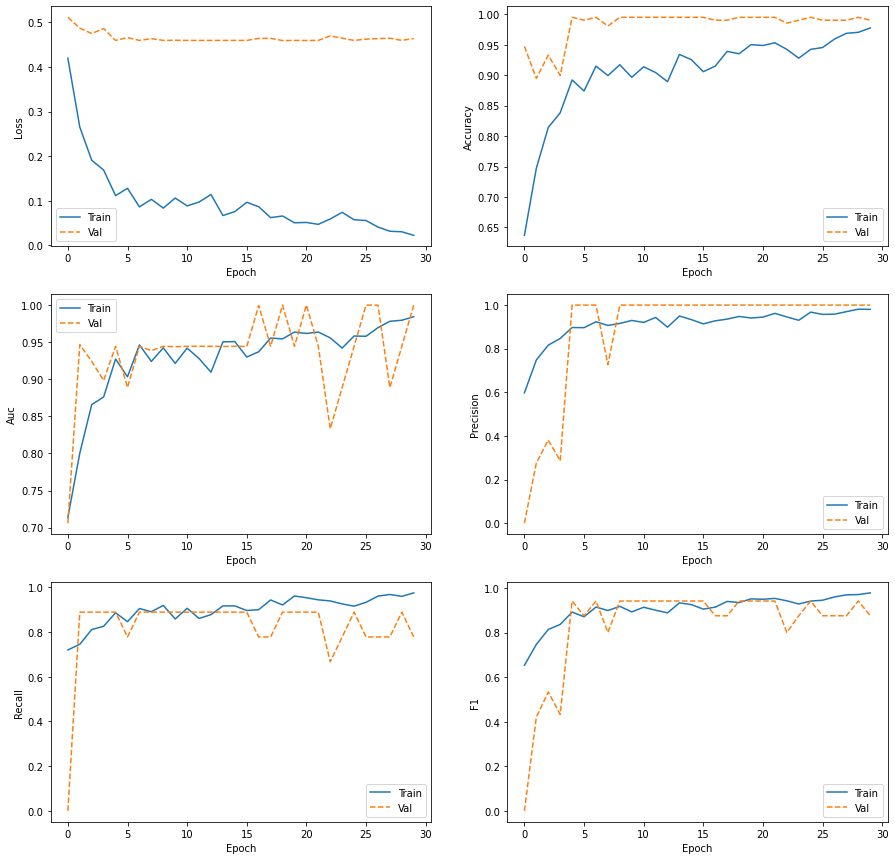

History 4


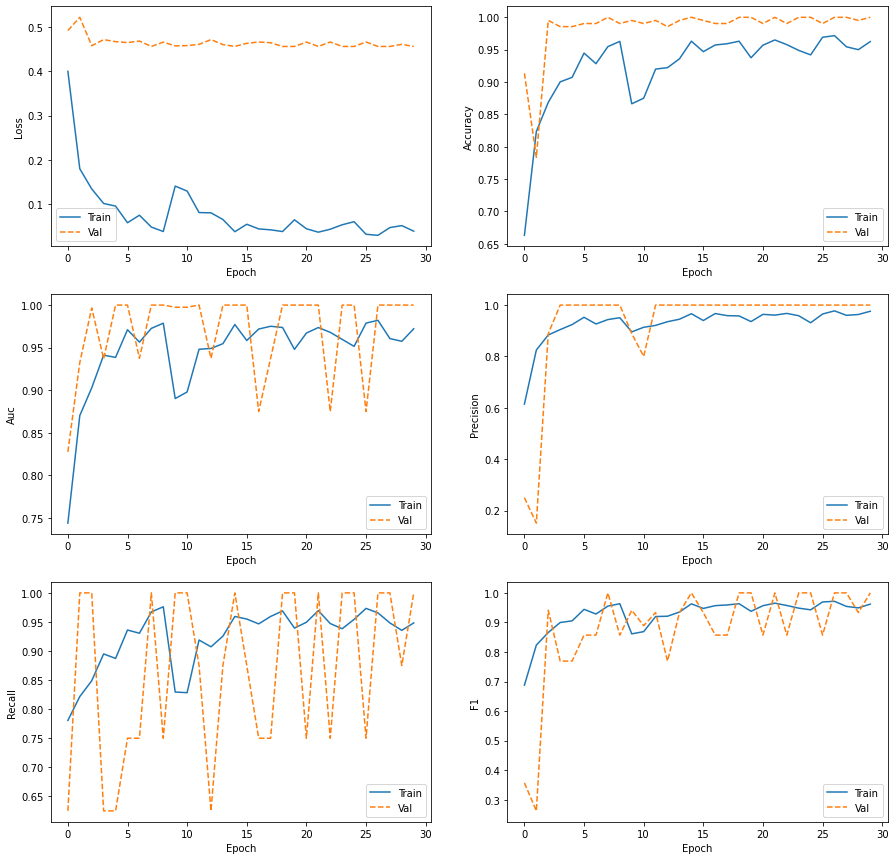

History 5


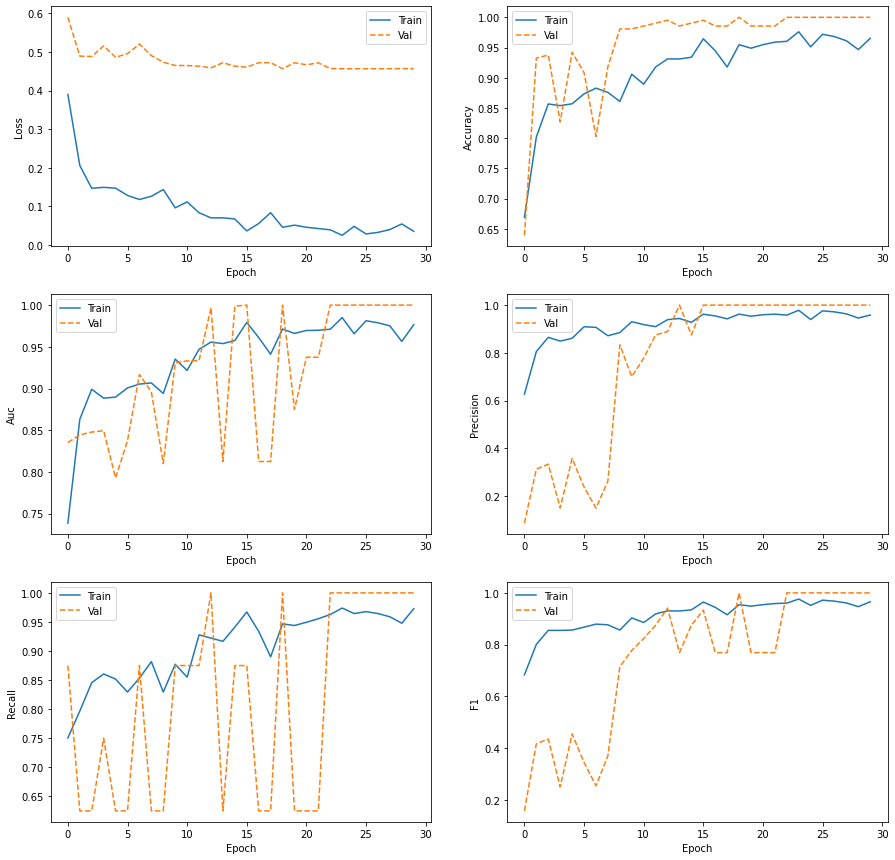

History 6


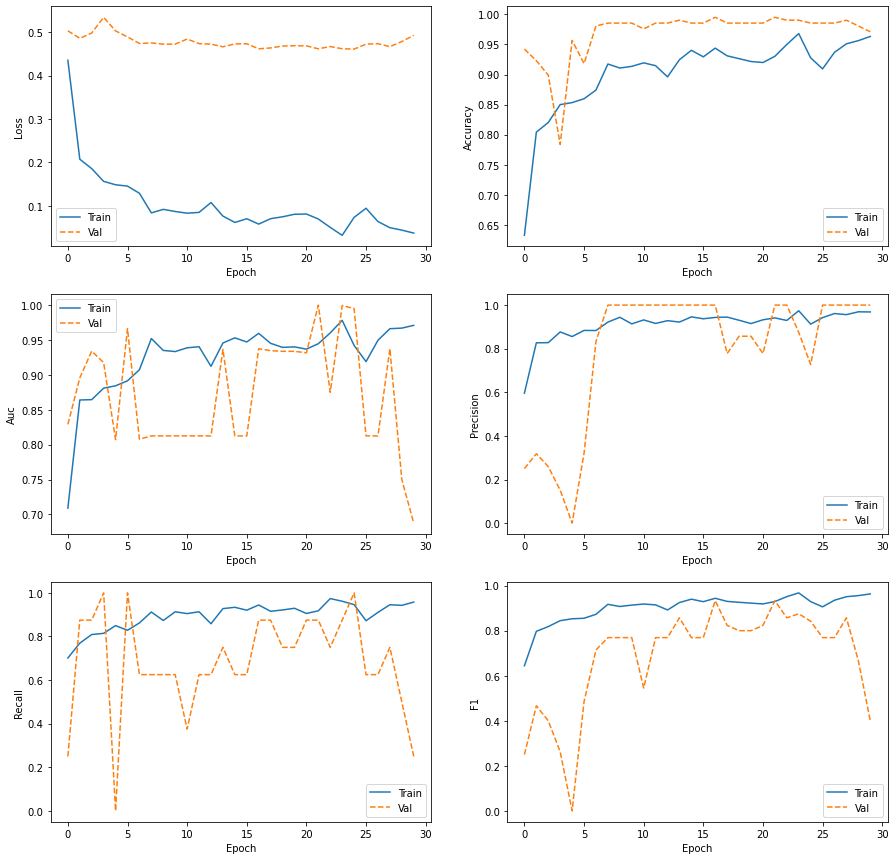

History 7


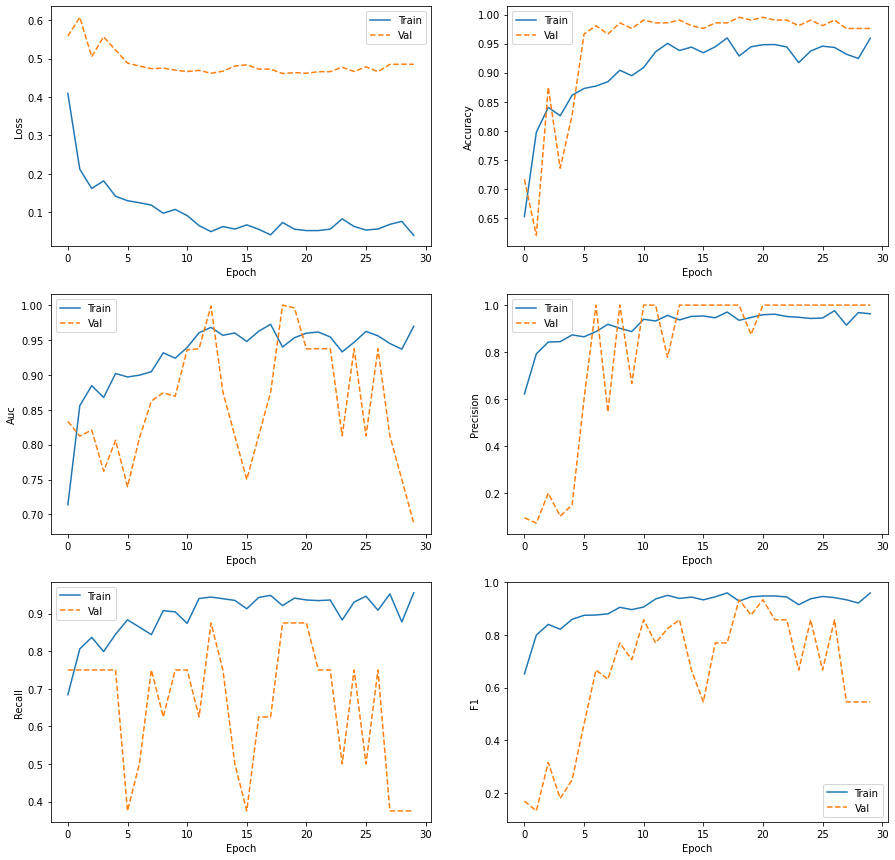

History 8


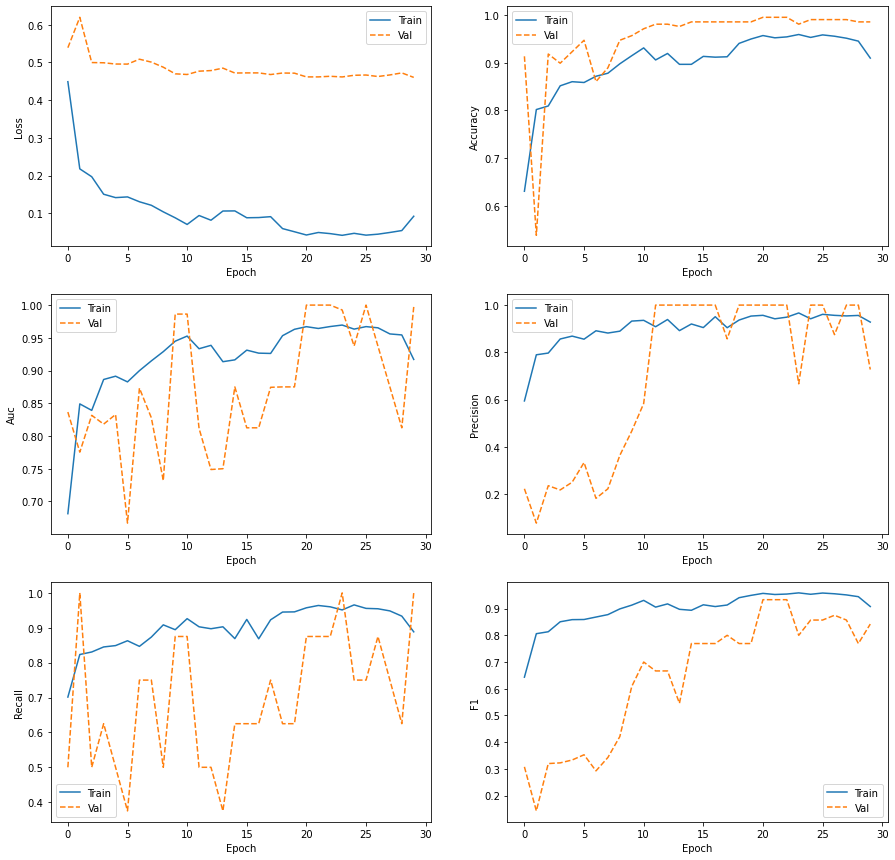

History 9


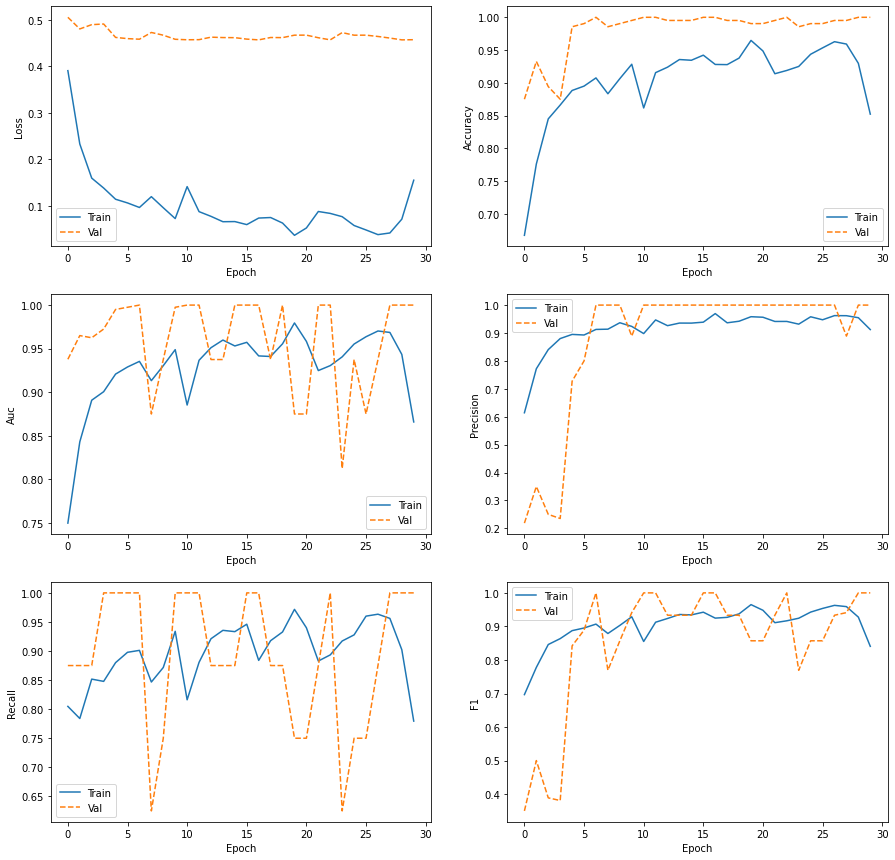

In [21]:
model_number = 72
histories = []
number_of_its = 10
for i in range(number_of_its):
    history = json.load(open("Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'r'))
    print("History " + str(i))
    histories.append(history)
    plot_metrics(history)